In [1]:
import numpy as np
import pandas as pd
import glob

from sklearn.decomposition import IncrementalPCA
from pathlib import Path


# Functions

In [2]:
import seaborn as sns
snscolors = np.array(sns.color_palette())
def pcacomponentplots(ax,vh,ylabels,colors=None):
    numev = vh.shape[0]
    xlim = 1.05*np.max(np.abs(vh))
    if colors is None:
        colors = np.tile([0.35,0.35,0.35],(numev,1))
    elif len(colors)<numev:
        colors = np.tile(colors,(numev,1))
    for evnum in range(numev):
        a=ax[evnum]
        x=vh[evnum]
        y = np.flipud(np.arange(vh.shape[1]))
    #     ax.plot(x,y,'-o',label='$\\vec e_'+str(evnum)+'$: '+str(np.round(pcavar[evnum]*100,1))+'%',c=snscolors[evnum])
        thickness=0.75
        a.barh(y+0*(evnum-1)*thickness,x,height=thickness,color=colors[evnum])
        a.set_yticks(y)
        a.set_yticklabels(ylabels,rotation='horizontal',fontsize=12)
        a.tick_params(labelsize=12)
        a.axvline(0,c='k',linestyle='-',linewidth=1)
#         a.set_title(label='$\\vec v_'+str(evnum)+'$: '+str(np.round(pcavar[evnum]*100,1))+'%',fontsize=14)
        a.set_xlim([-xlim,xlim])
        a.set_ylim([-0.5,len(y)-0.5])

def plot_tsne_withcolors(ax,tsne_result,quantity,title,corrskip=1,plotskip=1,colortype='scalar',qmin=0.001,qmax=0.999,alphaval=0.3,s=4,coloroffset=0,cmapname='cool',setxylimquantile=False):
    colordata = quantity.copy()
    if len(colordata)>len(tsne_result):
        colordata = colordata[::corrskip]
    if len(colordata.shape)>1:
        colordata = colordata[:,0]
    if colortype=='scalar':
        cmap=plt.get_cmap(cmapname)  # or 'cool'
        q0,q1 = np.quantile(colordata,[qmin,qmax])
        colordata = colordata-q0
        colordata = colordata/(q1-q0)
        colordata[colordata<0] = 0
        colordata[colordata>1] = 1
        colordata *= 0.99
        colors = cmap(colordata)
    else:
#         cmap=plt.get_cmap('Set1')
        colors = snscolors[colordata.astype(int)+coloroffset]
    tp = tsne_result
    # [ax.scatter([-100],[-100],alpha=1,s=10,color=cmap(i*0.99/np.max(groupvalues)),label='group '+str(i)) for i in np.arange(max(groupvalues)+1)]  # legend hack
    scatterplot = ax.scatter(tp[::plotskip,0],tp[::plotskip,1],s=s,alpha=alphaval,color=colors[::plotskip],rasterized=True)
    if setxylimquantile:
        ax.set_xlim(np.quantile(tp[:,0],[qmin,qmax]))
        ax.set_ylim(np.quantile(tp[:,1],[qmin,qmax]))
    else:
        ax.set_xlim(np.quantile(tp[:,0],[0,1]))
        ax.set_ylim(np.quantile(tp[:,1],[0,1]))
    ax.set_title(title,fontsize=16)       
    return scatterplot, colordata    

# Data import

In [3]:
datadir = Path("/Volumes/JD-SSD/ESI-mice/data/")
base = "/Volumes/JD-SSD/ESI-mice/"
files = sorted(datadir.glob("*npz"))
print(f"Found {len(files)} files")

Found 0 files


In [5]:
# ----------------------------
# Helper: load and flatten one file
# ----------------------------
def load_npz_to_df(filepath):
    data = np.load(filepath, allow_pickle=True)
    keys = data.files
    n = data['time'].shape[0] if 'time' in data.files else next(v.shape[0] for v in data.values() if v.ndim > 0)

    # keys to ignore
    skip_keys = {'tracklets', 'tracklet_vxys', 'video_size', 'cm_per_pixel','id',
                 'frame_rate', 'detect_type', 'detect_format'}

    cols = {}
    for k in sorted(keys):
        if k in skip_keys:
            continue
        v = data[k]
        # Scalar → broadcast
        if np.ndim(v) == 0:
            cols[k] = np.repeat(v.item(), n)
        # 1D array → direct
        elif v.ndim == 1:
            cols[k] = v
        # Multi-D array → flatten trailing dimensions
        else:
            flat = v.reshape(n, -1)
            for i in range(flat.shape[1]):
                cols[f"{k}_{i}"] = flat[:, i]

    df = pd.DataFrame(cols)
    # Add ID
    if 'id' in data.files and np.ndim(data['id']) > 0:
        id_val = data['id'][0]
    else:
        # fallback: infer from filename (digits at the end)
        id_val = int(''.join([ch for ch in filepath.stem if ch.isdigit()]) or 0)
    df['id'] = id_val
    return df

# ----------------------------
# Combine all
# ----------------------------
dfs = []
for f in files:
    print("Loading", f.name)
    try:
        dfs.append(load_npz_to_df(f))
    except Exception as e:
        print(f"⚠️  Skipping {f.name} due to error: {e}")

df = pd.concat(dfs, ignore_index=True)
print(f"Combined shape: {df.shape}, {df['id'].nunique()} IDs")

# get constant values
data = np.load(files[0], allow_pickle=True)

cm_per_pixel = data['cm_per_pixel'][0]
video_size = data['video_size']
frame_rate = data['frame_rate'][0]

Loading concat_2024-11-11_id0.npz
Loading concat_2024-11-11_id1.npz
Loading concat_2024-11-11_id2.npz
Loading concat_2024-11-11_id3.npz
Combined shape: (86635, 43), 4 IDs


### CALMS DATA

In [67]:
datadir = Path("/home/jdavidson/calms21/data")
base = "/home/jdavidson/calms21/"
files = sorted(datadir.glob("*npy"))
print(f"Found {len(files)} files")

Found 8 files


In [68]:
import numpy as np
import pandas as pd
from pathlib import Path
import json

# ---- CONFIG: set these if you know the landmark mapping for CalMS21 ----
# If you know which landmark indices define heading (tail->neck), set them:
NECK_IDX = None  # e.g., 3
TAIL_IDX = None  # e.g., 5

def load_calms21(path):
    """
    Load a single CalMS21 file: either .npy (dict) produced by the converter,
    or the original .json (same nested structure but with lists).
    Returns a nested dict: group -> seq_id -> dict(...)
    """
    p = Path(path)
    if p.suffix == ".npy":
        data = np.load(p, allow_pickle=True).item()
    elif p.suffix == ".json":
        with open(p, "r") as f:
            data = json.load(f)
        # leave lists; we’ll np.array() per-sequence below
    else:
        raise ValueError("Path must be a .npy or .json file")
    return data

def angle_from_two_points(neck_xy, tail_xy):
    # heading from tail -> neck, angle w.r.t +x (radians)
    v = neck_xy - tail_xy
    return np.arctan2(v[:,1], v[:,0])

def angle_from_pca(XY): 
    """
    PCA-based heading (fallback). XY: (T, 7, 2) landmarks for one animal.
    We use the first principal component per frame; sign is arbitrary.
    """
    T = XY.shape[0]
    ang = np.zeros(T, dtype=float)
    for t in range(T):
        pts = XY[t]  # (7,2)
        mu = pts.mean(axis=0)
        c = pts - mu
        cov = c.T @ c
        vals, vecs = np.linalg.eigh(cov)
        v = vecs[:, np.argmax(vals)]  # 2-vector
        ang[t] = np.arctan2(v[1], v[0])
    return ang

def to_trex_df(one_seq_dict, groupname, seq_id):
    """
    Convert a single sequence dict to TRex-like long DataFrame (rows = frames x animals).
    """
    # Pick features: either 'features' present or 'keypoints'
    use_features = ("features" in one_seq_dict)
    if use_features:
        # not used in TRex columns; just keep for later if you wish
        features = np.asarray(one_seq_dict["features"])  # (T, 60)
    keypoints = np.asarray(one_seq_dict["keypoints"])    # (T, 2, 2, 7)
    scores    = np.asarray(one_seq_dict["scores"])       # (T, 2, 7)
    ann       = np.asarray(one_seq_dict["annotations"]) if "annotations" in one_seq_dict else None
    meta      = one_seq_dict.get("metadata", {})
    fps       = float(meta.get("fps", meta.get("frame_rate", 30.0)))

    T = keypoints.shape[0]
    n_anim = keypoints.shape[1]
    n_lm   = keypoints.shape[3]
    assert n_anim == 2, f"Expected 2 animals, found {n_anim}"
    assert n_lm == 7,   f"Expected 7 keypoints, found {n_lm}"

    rows = []
    for a in range(n_anim):
        # Extract XY for this animal: (T, 7, 2)
        X = keypoints[:, a, 0, :]  # (T, 7)
        Y = keypoints[:, a, 1, :]  # (T, 7)
        XY = np.stack([X, Y], axis=-1)  # (T, 7, 2)

        # Centroid over landmarks
        cx = X.mean(axis=1)  # (T,)
        cy = Y.mean(axis=1)

        # Vel/acc (finite diff)
        VX = np.gradient(cx) * fps
        VY = np.gradient(cy) * fps
        SPEED = np.hypot(VX, VY)
        AX = np.gradient(VX) * fps
        AY = np.gradient(VY) * fps

        # Angle
        if (NECK_IDX is not None) and (TAIL_IDX is not None):
            neck = XY[:, NECK_IDX, :]  # (T,2)
            tail = XY[:, TAIL_IDX, :]
            ANGLE = angle_from_two_points(neck, tail)
        else:
            ANGLE = angle_from_pca(XY)

        # Build a per-frame DataFrame
        data = {
            "frame": np.arange(T, dtype=int),
            "time":  np.arange(T, dtype=float) / fps,
            "id":    np.full(T, a, dtype=int),
            "X#wcentroid": cx,
            "Y#wcentroid": cy,
            "VX": VX, "VY": VY,
            "SPEED": SPEED, "AX": AX, "AY": AY,
            "ANGLE": ANGLE,
            "group": np.full(T, groupname),
            "sequence": np.full(T, seq_id),
        }

        # Pose columns
        for k in range(n_lm):
            data[f"poseX{k}"] = X[:, k]
            data[f"poseY{k}"] = Y[:, k]

        # Optional: label per frame if present
        if ann is not None:
            # Task 1 typically: (T,) ints; Task 2/3 could be multi-annotator/binary stacks.
            lbl = ann
            if lbl.ndim > 1:
                # try to reduce sensibly (majority or first column)
                lbl = ann[:, 0]
            data["label"] = lbl.astype(int)

        rows.append(pd.DataFrame(data))

    out = pd.concat(rows, ignore_index=True)
    # Add placeholders for TRex fields you don’t have:
    out["missing"] = False
    out["visual_identification_p"] = 1.0
    out["timestamp"] = out["time"]
    # Optional placeholders commonly in your schema:
    for col in ["X","Y","SPEED#pcentroid","SPEED#wcentroid","midline_x","midline_y",
                "midline_length","midline_segment_length","normalized_midline",
                "ANGULAR_V#centroid","ANGULAR_A#centroid","BORDER_DISTANCE#pcentroid",
                "MIDLINE_OFFSET","num_pixels","detection_p"]:
        if col not in out.columns:
            out[col] = np.nan

    return out

def calms21_to_trex_df(path):
    """
    Load a CalMS21 .npy/.json and return a single concatenated TRex-like DataFrame
    for all groups and sequences inside.
    """
    nested = load_calms21(path)
    dfs = []
    for groupname, group in nested.items():
        for seq_id, seq in group.items():
            # ensure arrays
            seq = {
                k: (np.array(v) if isinstance(v, list) else v)
                for k,v in seq.items()
            }
            dfs.append(to_trex_df(seq, groupname, seq_id))
    return pd.concat(dfs, ignore_index=True)

# --- Usage ---
# df_trex = calms21_to_trex_df("data/calms21_task1_train.npy")
# df_trex.head()


In [69]:
file = files[1]
file

PosixPath('/home/jdavidson/calms21/data/calms21_task1_train.npy')

In [70]:
df_trex = calms21_to_trex_df(file)
df_trex.head()

,frame,time,id,X#wcentroid,Y#wcentroid,VX,VY,SPEED,AX,AY,...,midline_y,midline_length,midline_segment_length,normalized_midline,ANGULAR_V#centroid,ANGULAR_A#centroid,BORDER_DISTANCE#pcentroid,MIDLINE_OFFSET,num_pixels,detection_p
0,0,0.000000,0,751.516347,223.200147,114.594203,102.276037,153.597588,-196.643110,-3091.564693,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.033333,0,755.336154,226.609349,108.039433,-0.776120,108.042221,-1206.251351,-3245.072564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.066667,0,758.718976,223.148406,34.177447,-114.062134,119.072534,-2447.076481,-2200.856820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.100000,0,757.614650,219.005206,-55.098999,-147.499908,157.455144,-2082.952685,-81.346298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.133333,0,755.045709,213.315079,-104.686066,-119.485221,158.858082,-800.787179,654.678167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
# only use a single video
df_trex['sequence'].unique()

array(['task1/train/mouse001_task1_annotator1',
       'task1/train/mouse002_task1_annotator1',
       'task1/train/mouse003_task1_annotator1',
       'task1/train/mouse004_task1_annotator1',
       'task1/train/mouse005_task1_annotator1',
       'task1/train/mouse006_task1_annotator1',
       'task1/train/mouse007_task1_annotator1',
       'task1/train/mouse008_task1_annotator1',
       'task1/train/mouse009_task1_annotator1',
       'task1/train/mouse010_task1_annotator1',
       'task1/train/mouse011_task1_annotator1',
       'task1/train/mouse012_task1_annotator1',
       'task1/train/mouse013_task1_annotator1',
       'task1/train/mouse014_task1_annotator1',
       'task1/train/mouse015_task1_annotator1',
       'task1/train/mouse016_task1_annotator1',
       'task1/train/mouse017_task1_annotator1',
       'task1/train/mouse018_task1_annotator1',
       'task1/train/mouse019_task1_annotator1',
       'task1/train/mouse020_task1_annotator1',
       'task1/train/mouse021_task1_annot

In [72]:
# df = df_trex[df_trex['sequence']=='task1/test/mouse071_task1_annotator1']
cm_per_pixel = 1

In [73]:
df = df_trex

# behavioral decomposition

In [74]:
# === Pair-level Klibaite-style social decomposition (IncrementalPCA with 6 comps) ===
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.decomposition import IncrementalPCA

# -----------------------------
# 0) Assumes you already have df with pose & tracking
# -----------------------------
# df = pd.read_parquet("your_pose_dataframe.parquet")

# -----------------------------
# 1) Config
# -----------------------------
POSE_N = 7
POSE_X_COLS = [f"poseX{i}" for i in range(POSE_N)]
POSE_Y_COLS = [f"poseY{i}" for i in range(POSE_N)]
POSE_COLS = POSE_X_COLS + POSE_Y_COLS

ORDER_COL = "frame" if "frame" in df.columns else ("time" if "time" in df.columns else None)
ID_COL    = "id" if "id" in df.columns else None
SEQ_COL   = "sequence" if "sequence" in df.columns else None

# PCA per paper: 6 components for shared postural representation
N_COMPONENTS = 6
BATCH_SIZE   = 5000

# Cleaning/interp parameters (per individual)
LINEAR_INTERP_LIMIT    = 10
EDGE_FILL_LIMIT        = 3
MAX_MISSING_FRACTION   = 0.1

# Pair feature options
INCLUDE_INTRA_A = True   # lower-tri distances within animal A
INCLUDE_INTRA_B = True   # lower-tri distances within animal B
INCLUDE_INTER   = True   # all A×B cross distances
DUPLICATE_PERSPECTIVE = True  # add (B,A) order as second sample per frame

OUT_DIR = Path(base + "socialmapper_outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# -----------------------------
# 2) Sanity checks
# -----------------------------
need = (POSE_COLS + ([ORDER_COL] if ORDER_COL else []) + ([ID_COL] if ID_COL else []))
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")
if ORDER_COL is None:
    raise ValueError("Need either 'frame' or 'time' column to order frames.")
if ID_COL is None:
    df = df.copy()
    df["id"] = 0
    ID_COL = "id"
if SEQ_COL is None:
    df = df.copy()
    df["sequence"] = "seq0"
    SEQ_COL = "sequence"

# Keep only needed columns
keep_cols = [SEQ_COL, ID_COL, ORDER_COL] + POSE_COLS
df_small = df[keep_cols].copy()
df_small[ORDER_COL] = df_small[ORDER_COL].astype(int, errors="ignore")
df_small[POSE_COLS] = df_small[POSE_COLS].replace([np.inf, -np.inf], np.nan)

# -----------------------------
# 3) Clean/interpolate per individual
# -----------------------------
def clean_one_group(g: pd.DataFrame) -> pd.DataFrame:
    g = g.sort_values(ORDER_COL).copy()
    g = g.set_index(ORDER_COL)

    g[POSE_COLS] = g[POSE_COLS].interpolate(
        method="linear", limit=LINEAR_INTERP_LIMIT, limit_direction="both"
    )
    g[POSE_COLS] = g[POSE_COLS].ffill(limit=EDGE_FILL_LIMIT)
    g[POSE_COLS] = g[POSE_COLS].bfill(limit=EDGE_FILL_LIMIT)

    miss_frac = g[POSE_COLS].isna().mean(axis=1)
    g = g.loc[miss_frac <= MAX_MISSING_FRACTION].copy()

    if g[POSE_COLS].isna().any().any():
        med = g[POSE_COLS].median()
        g[POSE_COLS] = g[POSE_COLS].fillna(med)

    g = g.reset_index()
    return g

df_small = (
    df_small
    .groupby([SEQ_COL, ID_COL], group_keys=False)
    .apply(clean_one_group, include_groups=True)
)

# Final assert: no NaNs left in pose cols
if df_small[POSE_COLS].isna().any().any():
    raise ValueError("NaNs remain after cleaning pose columns.")

# -----------------------------
# 4) Build dyad pairs per sequence by inner-joining on frame
#    (assumes two animals per sequence; if more, pairs the first two by default)
# -----------------------------
pair_index = []   # list of (sequence, idA, idB)
pairs_per_seq = {}  # seq -> (idA, idB)

for seq, gseq in df_small.groupby(SEQ_COL):
    ids = sorted(gseq[ID_COL].unique())
    if len(ids) < 2:
        continue
    idA, idB = ids[:2]
    pairs_per_seq[seq] = (idA, idB)
    pair_index.append((seq, idA, idB))

if not pair_index:
    raise ValueError("No sequences with at least two IDs found to form dyads.")

# Precompute lower-tri indices for intra distances
tri_i, tri_j = np.tril_indices(POSE_N, k=-1)
n_intra = len(tri_i)
n_cross = POSE_N * POSE_N

# Determine feature length
feat_len = 0
if INCLUDE_INTRA_A: feat_len += n_intra
if INCLUDE_INTRA_B: feat_len += n_intra
if INCLUDE_INTER:   feat_len += n_cross

def pose_to_points(row_vals: np.ndarray):
    # row_vals shape: (2N,) = [poseX0..N-1, poseY0..N-1]
    xs = row_vals[:POSE_N]
    ys = row_vals[POSE_N:]
    return np.stack([xs, ys], axis=1)  # (N,2)

def intra_lower_tri_dists(pts: np.ndarray):
    dif = pts[tri_i] - pts[tri_j]
    return np.sqrt((dif**2).sum(axis=1))  # (n_intra,)

def inter_all_dists(ptsA: np.ndarray, ptsB: np.ndarray):
    # (N,2) vs (N,2) -> (N*N,)
    # broadcast pairwise
    dif = ptsA[:, None, :] - ptsB[None, :, :]  # (N, N, 2)
    d = np.sqrt((dif**2).sum(axis=2))          # (N, N)
    return d.ravel()                            # (N*N,)

def build_pair_features(rowA: np.ndarray, rowB: np.ndarray):
    """
    rowA/rowB: (2N,) arrays of [poseX..., poseY...]
    Return concatenated [intraA, intraB, interAB] (as configured).
    """
    ptsA = pose_to_points(rowA)
    ptsB = pose_to_points(rowB)
    parts = []
    if INCLUDE_INTRA_A:
        parts.append(intra_lower_tri_dists(ptsA))
    if INCLUDE_INTRA_B:
        parts.append(intra_lower_tri_dists(ptsB))
    if INCLUDE_INTER:
        parts.append(inter_all_dists(ptsA, ptsB))
    return np.concatenate(parts, axis=0)  # (feat_len,)

# -----------------------------
# 5) Streaming generator over all sequences (batched)
# -----------------------------
def dyad_row_generator(df_all: pd.DataFrame, batch_size: int):
    """
    Yields (X_batch, seqs, frames, perspectives)
    - X_batch: (B, feat_len)
    - seqs: list of sequence names (len=B)
    - frames: np.array of frame indices (len=B)
    - perspectives: np.array of 0 for (A,B) and 1 for (B,A) if duplicated, else 0
    """
    X_buf, seq_buf, frame_buf, persp_buf = [], [], [], []
    for seq, (idA, idB) in pairs_per_seq.items():
        gA = df_all[(df_all[SEQ_COL] == seq) & (df_all[ID_COL] == idA)][[ORDER_COL] + POSE_COLS]
        gB = df_all[(df_all[SEQ_COL] == seq) & (df_all[ID_COL] == idB)][[ORDER_COL] + POSE_COLS]

        # inner join on frame/time to synchronize
        gA = gA.rename(columns={ORDER_COL: "frame"})
        gB = gB.rename(columns={ORDER_COL: "frame"})
        j = gA.merge(gB, on="frame", suffixes=("_A", "_B"))  # (n_sync, ...)

        if j.empty:
            continue

        # Build features for synced rows
        XA = j[[c + "_A" for c in POSE_COLS]].to_numpy()  # (n_sync, 2N)
        XB = j[[c + "_B" for c in POSE_COLS]].to_numpy()  # (n_sync, 2N)
        frames = j["frame"].to_numpy()

        for i in range(XA.shape[0]):
            # perspective A->B
            X_feat = build_pair_features(XA[i], XB[i])
            X_buf.append(X_feat)
            seq_buf.append(seq)
            frame_buf.append(int(frames[i]))
            persp_buf.append(0)

            if DUPLICATE_PERSPECTIVE:
                # perspective B->A (flip order)
                X_feat_flip = build_pair_features(XB[i], XA[i])
                X_buf.append(X_feat_flip)
                seq_buf.append(seq)
                frame_buf.append(int(frames[i]))
                persp_buf.append(1)

            if len(X_buf) >= batch_size:
                yield np.vstack(X_buf), seq_buf, np.array(frame_buf), np.array(persp_buf, dtype=int)
                X_buf, seq_buf, frame_buf, persp_buf = [], [], [], []

    # flush
    if X_buf:
        yield np.vstack(X_buf), seq_buf, np.array(frame_buf), np.array(persp_buf, dtype=int)

# -----------------------------
# 6) Fit global IncrementalPCA (6 comps)
# -----------------------------
ipca = IncrementalPCA(n_components=min(N_COMPONENTS, feat_len))

# partial_fit streaming
for Xb, _, _, _ in dyad_row_generator(df_small, BATCH_SIZE):
    if not np.isfinite(Xb).all():
        i_bad = np.where(~np.isfinite(Xb))
        raise ValueError(f"Non-finite values in batch at indices {i_bad}")
    ipca.partial_fit(Xb)

print(f"[IPCA] Fitted on feature length {feat_len} -> {ipca.n_components_} comps")

# -----------------------------
# 7) Transform & save per sequence (keeping perspective)
# -----------------------------
# We’ll collect per (sequence, perspective) projections aligned to frame order
per_seq_persp = {}  # (seq, persp) -> dict(frames, Z_rows_list)

for Xb, seqs, frames, persp in dyad_row_generator(df_small, BATCH_SIZE):
    Zb = ipca.transform(Xb)  # (B, n_components)
    for p in (0, 1) if DUPLICATE_PERSPECTIVE else (0,):
        mask = (persp == p)
        if not np.any(mask):
            continue
        Zp = Zb[mask]
        seq_list = [s for s, m in zip(seqs, mask) if m]
        frames_p = frames[mask]
        for s in np.unique(seq_list):
            m2 = np.array([ss == s for ss in seq_list], dtype=bool)
            key = (s, p)
            if key not in per_seq_persp:
                per_seq_persp[key] = {"frames": [], "Z": []}
            per_seq_persp[key]["frames"].append(frames_p[m2])
            per_seq_persp[key]["Z"].append(Zp[m2])

# --- Save one file per (sequence, perspective) ---
for (seq, p), rec in per_seq_persp.items():
    frames_all = np.concatenate(rec["frames"])
    Z_all = np.vstack(rec["Z"])              # (n_frames_seq_p, n_components)
    sort_idx = np.argsort(frames_all)
    Z_sorted = Z_all[sort_idx].T             # (n_components, n_frames_sorted)

    # sanitize sequence name for filesystem
    safe_seq = str(seq).replace("/", "-").replace("\\", "-")

    out_path = OUT_DIR / f"social_projections_seq={safe_seq}_persp={p}.npz"
    np.savez_compressed(
        out_path,
        projections=Z_sorted,                # (6, n_frames)
        components=ipca.components_,         # (6, feat_len)
        mean_=ipca.mean_,                    # (feat_len,)
        tri_i=tri_i, tri_j=tri_j,            # intra mapping indices
        pose_points=POSE_N,
        include_intra_A=INCLUDE_INTRA_A,
        include_intra_B=INCLUDE_INTRA_B,
        include_inter=INCLUDE_INTER,
        duplicate_perspective=DUPLICATE_PERSPECTIVE,
        feature_len=feat_len,
        order_col=ORDER_COL,
        sequence=seq,
        perspective=p,                       # 0: A->B, 1: B->A
    )
    print(f"[SAVE] {out_path}  (frames={Z_sorted.shape[1]})")

print("Done: pair-level features + global 6D IPCA saved per sequence (and perspective).")

/tmp/ipykernel_40943/253400841.py:92: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(clean_one_group, include_groups=True)


[IPCA] Fitted on feature length 91 -> 6 comps
[SAVE] /home/jdavidson/calms21/socialmapper_outputs/social_projections_seq=task1-train-mouse001_task1_annotator1_persp=0.npz  (frames=21364)
[SAVE] /home/jdavidson/calms21/socialmapper_outputs/social_projections_seq=task1-train-mouse001_task1_annotator1_persp=1.npz  (frames=21364)
[SAVE] /home/jdavidson/calms21/socialmapper_outputs/social_projections_seq=task1-train-mouse002_task1_annotator1_persp=0.npz  (frames=19343)
[SAVE] /home/jdavidson/calms21/socialmapper_outputs/social_projections_seq=task1-train-mouse002_task1_annotator1_persp=1.npz  (frames=19343)
[SAVE] /home/jdavidson/calms21/socialmapper_outputs/social_projections_seq=task1-train-mouse003_task1_annotator1_persp=0.npz  (frames=13222)
[SAVE] /home/jdavidson/calms21/socialmapper_outputs/social_projections_seq=task1-train-mouse003_task1_annotator1_persp=1.npz  (frames=13222)
[SAVE] /home/jdavidson/calms21/socialmapper_outputs/social_projections_seq=task1-train-mouse004_task1_annota

In [75]:
# --------------------------------------
# 8) (Optional) quick sanity check
# --------------------------------------
import numpy as np
from pathlib import Path

# Find one saved projection file
npz_files = list(OUT_DIR.glob("social_projections_seq=*persp=*.npz"))
if not npz_files:
    raise FileNotFoundError("No social_projections_*.npz files found in output directory.")

test_file = npz_files[0]
data = np.load(test_file)

print(f"\n[CHECK] Loaded: {test_file.name}")
print(f"  projections shape : {data['projections'].shape}")
print(f"  components shape  : {data['components'].shape}")
print(f"  mean_ shape       : {data['mean_'].shape}")
print(f"  pose_points       : {data['pose_points']}")
print(f"  perspective       : {data['perspective']}")
print(f"  feature length    : {data['feature_len']}")
print(f"  Expected projection shape: ({min(N_COMPONENTS, data['components'].shape[0])}, n_frames)")

n_comp, n_frames = data["projections"].shape
assert n_comp == min(N_COMPONENTS, data["components"].shape[0]), \
    f"Unexpected n_components: got {n_comp}"
print("✅ Sanity check passed — projection dimensions match expected PCA config.")


[CHECK] Loaded: social_projections_seq=task3-groom-test-mouse003_task3_groom_persp=0.npz
  projections shape : (6, 18825)
  components shape  : (6, 91)
  mean_ shape       : (91,)
  pose_points       : 7
  perspective       : 0
  feature length    : 91
  Expected projection shape: (6, n_frames)
✅ Sanity check passed — projection dimensions match expected PCA config.


## Egocentric features

In [76]:
# ============================================================
# STEP 1.5 — Egocentric + kinematic features per sequence
#   Saves: ego_kinematics_seq=<safe_seq>_persp=<0|1>.npz
#   Shape saved: ego (n_feats, n_frames)  and frames (n_frames,)
# ============================================================
import numpy as np
from pathlib import Path

EGO_OUT_DIR = OUT_DIR  # reuse your output dir
EGO_OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- CONFIG: which keypoints define heading / center ---
# Adjust these indices to your skeleton if needed
# Default: heading = neck - tail_base, center = mean of all points
NECK_IDX      = 3         # e.g., neck
TAIL_BASE_IDX = 6         # e.g., tail base
CENTER_MODE   = "mean"    # "mean" or an integer index of a single point
FPS_DEFAULT   = 30.0

# Optional smoothing of positions before velocity (frames)
SMOOTH_WIN = 0            # 0 = no smoothing; else box filter window size (odd)

def _smooth_1d(x, win):
    if win <= 1:
        return x
    # simple centered moving average with reflection pad
    pad = win // 2
    xp = np.pad(x, pad_width=pad, mode="reflect")
    ker = np.ones(win, dtype=float) / win
    return np.convolve(xp, ker, mode="valid")

def _safe_unit(vx, vy, eps=1e-8):
    n = np.sqrt(vx*vx + vy*vy) + eps
    return vx / n, vy / n

def _angle(vx, vy):
    return np.arctan2(vy, vx)

def _unwrap_diff(theta, fps):
    # angular velocity (rad/s) with unwrap
    d = np.gradient(np.unwrap(theta), edge_order=1)
    return d * fps

def _center_from_points(xs, ys, mode):
    if isinstance(mode, int):
        return xs[:, mode], ys[:, mode]
    # mean of all points
    return xs.mean(axis=1), ys.mean(axis=1)

def _build_ego_block_for_joined(j, fps):
    """
    j: joined dataframe (per sequence) with columns:
       frame, poseXk_A, poseYk_A, poseXk_B, poseYk_B  (k=0..POSE_N-1)
    Returns:
      frames (T,), feats_AtoB (F,T), feats_BtoA (F,T), names (list of F names)
    """
    # --- extract matrices (T,N) for A and B
    T = len(j)
    N = POSE_N
    XA = j[[f"poseX{k}_A" for k in range(N)]].to_numpy()
    YA = j[[f"poseY{k}_A" for k in range(N)]].to_numpy()
    XB = j[[f"poseX{k}_B" for k in range(N)]].to_numpy()
    YB = j[[f"poseY{k}_B" for k in range(N)]].to_numpy()
    frames = j["frame"].to_numpy().astype(int)

    # optional smoothing before diffs (per keypoint)
    if SMOOTH_WIN and SMOOTH_WIN > 1:
        XA = np.vstack([_smooth_1d(XA[:, k], SMOOTH_WIN) for k in range(N)]).T
        YA = np.vstack([_smooth_1d(YA[:, k], SMOOTH_WIN) for k in range(N)]).T
        XB = np.vstack([_smooth_1d(XB[:, k], SMOOTH_WIN) for k in range(N)]).T
        YB = np.vstack([_smooth_1d(YB[:, k], SMOOTH_WIN) for k in range(N)]).T

    # centers
    cxA, cyA = _center_from_points(XA, YA, CENTER_MODE)
    cxB, cyB = _center_from_points(XB, YB, CENTER_MODE)

    # headings (neck - tail)
    hxA, hyA = XA[:, NECK_IDX] - XA[:, TAIL_BASE_IDX], YA[:, NECK_IDX] - YA[:, TAIL_BASE_IDX]
    hxB, hyB = XB[:, NECK_IDX] - XB[:, TAIL_BASE_IDX], YB[:, NECK_IDX] - YB[:, TAIL_BASE_IDX]
    uhxA, uhyA = _safe_unit(hxA, hyA)
    uhxB, uhyB = _safe_unit(hxB, hyB)

    # orthogonal (left-hand) unit
    uoxA, uoyA = -uhyA, uhxA
    uoxB, uoyB = -uhyB, uhxB

    # velocities (center point), m/s in pixel units -> per second with fps
    vAx = np.gradient(cxA) * fps
    vAy = np.gradient(cyA) * fps
    vBx = np.gradient(cxB) * fps
    vBy = np.gradient(cyB) * fps
    speedA = np.sqrt(vAx*vAx + vAy*vAy)
    speedB = np.sqrt(vBx*vBx + vBy*vBy)

    # heading angles and angular speeds
    thA = _angle(uhxA, uhyA)
    thB = _angle(uhxB, uhyB)
    angspeedA = _unwrap_diff(thA, fps)
    angspeedB = _unwrap_diff(thB, fps)

    # ego projections of velocity
    vA_para = vAx * uhxA + vAy * uhyA
    vA_perp = vAx * uoxA + vAy * uoyA
    vB_para = vBx * uhxB + vBy * uhyB
    vB_perp = vBx * uoxB + vBy * uoyB

    # displacement A->B in world
    dx = cxB - cxA
    dy = cyB - cyA
    distAB = np.sqrt(dx*dx + dy*dy)

    # A-centric ego coords of B
    dxA = dx * uhxA + dy * uhyA      # forward (+) if in front of A
    dyA = dx * uoxA + dy * uoyA      # left (+) if to the left of A

    # B-centric ego coords of A (for perspective flip)
    dxB = (-dx) * uhxB + (-dy) * uhyB
    dyB = (-dx) * uoxB + (-dy) * uoyB

    # relative heading (B wrt A): Δθ = θB - θA, encode as sin/cos
    dth = np.unwrap(thB) - np.unwrap(thA)
    rel_cos = np.cos(dth)
    rel_sin = np.sin(dth)

    # Feature stacks (A→B perspective first)
    names = [
        "A_speed", "A_v_para", "A_v_perp", "A_ang_speed",
        "A_heading_cos", "A_heading_sin",
        "AB_dist", "AB_dx_egoA", "AB_dy_egoA",
        "rel_heading_cos", "rel_heading_sin",
        # also include B kinematics (useful even in A→B view)
        "B_speed", "B_v_para", "B_v_perp", "B_ang_speed",
    ]
    AtoB = np.vstack([
        speedA, vA_para, vA_perp, angspeedA,
        np.cos(thA), np.sin(thA),
        distAB, dxA, dyA,
        rel_cos, rel_sin,
        speedB, vB_para, vB_perp, angspeedB,
    ]).astype(np.float32)

    # For B→A, swap roles and reuse the same ordering semantics (B is 'self')
    BtoA = np.vstack([
        speedB, vB_para, vB_perp, angspeedB,
        np.cos(thB), np.sin(thB),
        distAB, dxB, dyB,
        np.cos(-dth), np.sin(-dth),   # rel heading of A wrt B = -(θB-θA)
        speedA, vA_para, vA_perp, angspeedA,
    ]).astype(np.float32)

    return frames, AtoB, BtoA, names

# --- iterate sequences, build joined tables once (reuse from STEP 1) ---
for seq, (idA, idB) in pairs_per_seq.items():
    gA = df_small[(df_small[SEQ_COL] == seq) & (df_small[ID_COL] == idA)][[ORDER_COL] + POSE_COLS]
    gB = df_small[(df_small[SEQ_COL] == seq) & (df_small[ID_COL] == idB)][[ORDER_COL] + POSE_COLS]
    if gA.empty or gB.empty:
        continue

    gA = gA.rename(columns={ORDER_COL: "frame"})
    gB = gB.rename(columns={ORDER_COL: "frame"})
    j = gA.merge(gB, on="frame", suffixes=("_A", "_B"))
    if j.empty:
        continue

    # try to recover FPS if present in your earlier saved artifacts, else default
    fps = FPS_DEFAULT

    frames, AtoB, BtoA, feat_names = _build_ego_block_for_joined(j, fps)

    # sanitized seq name for file
    safe_seq = str(seq).replace("/", "-").replace("\\", "-")

    # save both perspectives
    for p, arr in [(0, AtoB), (1, BtoA)]:
        out_path = EGO_OUT_DIR / f"ego_kinematics_seq={safe_seq}_persp={p}.npz"
        np.savez_compressed(
            out_path,
            ego=arr,                   # (n_feats, n_frames)
            frames=frames,             # (n_frames,)
            fps=fps,
            feature_names=np.array(feat_names, dtype=object),
            pose_points=POSE_N,
            neck_idx=NECK_IDX,
            tail_base_idx=TAIL_BASE_IDX,
            center_mode=np.array([CENTER_MODE] if isinstance(CENTER_MODE, str) else [int(CENTER_MODE)], dtype=object),
            sequence=seq,
            perspective=p,
        )
        print(f"[EGO SAVE] {out_path.name}  -> {arr.shape} = (n_feats, n_frames)")

print("Done: egocentric + kinematic features saved for all sequences (both perspectives).")

[EGO SAVE] ego_kinematics_seq=task1-train-mouse001_task1_annotator1_persp=0.npz  -> (15, 21364) = (n_feats, n_frames)
[EGO SAVE] ego_kinematics_seq=task1-train-mouse001_task1_annotator1_persp=1.npz  -> (15, 21364) = (n_feats, n_frames)
[EGO SAVE] ego_kinematics_seq=task1-train-mouse002_task1_annotator1_persp=0.npz  -> (15, 19343) = (n_feats, n_frames)
[EGO SAVE] ego_kinematics_seq=task1-train-mouse002_task1_annotator1_persp=1.npz  -> (15, 19343) = (n_feats, n_frames)
[EGO SAVE] ego_kinematics_seq=task1-train-mouse003_task1_annotator1_persp=0.npz  -> (15, 13222) = (n_feats, n_frames)
[EGO SAVE] ego_kinematics_seq=task1-train-mouse003_task1_annotator1_persp=1.npz  -> (15, 13222) = (n_feats, n_frames)
[EGO SAVE] ego_kinematics_seq=task1-train-mouse004_task1_annotator1_persp=0.npz  -> (15, 7433) = (n_feats, n_frames)
[EGO SAVE] ego_kinematics_seq=task1-train-mouse004_task1_annotator1_persp=1.npz  -> (15, 7433) = (n_feats, n_frames)
[EGO SAVE] ego_kinematics_seq=task1-train-mouse005_task1_a

# Wavelet decomposition

In [77]:
# Wavelet spectrogram for pair-level (social) projections with slower band (0.2–5 Hz)
# Requires: numpy, pywt (PyWavelets)

import numpy as np
import pywt
from pathlib import Path
import re

# -----------------------
# Config
# -----------------------
IN_DIR  = Path(base + "socialmapper_outputs")
PATTERN = "social_projections_seq=*persp=*.npz"   # what we saved earlier
FPS     = 30.0                                    # set correctly for your videos (CalMS21 uses 30 fps)
OVERWRITE = True                                  # skip if output exists

# Frequency band per paper (slower joint dynamics): ~0.2–5 Hz, dyadically spaced
f_min, f_max, n_freq = 0.2, 5.0, 10
frequencies = 2 ** np.linspace(np.log2(f_min), np.log2(f_max), n_freq)

# Complex Morlet wavelet; you can tweak parameters if desired
wavelet = pywt.ContinuousWavelet("cmor1.5-1.0")
central_f = pywt.central_frequency(wavelet)           # central frequency of the wavelet

# PyWavelets relation: freq = sampling_freq / (scale * central_f)  =>  scale = sampling_freq / (freq * central_f)
sampling_frequency = FPS
scales = sampling_frequency / (frequencies * central_f)

# -----------------------
# Process all pair-level projection files
# -----------------------
files = sorted(IN_DIR.glob(PATTERN))
if not files:
    raise FileNotFoundError(f"No projection files matching {PATTERN} in {IN_DIR}")

print(f"Found {len(files)} social projection files.")

for fpath in files:
    # Parse seq & perspective for output naming (we saved raw 'sequence' inside too)
    fname = fpath.stem  # e.g., "social_projections_seq=task1-test-mouse071_task1_annotator1_persp=0"
    m_seq = re.search(r"seq=(.+)_persp=", fname)
    m_p   = re.search(r"persp=(\d+)", fname)
    safe_seq = m_seq.group(1) if m_seq else "unknownseq"
    persp    = int(m_p.group(1)) if m_p else 0

    out_path = IN_DIR / f"wavelet_social_seq={safe_seq}_persp={persp}.npz"
    if out_path.exists() and not OVERWRITE:
        print(f"[SKIP] {out_path.name} exists; set OVERWRITE=True to recompute.")
        continue

    npz = np.load(fpath)
    Z = npz["projections"]               # (n_components, n_frames) — typically 6 x T
    n_components, n_frames = Z.shape

    print(f"[{fpath.name}] components={n_components}, frames={n_frames} -> computing wavelets...")

    # Compute CWT power per component
    power_stack = np.empty((n_components, n_freq, n_frames), dtype=np.float32)
    for k in range(n_components):
        coeffs, _ = pywt.cwt(Z[k], scales, wavelet, sampling_period=1.0 / sampling_frequency)
        power_stack[k] = (np.abs(coeffs) ** 2).astype(np.float32)  # (n_freq, n_frames)

    # Log + clamp at -3
    eps = np.finfo(np.float32).tiny
    log_power = np.log(power_stack + eps)
    log_power_clamped = np.maximum(log_power, -3.0)

    # Flatten to (n_components * n_freq, n_frames)
    spectrogram_flat = log_power_clamped.reshape(n_components * n_freq, n_frames)

    # Save
    np.savez_compressed(
        out_path,
        spectrogram=spectrogram_flat,        # (n_components*n_freq, n_frames)
        log_power_clamped=log_power_clamped, # (n_components, n_freq, n_frames)
        frequencies=frequencies,             # Hz
        scales=scales,
        fps=FPS,
        wavelet=str(wavelet),
        sequence=npz.get("sequence", safe_seq),
        perspective=npz.get("perspective", persp),
        n_components=n_components,
    )
    print(f"[SAVE] {out_path.name}  -> shape {spectrogram_flat.shape} = ({n_components}×{n_freq}) × {n_frames}")

print("All pair-level wavelet spectrograms done.")

Found 430 social projection files.
[social_projections_seq=task1-test-mouse071_task1_annotator1_persp=0.npz] components=6, frames=23810 -> computing wavelets...
[SAVE] wavelet_social_seq=task1-test-mouse071_task1_annotator1_persp=0.npz  -> shape (60, 23810) = (6×10) × 23810
[social_projections_seq=task1-test-mouse071_task1_annotator1_persp=1.npz] components=6, frames=23810 -> computing wavelets...
[SAVE] wavelet_social_seq=task1-test-mouse071_task1_annotator1_persp=1.npz  -> shape (60, 23810) = (6×10) × 23810
[social_projections_seq=task1-test-mouse072_task1_annotator1_persp=0.npz] components=6, frames=18164 -> computing wavelets...
[SAVE] wavelet_social_seq=task1-test-mouse072_task1_annotator1_persp=0.npz  -> shape (60, 18164) = (6×10) × 18164
[social_projections_seq=task1-test-mouse072_task1_annotator1_persp=1.npz] components=6, frames=18164 -> computing wavelets...
[SAVE] wavelet_social_seq=task1-test-mouse072_task1_annotator1_persp=1.npz  -> shape (60, 18164) = (6×10) × 18164
[soci

## Wavelet transform on egocentric

In [78]:
# ============================================================
# STEP 1.6 — Wavelet spectrograms for egocentric features
#   Input:  ego_kinematics_seq=<safe_seq>_persp=<0|1>.npz
#   Output: wavelet_ego_seq=<safe_seq>_persp=<0|1>.npz
#            - spectrogram: (n_feats*n_freq, n_frames)  [float32]
#            - log_power_clamped: (n_feats, n_freq, n_frames) [float32]
#            - frequencies, scales, fps, feature_names, sequence, perspective
# ============================================================
import numpy as np
import pywt
from pathlib import Path
import re

IN_DIR   = Path(base + "socialmapper_outputs")   # same OUT_DIR as before
PATTERN  = "ego_kinematics_seq=*persp=*.npz"
OVERWRITE = True

# If you used 30 FPS for pose streams, keep it aligned; else we’ll read from file
DEFAULT_FPS = 30.0

# Frequency band like your pair-level wavelets (slower band)
f_min, f_max, n_freq = 0.2, 5.0, 2
frequencies = 2 ** np.linspace(np.log2(f_min), np.log2(f_max), n_freq)

# Complex Morlet wavelet, same as before
wavelet = pywt.ContinuousWavelet("cmor1.5-1.0")
central_f = pywt.central_frequency(wavelet)

files = sorted(IN_DIR.glob(PATTERN))
if not files:
    raise FileNotFoundError(f"No ego feature files matching {PATTERN} in {IN_DIR}")

print(f"Found {len(files)} egocentric feature files.")

for fpath in files:
    # Parse seq & perspective for output naming
    fname = fpath.stem  # e.g., "ego_kinematics_seq=task1-test-mouse071_task1_annotator1_persp=0"
    m_seq = re.search(r"seq=(.+)_persp=", fname)
    m_p   = re.search(r"persp=(\d+)", fname)
    safe_seq = m_seq.group(1) if m_seq else "unknownseq"
    persp    = int(m_p.group(1)) if m_p else 0

    out_path = IN_DIR / f"wavelet_ego_seq={safe_seq}_persp={persp}.npz"
    if out_path.exists() and not OVERWRITE:
        print(f"[SKIP] {out_path.name} exists; set OVERWRITE=True to recompute.")
        continue

    npz = np.load(fpath, allow_pickle=True)
    ego = np.asarray(npz["ego"])                 # (n_feats, n_frames)
    n_feats, n_frames = ego.shape
    fps = float(npz["fps"]) if "fps" in npz.files else DEFAULT_FPS
    feature_names = npz["feature_names"] if "feature_names" in npz.files else np.array([f"feat_{i}" for i in range(n_feats)], dtype=object)
    sequence = npz["sequence"].item() if "sequence" in npz.files else safe_seq
    perspective = int(npz["perspective"]) if "perspective" in npz.files else persp

    print(f"[{fpath.name}] ego_feats={n_feats}, frames={n_frames}, fps={fps:.3f} -> computing wavelets...")

    # Scales for the chosen band:  freq = fs / (scale * f_c)  =>  scale = fs / (freq * f_c)
    scales = fps / (frequencies * central_f)

    # Compute CWT power per ego feature
    power_stack = np.empty((n_feats, n_freq, n_frames), dtype=np.float32)
    for k in range(n_feats):
        # coeffs: (n_scales, n_frames)
        coeffs, _ = pywt.cwt(ego[k], scales, wavelet, sampling_period=1.0 / fps)
        power_stack[k] = (np.abs(coeffs) ** 2).astype(np.float32)

    # Log + clamp like your pair-level wavelets
    eps = np.finfo(np.float32).tiny
    log_power = np.log(power_stack + eps)
    log_power_clamped = np.maximum(log_power, -3.0)

    # Flatten to (n_feats * n_freq, n_frames)
    spectrogram_flat = log_power_clamped.reshape(n_feats * n_freq, n_frames)

    # Save
    np.savez_compressed(
        out_path,
        spectrogram=spectrogram_flat,        # (n_feats*n_freq, n_frames)
        log_power_clamped=log_power_clamped, # (n_feats, n_freq, n_frames)
        frequencies=frequencies,             # Hz
        scales=scales,
        fps=fps,
        wavelet=str(wavelet),
        feature_names=feature_names,
        sequence=sequence,
        perspective=perspective,
        n_feats=n_feats,
    )
    print(f"[EGO WAVELET SAVE] {out_path.name} -> shape {spectrogram_flat.shape} = ({n_feats}×{n_freq}) × {n_frames}")

print("All egocentric wavelet spectrograms done.")

Found 430 egocentric feature files.
[ego_kinematics_seq=task1-test-mouse071_task1_annotator1_persp=0.npz] ego_feats=15, frames=23810, fps=30.000 -> computing wavelets...
[EGO WAVELET SAVE] wavelet_ego_seq=task1-test-mouse071_task1_annotator1_persp=0.npz -> shape (30, 23810) = (15×2) × 23810
[ego_kinematics_seq=task1-test-mouse071_task1_annotator1_persp=1.npz] ego_feats=15, frames=23810, fps=30.000 -> computing wavelets...
[EGO WAVELET SAVE] wavelet_ego_seq=task1-test-mouse071_task1_annotator1_persp=1.npz -> shape (30, 23810) = (15×2) × 23810
[ego_kinematics_seq=task1-test-mouse072_task1_annotator1_persp=0.npz] ego_feats=15, frames=18164, fps=30.000 -> computing wavelets...
[EGO WAVELET SAVE] wavelet_ego_seq=task1-test-mouse072_task1_annotator1_persp=0.npz -> shape (30, 18164) = (15×2) × 18164
[ego_kinematics_seq=task1-test-mouse072_task1_annotator1_persp=1.npz] ego_feats=15, frames=18164, fps=30.000 -> computing wavelets...
[EGO WAVELET SAVE] wavelet_ego_seq=task1-test-mouse072_task1_a

# tSNE - social

In [178]:
# ============================================================
# Global t-SNE with template training + mapping (openTSNE)
# Combines pair-level social wavelets + egocentric wavelets
#   - wavelet_social_seq=<SAFESEQ>_persp=<p>.npz
#   - wavelet_ego_seq=<SAFESEQ>_persp=<p>.npz
#
# pip install openTSNE joblib scikit-learn
# ============================================================
import os
import re
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from openTSNE import TSNEEmbedding, affinity, initialization
import joblib

# ----------------------------
# Config
# ----------------------------
IN_DIR = Path(base + "socialmapper_outputs")

SOCIAL_PATTERN = "wavelet_social_seq=*persp=*.npz"   # pair-level wavelets
EGO_PATTERN    = "wavelet_ego_seq=*persp=*.npz"      # egocentric wavelets

INCLUDE_SOCIAL = True
INCLUDE_EGO    = True

RANDOM_STATE = 42
R_SCALER   = 200_000       # cap for fitting the scaler
T          = 2000          # total number of global templates
CHUNK      = 20_000        # mapping chunk size
PERPLEXITY = 50
N_JOBS     = 8
K_PARTIAL  = 25            # neighbors for prepare_partial
PARTIAL_ITERS = 100
PARTIAL_LR    = 1.0

rng = np.random.default_rng(RANDOM_STATE)

# ----------------------------
# 0) Discover files and index by (safe_seq, persp)
# ----------------------------
def _parse_key(stem: str, fallback_seq="unknownseq", fallback_p=0):
    m_seq = re.search(r"seq=(.+)_persp=", stem)
    m_p   = re.search(r"persp=(\d+)", stem)
    safe_seq = m_seq.group(1) if m_seq else fallback_seq
    persp    = int(m_p.group(1)) if m_p else int(fallback_p)
    return str(safe_seq), int(persp)

social_files = { _parse_key(p.stem): p for p in sorted(IN_DIR.glob(SOCIAL_PATTERN)) } if INCLUDE_SOCIAL else {}
ego_files    = { _parse_key(p.stem): p for p in sorted(IN_DIR.glob(EGO_PATTERN)) }    if INCLUDE_EGO    else {}

all_keys = sorted(set(social_files.keys()) | set(ego_files.keys()))
if not all_keys:
    raise FileNotFoundError(f"No inputs found in {IN_DIR} matching {SOCIAL_PATTERN} or {EGO_PATTERN}")

print(f"Keys with social only: {len(set(social_files)-set(ego_files))} | "
      f"ego only: {len(set(ego_files)-set(social_files))} | both: {len(set(social_files)&set(ego_files))}")

# ----------------------------
# 1) Load per-key, concat features (frames, feats)
# ----------------------------
features_per_key = {}
n_total = 0

for key in all_keys:
    X_parts = []
    T_list  = []

    # Social
    if key in social_files:
        npz = np.load(social_files[key])
        Xs  = np.asarray(npz["spectrogram"]).T  # (T, D_s)
        X_parts.append(Xs); T_list.append(Xs.shape[0])
    # Ego
    if key in ego_files:
        npz = np.load(ego_files[key])
        Xe  = np.asarray(npz["spectrogram"]).T  # (T, D_e)
        X_parts.append(Xe); T_list.append(Xe.shape[0])

    if not X_parts:
        continue

    # Align lengths if needed
    T_min = min(T_list)
    X_parts = [Xp[:T_min] for Xp in X_parts]

    X_comb = np.hstack(X_parts)  # (T_min, D_total)
    features_per_key[key] = X_comb
    n_total += X_comb.shape[0]

print(f"Loaded & combined features for {len(features_per_key)} (sequence, perspective) pairs; "
      f"total frames ≈ {n_total:,}")

if not features_per_key:
    raise RuntimeError("No combined features available. Check INCLUDE_* flags and inputs.")

keys = list(features_per_key.keys())

# ----------------------------
# 2) Global standardization (fit on capped random sample)
# ----------------------------
sample_pool = []
for key in keys:
    X = features_per_key[key]
    if X.shape[0] == 0:
        continue
    take = min(X.shape[0], max(1000, int(0.05 * X.shape[0])))
    idx = rng.choice(X.shape[0], size=take, replace=False)
    sample_pool.append(X[idx])

X_scaler_sample = np.vstack(sample_pool)
if X_scaler_sample.shape[0] > R_SCALER:
    idx = rng.choice(X_scaler_sample.shape[0], size=R_SCALER, replace=False)
    X_scaler_sample = X_scaler_sample[idx]

scaler = StandardScaler().fit(X_scaler_sample)
def transform_std(X): return scaler.transform(X)

D_total = X_scaler_sample.shape[1]
print(f"Standardizer fitted on {X_scaler_sample.shape[0]:,} rows | D_total={D_total}")

# ----------------------------
# 3) Global template selection (farthest-first over a pre-sample)
#    Coverage across keys by sampling per-key first
# ----------------------------
per_key_quota = max(50, T // max(1, len(keys)))
pre_pool = []
per_key_counts = {}
for key in keys:
    X = features_per_key[key]
    if X.shape[0] == 0:
        continue
    take = min(X.shape[0], per_key_quota * 3)  # oversample per key
    idx = rng.choice(X.shape[0], size=take, replace=False)
    Xs  = transform_std(X[idx])
    pre_pool.append(Xs)
    per_key_counts[key] = Xs.shape[0]

X_pre = np.vstack(pre_pool)
print(f"Pre-pool for farthest-first: {X_pre.shape} across {len(per_key_counts)} keys")

# Farthest-first (k-means++-like) downselect to T templates
sel = [int(rng.integers(0, X_pre.shape[0]))]
d2  = np.sum((X_pre - X_pre[sel[0]])**2, axis=1)
while len(sel) < min(T, X_pre.shape[0]):
    i = int(np.argmax(d2))
    sel.append(i)
    d2 = np.minimum(d2, np.sum((X_pre - X_pre[i])**2, axis=1))

templates = X_pre[np.array(sel)]
print(f"Selected templates: {templates.shape} (T={templates.shape[0]})")

# Save standardized template features for downstream clustering
np.savez_compressed(IN_DIR / "global_templates_features.npz", templates=templates)

# ----------------------------
# 4) Fit openTSNE on templates
# ----------------------------
aff = affinity.PerplexityBasedNN(
    templates,
    perplexity=PERPLEXITY,
    metric="euclidean",
    method="annoy",
    n_jobs=N_JOBS,
    random_state=RANDOM_STATE,
)
init = initialization.pca(templates, random_state=RANDOM_STATE)

emb = TSNEEmbedding(
    init,
    aff,
    negative_gradient_method="fft",
    n_jobs=N_JOBS,
    random_state=RANDOM_STATE,
)
# Optimize (EE + final)
emb.optimize(n_iter=250, exaggeration=12, momentum=0.5, inplace=True, verbose=True)
emb.optimize(n_iter=750, momentum=0.8, inplace=True, verbose=True)

Y_templates = np.asarray(emb)
np.savez_compressed(IN_DIR / "global_tsne_templates.npz", Y=Y_templates, sel=np.array(sel))
joblib.dump(
    {
        "embedding": emb,
        "scaler": scaler,
        "perplexity": PERPLEXITY,
        "include_social": INCLUDE_SOCIAL,
        "include_ego": INCLUDE_EGO,
    },
    IN_DIR / "global_opentsne_embedding.joblib"
)
print("Saved global t-SNE embedding and scaler.")

# ----------------------------
# 5) Map all frames via prepare_partial in CHUNKs
# ----------------------------
print('Mapping frames to embedding')
def map_chunk(embedding: TSNEEmbedding, X_chunk_std: np.ndarray) -> np.ndarray:
    part = embedding.prepare_partial(
        X_chunk_std,
        initialization="median",
        k=K_PARTIAL,
        perplexity=PERPLEXITY
    )
    part = part.optimize(
        n_iter=PARTIAL_ITERS,
        learning_rate=PARTIAL_LR,
        exaggeration=2.0,
        momentum=0.0,
        inplace=False,
        verbose=False
    )
    return np.asarray(part)

mapped_coords = {}
for key in keys:
    X = features_per_key[key]
    if X.shape[0] == 0:
        continue
    Xs = transform_std(X)
    coords = []
    for start in range(0, Xs.shape[0], CHUNK):
        coords.append(map_chunk(emb, Xs[start:start+CHUNK]))
    Y_key = np.vstack(coords)
    mapped_coords[key] = Y_key

    safe_seq, persp = key
    out_name = f"global_tsne_coords_seq={safe_seq}_persp={persp}.npz"
    np.savez_compressed(IN_DIR / out_name, Y=Y_key)

print("Mapped all frames via prepare_partial.")

Keys with social only: 0 | ego only: 0 | both: 38
Loaded & combined features for 38 (sequence, perspective) pairs; total frames ≈ 524,214
Standardizer fitted on 38,380 rows | D_total=525
Pre-pool for farthest-first: (5928, 525) across 38 keys
Selected templates: (2000, 525) (T=2000)
===> Running optimization with exaggeration=12.00, lr=166.67 for 250 iterations...
Iteration   50, KL divergence 3.3146, 50 iterations in 0.5278 sec
Iteration  100, KL divergence 3.2694, 50 iterations in 0.4624 sec
Iteration  150, KL divergence 3.2694, 50 iterations in 0.4586 sec
Iteration  200, KL divergence 3.2694, 50 iterations in 0.4568 sec
Iteration  250, KL divergence 3.2694, 50 iterations in 0.4591 sec
   --> Time elapsed: 2.37 seconds
===> Running optimization with exaggeration=1.00, lr=2000.00 for 750 iterations...
Iteration   50, KL divergence 1.7743, 50 iterations in 0.4606 sec
Iteration  100, KL divergence 1.7247, 50 iterations in 0.4809 sec
Iteration  150, KL divergence 1.7121, 50 iterations in

## Clustering

In [32]:
# ----------------------------
# 5) Global clustering in feature space (k-means on templates) + assign all
# ----------------------------
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import numpy as np
import joblib
from pathlib import Path

# Assumes these already exist in your notebook from the t-SNE step:
# - IN_DIR: Path(...)
# - templates: standardized template features, shape (T, n_feats)
# - features_per_key: dict[(safe_seq, persp)] -> raw features (n_frames, n_feats)
# - transform_std(X): applies the global StandardScaler
# - keys: list(features_per_key.keys())
# - RANDOM_STATE

RANDOM_STATE = 42

K_CLUSTERS = 4  # adjust as desired

# 1) Fit k-means on standardized templates
kmeans = KMeans(n_clusters=K_CLUSTERS, n_init="auto", random_state=RANDOM_STATE)
kmeans.fit(templates)

# 2) Build a fast assigner using nearest cluster center
assigner = NearestNeighbors(n_neighbors=1).fit(kmeans.cluster_centers_)

# 3) Assign labels to ALL frames for each (sequence, perspective)
for (safe_seq, persp) in keys:
    X = features_per_key[(safe_seq, persp)]            # (n_frames, n_feats) raw
    Xs = transform_std(X)                              # standardize with global scaler
    _, idx = assigner.kneighbors(Xs)                   # nearest center
    labels = idx.ravel().astype(int)                   # 0..K-1

    out_name = f"global_kmeans_labels_seq={safe_seq}_persp={persp}.npz"
    np.savez_compressed(IN_DIR / out_name, labels=labels)

# 4) Save clustering bundle for later reuse
joblib.dump(
    {
        "scaler": scaler,                # global StandardScaler
        "kmeans": kmeans,                # fitted KMeans
        "nn": assigner,                  # NearestNeighbors assigner
        "n_clusters": K_CLUSTERS,
        "feature_space": "social_wavelet_std",  # doc tag
    },
    IN_DIR / "global_kmeans_assigner.joblib"
)

print(f"Global k-means clustering complete (K={K_CLUSTERS}) and labels saved per (sequence, perspective).")

NameError: name 'keys' is not defined

Loaded standardized templates: (2000, 525)
Performing hierarchical clustering (Ward) on templates...


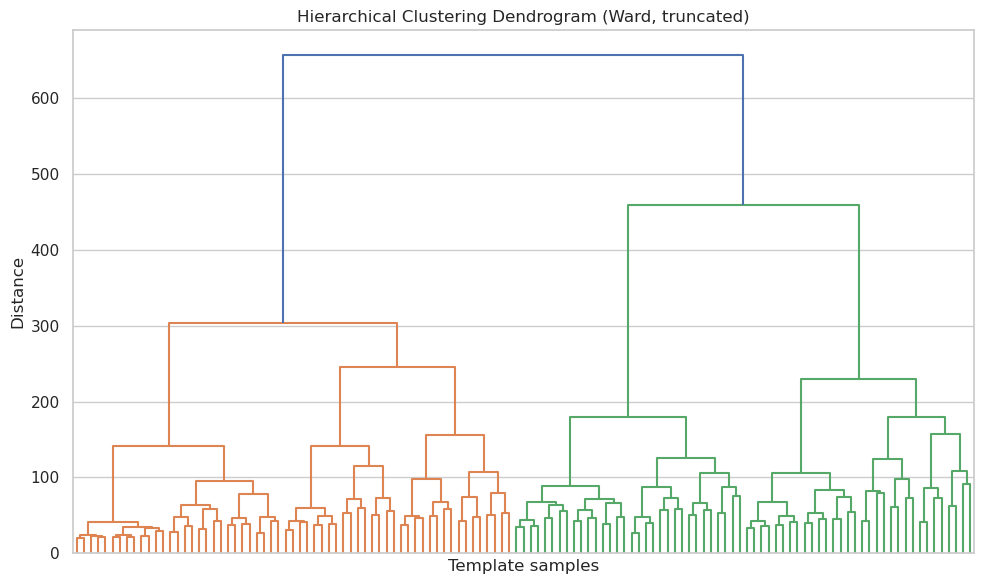

Saved Ward linkage to global_hierarchical_linkage.joblib (no fixed K).


In [30]:
# --- Ward hierarchy on standardized template features (no fixed K saved) ---
import numpy as np
from pathlib import Path
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ----------------------------
# Config / I/O
# ----------------------------
IN_DIR = Path(base + "socialmapper_outputs")
IN_DIR.mkdir(exist_ok=True, parents=True)

TEMPLATES_PATH = IN_DIR / "global_templates_features.npz"   # contains 'templates' (STANDARDIZED)
LINKAGE_PATH   = IN_DIR / "global_hierarchical_linkage.joblib"

# ----------------------------
# Load standardized templates (shape: T x n_feats)
# ----------------------------
if not TEMPLATES_PATH.exists():
    raise FileNotFoundError(
        f"Missing {TEMPLATES_PATH.name}. "
        "Make sure you ran the global t-SNE/template step that saves standardized templates."
    )
templates = np.load(TEMPLATES_PATH)["templates"]
print(f"Loaded standardized templates: {templates.shape}")

# ----------------------------
# Build Ward linkage (hierarchy)
# ----------------------------
LINKAGE_METHOD = "ward"  # Ward uses Euclidean
print("Performing hierarchical clustering (Ward) on templates...")
Z = linkage(templates, method=LINKAGE_METHOD)

# ----------------------------
# Preview dendrogram (truncated for readability)
# ----------------------------
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
dendrogram(
    Z,
    truncate_mode="level",   # show only top few levels
    p=6,                     # number of levels to display
    no_labels=True,
    color_threshold=None
)
plt.title("Hierarchical Clustering Dendrogram (Ward, truncated)")
plt.xlabel("Template samples")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# ----------------------------
# Save ONLY the hierarchy (no fixed K)
# ----------------------------
joblib.dump(
    {
        "linkage_matrix": Z,
        "method": LINKAGE_METHOD,
        # optional provenance:
        # "template_count": templates.shape[0],
        # "feature_dim": templates.shape[1],
    },
    LINKAGE_PATH
)
print(f"Saved Ward linkage to {LINKAGE_PATH.name} (no fixed K).")

## visualize results

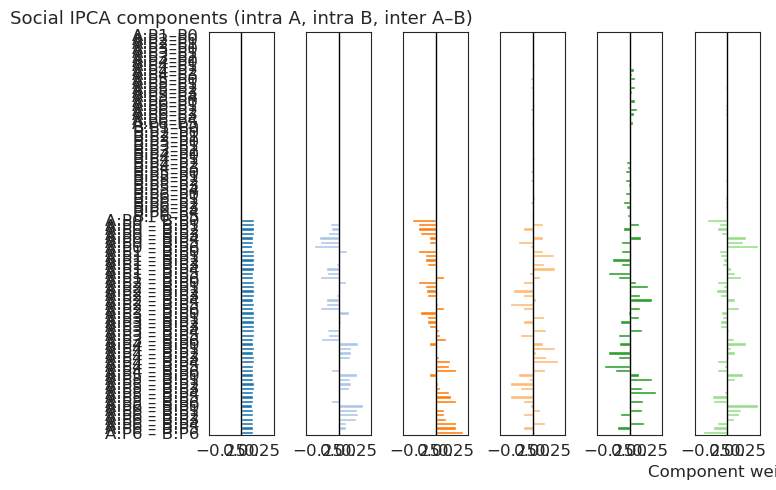

In [15]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# assumes your helper exists: pcacomponentplots(ax, vh, ylabels, colors)
BASE = Path(base + "socialmapper_outputs")

# Force mode? options: "auto", "social", "ego"
MODE = "auto"

# Optional: pose label support for social distances
POSE_N = 7
pose_point_names = [f"P{i}" for i in range(POSE_N)]

# ---------- Detect availability ----------
social_files = sorted(BASE.glob("social_projections_seq=*persp=*.npz"))
ego_pack = BASE / "ego_ipca_global.npz"  # created by the ego IPCA step

if MODE == "auto":
    if social_files:
        mode = "social"
    elif ego_pack.exists():
        mode = "ego"
    else:
        raise FileNotFoundError("No social_projections_* or ego_ipca_global.npz found.")
else:
    mode = MODE.lower()
    if mode == "social" and not social_files:
        raise FileNotFoundError("Requested MODE='social' but no social_projections_seq=* found.")
    if mode == "ego" and not ego_pack.exists():
        raise FileNotFoundError("Requested MODE='ego' but ego_ipca_global.npz not found.")

sns.set_style("white")

if mode == "social":
    # ---- Load one social file (components are global & identical across files) ----
    pnpz = np.load(social_files[0])
    vh   = pnpz["components"]          # (n_components, feat_len) — global IPCA components
    feat_len = int(pnpz["feature_len"])

    include_intra_A = bool(pnpz.get("include_intra_A", True))
    include_intra_B = bool(pnpz.get("include_intra_B", True))
    include_inter   = bool(pnpz.get("include_inter", True))
    tri_i = pnpz["tri_i"] if "tri_i" in pnpz.files else None
    tri_j = pnpz["tri_j"] if "tri_j" in pnpz.files else None

    # Build ylabels in the exact feature order used during building:
    # [intra A (lower-tri)] + [intra B (lower-tri)] + [inter A(i)-B(j) (row-major)]
    ylabels = []

    def add_intra_labels(prefix, tri_i, tri_j):
        for i, j in zip(tri_i, tri_j):
            left  = pose_point_names[i] if i < len(pose_point_names) else f"P{i}"
            right = pose_point_names[j] if j < len(pose_point_names) else f"P{j}"
            ylabels.append(f"{prefix}:{left}–{right}")

    # If intra indices not saved, synthesize for POSE_N
    if tri_i is None or tri_j is None:
        tri_i, tri_j = np.tril_indices(POSE_N, k=-1)

    if include_intra_A:
        add_intra_labels("A", tri_i, tri_j)
    if include_intra_B:
        add_intra_labels("B", tri_i, tri_j)
    if include_inter:
        for i in range(POSE_N):
            for j in range(POSE_N):
                left  = pose_point_names[i] if i < len(pose_point_names) else f"P{i}"
                right = pose_point_names[j] if j < len(pose_point_names) else f"P{j}"
                ylabels.append(f"A:{left} – B:{right}")

    # Align label count to component width
    if len(ylabels) != vh.shape[1]:
        if len(ylabels) > vh.shape[1]:
            ylabels = ylabels[:vh.shape[1]]
        else:
            ylabels += [f"feat_{k}" for k in range(len(ylabels), vh.shape[1])]

    numev_to_show = min(6, vh.shape[0])  # social used 6 PCs in paper
    fig, axes = plt.subplots(1, numev_to_show, figsize=(1.15*numev_to_show, 5),
                             sharex=True, sharey=True)
    if numev_to_show == 1:
        axes = [axes]
    palette = np.array(sns.color_palette("tab20", max(20, numev_to_show)))
    pcacomponentplots(axes, vh[:numev_to_show], ylabels=ylabels, colors=palette[:numev_to_show])
    axes[0].set_title("Social IPCA components (intra A, intra B, inter A–B)", fontsize=13)
    axes[-1].set_xlabel("Component weight", fontsize=12)
    plt.tight_layout(); plt.show()

elif mode == "ego":
    # ---- Load the global ego IPCA pack ----
    enpz = np.load(ego_pack, allow_pickle=True)
    vh = enpz["components_"]           # (n_components, n_features_ego)
    # Names saved as an object array or str array
    if "names" in enpz.files:
        names = enpz["names"]
        try:
            # if stored as object array of strings
            ego_labels = [str(x) for x in names.tolist()]
        except Exception:
            ego_labels = [str(x) for x in names]
    else:
        # fallback: generic names
        ego_labels = [f"ego_feat_{i}" for i in range(vh.shape[1])]

    # Align just in case
    if len(ego_labels) != vh.shape[1]:
        if len(ego_labels) > vh.shape[1]:
            ego_labels = ego_labels[:vh.shape[1]]
        else:
            ego_labels += [f"ego_feat_{k}" for k in range(len(ego_labels), vh.shape[1])]

    numev_to_show = min(10, vh.shape[0])
    fig, axes = plt.subplots(1, numev_to_show, figsize=(1.15*numev_to_show, 5),
                             sharex=True, sharey=True)
    if numev_to_show == 1:
        axes = [axes]
    palette = np.array(sns.color_palette("tab20", max(20, numev_to_show)))
    pcacomponentplots(axes, vh[:numev_to_show], ylabels=ego_labels, colors=palette[:numev_to_show])
    axes[0].set_title("Egocentric IPCA components", fontsize=13)
    axes[-1].set_xlabel("Component weight", fontsize=12)
    plt.tight_layout(); plt.show()

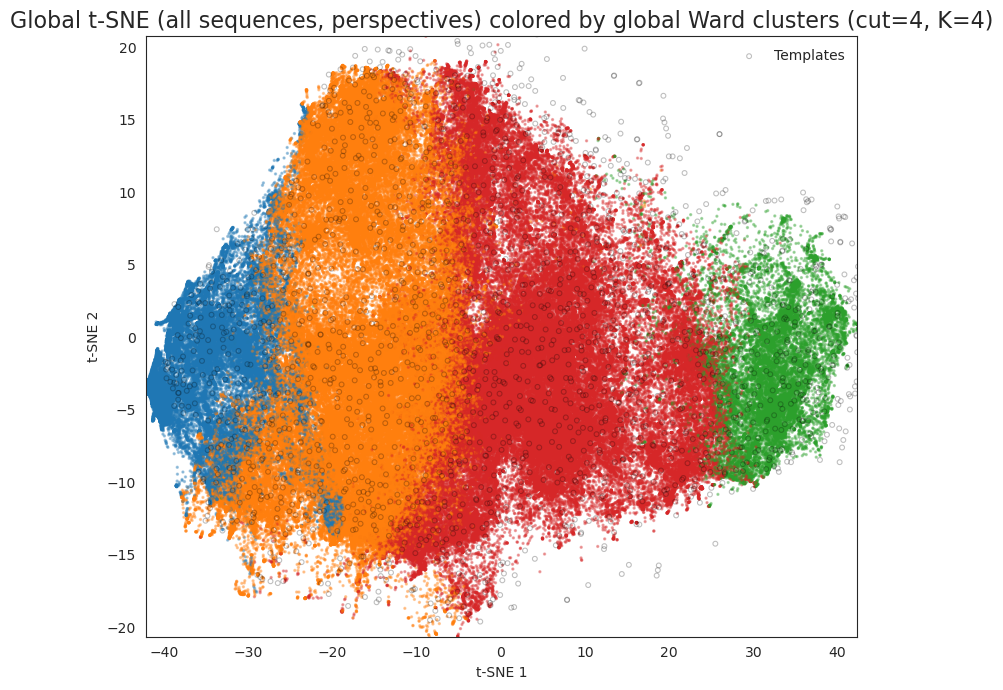

In [27]:
# --- Global t-SNE scatter colored by clustering (k-means OR Ward re-cut) ---
# Works with combined (social + ego) pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import fcluster
import joblib
import re

# ========= CONFIG =========
BASE = Path(base + "socialmapper_outputs")
CLUSTER_MODE = "ward"         # "kmeans" or "ward"
WARD_N_CLUSTERS = 4           # used only in 'ward' mode (tree cut for display)
PLOT_MAX = 300_000            # downsample for speed if needed
# ==========================

coord_files = sorted(BASE.glob("global_tsne_coords_seq=*persp=*.npz"))
if not coord_files:
    raise FileNotFoundError("Expected global_tsne_coords_seq=*persp=*.npz files.")

pat = re.compile(r"global_tsne_coords_seq=(.*)_persp=(\d+)\.npz")

# Helpers to find wavelets
def find_social_wavelet(base, safe_seq, persp):
    cands = [
        base / f"wavelet_social_seq={safe_seq}_persp={persp}.npz",
        base / f"wavelet_spectrogram_seq={safe_seq}_persp={persp}.npz",
    ]
    for p in cands:
        if p.exists():
            return p
    return None

def find_ego_wavelet(base, safe_seq, persp):
    p = base / f"wavelet_ego_seq={safe_seq}_persp={persp}.npz"
    return p if p.exists() else None

def load_combined_features(base, safe_seq, persp):
    """Return (X_combined: (T_min, D_total)), or None if neither exists."""
    ps = find_social_wavelet(base, safe_seq, persp)
    pe = find_ego_wavelet(base, safe_seq, persp)

    if ps is None and pe is None:
        return None

    parts = []
    lengths = []

    if ps is not None:
        Xs = np.load(ps)["spectrogram"].T  # (T, D_s)
        parts.append(Xs); lengths.append(Xs.shape[0])
    if pe is not None:
        Xe = np.load(pe)["spectrogram"].T  # (T, D_e)
        parts.append(Xe); lengths.append(Xe.shape[0])

    if not parts:
        return None

    T_min = min(lengths)
    parts = [p[:T_min] for p in parts]
    return np.hstack(parts)  # (T_min, D_total)

# ---- Load t-SNE coords and keys ----
Y_list, key_list = [], []
for f in coord_files:
    m = pat.match(f.name)
    if not m:
        continue
    safe_seq, persp = m.group(1), int(m.group(2))
    Y = np.load(f)["Y"]  # (n_frames_key, 2)
    Y_list.append(Y)
    key_list.append((safe_seq, persp))

Y_all = np.vstack(Y_list)

mode = CLUSTER_MODE.lower()

if mode == "kmeans":
    # unchanged: uses precomputed per-key labels
    L_list = []
    for (safe_seq, persp) in key_list:
        lab_path = BASE / f"global_kmeans_labels_seq={safe_seq}_persp={persp}.npz"
        if not lab_path.exists():
            raise FileNotFoundError(f"Missing {lab_path.name}")
        labs = np.load(lab_path)["labels"]
        if labs.min() == 1:
            labs = labs - 1
        L_list.append(labs.astype(int))
    L_all = np.concatenate(L_list)
    K = int(L_all.max()) + 1
    title_suffix = f"global k-means clusters (K={K})"

elif mode == "ward":
    # Re-cut Ward tree and assign by nearest centroid in the SAME standardized feature space
    linkage_path       = BASE / "global_hierarchical_linkage.joblib"  # must contain 'linkage_matrix'
    templates_feat_npz = BASE / "global_templates_features.npz"       # 'templates' (standardized)
    scaler_pack_path   = BASE / "global_opentsne_embedding.joblib"    # must contain 'scaler'
    if not (linkage_path.exists() and templates_feat_npz.exists() and scaler_pack_path.exists()):
        raise FileNotFoundError(
            "Ward mode needs:\n"
            f" - {linkage_path.name}\n"
            f" - {templates_feat_npz.name}\n"
            f" - {scaler_pack_path.name}"
        )

    Z = joblib.load(linkage_path)["linkage_matrix"]
    templates = np.load(templates_feat_npz)["templates"]  # (T, D_total), standardized
    labels_templates = fcluster(Z, WARD_N_CLUSTERS, criterion="maxclust")

    uniq = np.unique(labels_templates)
    centroids = np.vstack([templates[labels_templates == c].mean(axis=0) for c in uniq])
    assigner = NearestNeighbors(n_neighbors=1).fit(centroids)

    pack = joblib.load(scaler_pack_path)
    scaler = pack["scaler"]
    expected_D = scaler.n_features_in_

    # Assign each key using COMBINED (social+ego) features
    L_list = []
    for (safe_seq, persp) in key_list:
        X_comb = load_combined_features(BASE, safe_seq, persp)
        if X_comb is None:
            raise FileNotFoundError(f"No wavelet features (social/ego) found for seq={safe_seq}, persp={persp}")

        if X_comb.shape[1] != expected_D:
            raise ValueError(
                f"Feature dim mismatch for seq={safe_seq}, persp={persp}: "
                f"got {X_comb.shape[1]}, scaler expects {expected_D}. "
                f"Make sure you combined social+ego the same way as in the t-SNE step."
            )

        Xs = scaler.transform(X_comb)
        _, idx = assigner.kneighbors(Xs)
        L_list.append(idx.ravel().astype(int))

    L_all = np.concatenate(L_list)
    K = int(L_all.max()) + 1
    title_suffix = f"global Ward clusters (cut={WARD_N_CLUSTERS}, K={K})"

else:
    raise ValueError("CLUSTER_MODE must be 'kmeans' or 'ward'.")

# ---- Optional downsampling for plotting speed ----
if Y_all.shape[0] > PLOT_MAX:
    rng = np.random.default_rng(42)
    sel = rng.choice(Y_all.shape[0], size=PLOT_MAX, replace=False)
    Y_plot = Y_all[sel]
    L_plot = L_all[sel]
else:
    Y_plot = Y_all
    L_plot = L_all

# ---- Templates overlay (optional) ----
tmpl_file = BASE / "global_tsne_templates.npz"
Y_templates = np.load(tmpl_file)["Y"] if tmpl_file.exists() else None

# ---- Plot ----
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
_ = plot_tsne_withcolors(
    ax=ax,
    tsne_result=Y_plot,
    quantity=L_plot.astype(int),
    title=f"Global t-SNE (all sequences, perspectives) colored by {title_suffix}",
    colortype='categorical',
    qmin=0.01, qmax=0.99,
    alphaval=0.35,
    s=2,
    coloroffset=0,
    cmapname='cool',
    setxylimquantile=False
)
ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2")

if Y_templates is not None and Y_templates.size > 0:
    ax.scatter(Y_templates[:, 0], Y_templates[:, 1],
               s=12, facecolors='none', edgecolors='k', linewidths=0.8,
               alpha=0.25, label="Templates")
    ax.legend(frameon=False, loc="best")

plt.tight_layout()
plt.show()

### raster plot

In [20]:
# --- Raster plot over time (pair-level seq/persp), k-means / Ward / GT ---
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import fcluster
import joblib

# ========= CONFIG =========
BASE = Path(base + "socialmapper_outputs")

safe_seq = "task1-test-mouse071_task1_annotator1"   # EXACT safe name used in your saved files
persp    = 0                                        # 0 or 1

# CLUSTER_MODE can be: "kmeans", "ward", or "gt"
CLUSTER_MODE    = "ward"
WARD_N_CLUSTERS = 4

CALMS21_NPYS = [
    Path(os.path.join(datadir, "calms21_task1_train.npy")),
    Path(os.path.join(datadir, "calms21_task1_test.npy")),
]
# ==========================

# ---------- Helpers ----------
def to_raw_seq(safe_seq: str) -> str:
    # Task 3: task3-<behavior>-<split>-<rest>
    m = re.match(r"^(task3)-([^-]+)-(train|test)-(.*)$", safe_seq)
    if m:
        task, behavior, split, rest = m.groups()
        return f"{task}/{behavior}/{split}/{rest}"

    # Task 1/2: task1-<split>-<rest> or task2-<split>-<rest>
    m = re.match(r"^(task[12])-(train|test)-(.*)$", safe_seq)
    if m:
        task, split, rest = m.groups()
        return f"{task}/{split}/{rest}"

    # Fallback: replace first two '-' with '/' (keeps remaining '-' in tail)
    parts = safe_seq.split("-", 2)
    if len(parts) == 3:
        return f"{parts[0]}/{parts[1]}/{parts[2]}"
    # Last resort: single replacement
    return safe_seq.replace("-", "/", 1)

def load_gt_labels_from_many(npy_paths, raw_seq_key: str) -> np.ndarray:
    for p in npy_paths:
        if not p.exists():
            continue
        dd = np.load(p, allow_pickle=True).item()
        if not isinstance(dd, dict):
            continue
        # Flatten one level: {group: {seq_key: rec}}
        for _, seqs in dd.items():
            if not isinstance(seqs, dict):
                continue
            rec = seqs.get(raw_seq_key)

def load_pair_wavelet(base, safe_seq, persp):
    for name in (f"wavelet_social_seq={safe_seq}_persp={persp}.npz",
                 f"wavelet_spectrogram_seq={safe_seq}_persp={persp}.npz"):
        p = base / name
        if p.exists():
            return np.load(p)
    raise FileNotFoundError(f"Missing pair wavelet for seq={safe_seq}, persp={persp}")

def load_ego_wavelet(base, safe_seq, persp):
    # This assumes you saved egocentric wavelets as wavelet_ego_seq=..._persp=...
    p = base / f"wavelet_ego_seq={safe_seq}_persp={persp}.npz"
    if p.exists():
        return np.load(p)
    # If you used a different filename, adjust here.
    raise FileNotFoundError(f"Missing egocentric wavelet for seq={safe_seq}, persp={persp}")

def concat_pair_ego_features(pair_npz, ego_npz):
    X_pair = np.asarray(pair_npz["spectrogram"]).T  # (T, F_pair)
    X_ego  = np.asarray(ego_npz["spectrogram"]).T   # (T, F_ego)
    # align length
    n = min(X_pair.shape[0], X_ego.shape[0])
    return np.hstack([X_pair[:n], X_ego[:n]]), n

def fps_from_npz(npz, default=1.0):
    return float(npz["fps"]) if "fps" in npz.files else default

# ---------- Common paths ----------
linkage_path       = BASE / "global_hierarchical_linkage.joblib"
templates_feat_npz = BASE / "global_templates_features.npz"
scaler_pack_path   = BASE / "global_opentsne_embedding.joblib"
kmeans_pack_path   = BASE / "global_kmeans_assigner.joblib"

# ---------- Load features (pair + egocentric) ----------
pair_w = load_pair_wavelet(BASE, safe_seq, persp)
fps = fps_from_npz(pair_w, default=1.0)

try:
    ego_w = load_ego_wavelet(BASE, safe_seq, persp)
    X_concat, n_frames = concat_pair_ego_features(pair_w, ego_w)  # (T, F_pair+F_ego)
    print('Missing wavelets')
except FileNotFoundError as e:
    # Fall back to pair-only if ego wavelet is missing
    print(f"[WARN] {e}. Falling back to pair-only features.")
    X_pair = np.asarray(pair_w["spectrogram"]).T
    X_concat, n_frames = X_pair, X_pair.shape[0]

# ---------- Labels ----------
mode = CLUSTER_MODE.lower()
if mode == "kmeans":
    # Prefer precomputed labels that were produced on concatenated features (if you saved them)
    pre_path = BASE / f"global_kmeans_labels_seq={safe_seq}_persp={persp}.npz"
    if pre_path.exists():
        labs = np.load(pre_path)["labels"].astype(int)
        # if lengths differ due to concat truncation, align:
        if labs.shape[0] != n_frames:
            m = min(labs.shape[0], n_frames)
            labs = labs[:m]
            X_concat = X_concat[:m]
            n_frames = m
    else:
        if not kmeans_pack_path.exists():
            raise FileNotFoundError("Missing global_kmeans_assigner.joblib and no precomputed labels found.")
        pack = joblib.load(kmeans_pack_path)
        scaler = pack["scaler"]
        assigner = pack["nn"]  # NearestNeighbors over k-means centroids
        # Guard on feature count
        if getattr(scaler, "n_features_in_", None) and scaler.n_features_in_ != X_concat.shape[1]:
            raise ValueError(f"Concatenated features have {X_concat.shape[1]} dims, "
                             f"but scaler expects {scaler.n_features_in_}. "
                             f"Ensure you concatenated [pair || ego] exactly like when you fit the scaler.")
        Xs = scaler.transform(X_concat)
        _, idx = assigner.kneighbors(Xs)
        labs = idx.ravel().astype(int)
    mode_str = f"k-means (K={int(labs.max())+1})"

elif mode == "ward":
    if not (linkage_path.exists() and templates_feat_npz.exists() and scaler_pack_path.exists()):
        raise FileNotFoundError(
            "Ward mode needs:\n"
            f" - {linkage_path.name}\n - {templates_feat_npz.name}\n - {scaler_pack_path.name}"
        )
    Z = joblib.load(linkage_path)["linkage_matrix"]
    templates = np.load(templates_feat_npz)["templates"]  # standardized features used for tree
    labels_templates = fcluster(Z, WARD_N_CLUSTERS, criterion="maxclust")
    uniq = np.unique(labels_templates)
    centroids = np.vstack([templates[labels_templates == c].mean(axis=0) for c in uniq])
    assigner = NearestNeighbors(n_neighbors=1).fit(centroids)

    scaler = joblib.load(scaler_pack_path)["scaler"]
    if getattr(scaler, "n_features_in_", None) and scaler.n_features_in_ != X_concat.shape[1]:
        raise ValueError(f"Concatenated features have {X_concat.shape[1]} dims, "
                         f"but scaler expects {scaler.n_features_in_}. "
                         f"Make sure both pair AND egocentric wavelets are loaded and concatenated.")
    Xs = scaler.transform(X_concat)
    _, idx = assigner.kneighbors(Xs)
    labs = idx.ravel().astype(int)
    mode_str = f"Ward (cut={WARD_N_CLUSTERS}, K={int(labs.max())+1})"

elif mode == "gt":
    raw_seq = to_raw_seq(safe_seq)
    gt = load_gt_labels_from_many(CALMS21_NPYS, raw_seq).astype(int)
    n_use = min(n_frames, gt.shape[0])
    labs = gt[:n_use]
    n_frames = n_use
    X_concat = X_concat[:n_use]
    mode_str = "Ground truth (Task-1: attack / investigation / mount / other)"
else:
    raise ValueError("CLUSTER_MODE must be 'kmeans', 'ward', or 'gt'.")

# ---------- Normalize labels & K ----------
if labs.min() == 1:
    labs = labs - 1
K = int(labs.max()) + 1

# ---------- Raster ----------
M = np.zeros((K, n_frames), dtype=int)
for k in range(K):
    M[k, labs == k] = k + 1

Tsec = n_frames / max(fps, 1e-9)
is_gt = (mode == "gt")
yticklabels = ["attack", "investigation", "mount", "other"] if (is_gt and K == 4) else [str(k) for k in range(K)]
palette = sns.color_palette("Set2", 4) if (is_gt and K == 4) else sns.color_palette("tab20", max(20, K))[:K]
cmap = ListedColormap([(1,1,1,1)] + [tuple(c) + (1.0,) for c in palette])

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(M, aspect="auto", interpolation="nearest", cmap=cmap, vmin=0, vmax=K,
          extent=[0, Tsec, K - 0.5, -0.5])
ax.set_title(f"Raster over time — seq={safe_seq}, persp={persp} — {mode_str}")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Class" if is_gt else "Cluster ID")
ax.set_yticks(range(K))
ax.set_yticklabels(yticklabels)
plt.tight_layout()
plt.show()

Missing wavelets


FileNotFoundError: Ward mode needs:
 - global_hierarchical_linkage.joblib
 - global_templates_features.npz
 - global_opentsne_embedding.joblib

# Video - check pose on raw video

In [ ]:
# Debug overlay: step through video and draw pose points on frames
# Works in JupyterLab; uses matplotlib for display and input() for stepping.

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import clear_output, display

# -----------------------
# CONFIG
# -----------------------
video_path = '/Volumes/JD-SSD/mice_data/calms21/task1_videos_mp4/test/mouse071_task1_annotator1.mp4'
tracks_df  = df   # your DataFrame with pose + centroids
frame_col  = "frame"
id_col     = "id"

# Pose columns (7 points)
POSE_N       = 7
POSE_X_COLS  = [f"poseX{i}" for i in range(POSE_N)]
POSE_Y_COLS  = [f"poseY{i}" for i in range(POSE_N)]

# Centroid columns
CX_COL = "X#wcentroid"
CY_COL = "Y#wcentroid"

# Visualization controls
SKIP            = 50     # show every Nth frame (set 1 for frame-by-frame)
POINT_SIZE      = 30     # matplotlib scatter size
CENTROID_SIZE   = 80
ID_COLORS       = {0: 'lime', 1: 'orange'}  # color per animal id
DRAW_SKELETON   = False  # set True if you want lines between landmarks (need an order)
SKELETON_EDGES  = [(0,3),(3,4),(4,5),(5,6)]  # example chain if you enable DRAW_SKELETON

# Geometry/units
USE_CM_PER_PIXEL = False   # set True if your df coords are in *cm* and you have cm_per_pixel
CM_PER_PIXEL      = tracks_df.get('cm_per_pixel', pd.Series([1.0])).iloc[0] if 'cm_per_pixel' in tracks_df.columns else 1.0

Y_INVERT = False           # set True if df Y is bottom-origin (0=bottom) but video is top-origin (0=top)
# -----------------------

# Minimal sanity
need = [frame_col, id_col, CX_COL, CY_COL] + POSE_X_COLS + POSE_Y_COLS
missing = [c for c in need if c not in tracks_df.columns]
if missing:
    raise ValueError(f"tracks_df missing columns: {missing}")

# Keep only valid rows and cast frame to int
tdf = tracks_df[need].replace([np.inf,-np.inf], np.nan).dropna(subset=[frame_col, id_col])
tdf = tdf.copy()
tdf[frame_col] = tdf[frame_col].astype(int)
tdf[id_col]    = tdf[id_col].astype(int)

# Group by frame for fast lookup
frame_groups = tdf.groupby(frame_col)

# Open video
cap = cv2.VideoCapture(str(video_path))
if not cap.isOpened():
    raise IOError(f"Cannot open video: {video_path}")
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
N = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video: {W}x{H}, frames={N}")

def to_pixels(val):
    """Convert df coordinate to pixel coordinate if needed."""
    if USE_CM_PER_PIXEL:
        return val / CM_PER_PIXEL
    return val

def maybe_invert_y(y_pix):
    if Y_INVERT:
        return H - y_pix
    return y_pix

# Stepping loop
fidx = 0
try:
    while True:
        ret, frame_bgr = cap.read()
        if not ret:
            print("End of video.")
            break

        if fidx % SKIP != 0:
            fidx += 1
            continue

        # Convert to RGB for matplotlib
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

        # Prepare overlay for this frame
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.imshow(frame_rgb)
        ax.set_title(f"Frame {fidx}")
        ax.axis('off')

        if fidx in frame_groups.groups:
            g = frame_groups.get_group(fidx)

            for uid, g_uid in g.groupby(id_col):
                color = ID_COLORS.get(uid, 'cyan')

                # Pose points
                xs = to_pixels(g_uid[POSE_X_COLS].to_numpy().squeeze())
                ys = to_pixels(g_uid[POSE_Y_COLS].to_numpy().squeeze())
                # (handle case where group has >1 row per id due to duplicates)
                if xs.ndim == 2:  # choose first row if duplicates
                    xs = xs[0]
                    ys = ys[0]

                xs_pix = xs.astype(float)
                ys_pix = ys.astype(float)
                ys_pix = np.array([maybe_invert_y(v) for v in ys_pix])

                ax.scatter(xs_pix, ys_pix, s=POINT_SIZE, c=color, edgecolors='k', linewidths=0.5, label=f"id {uid}")

                if DRAW_SKELETON:
                    for a,b in SKELETON_EDGES:
                        ax.plot([xs_pix[a], xs_pix[b]], [ys_pix[a], ys_pix[b]], c=color, linewidth=1)

                # Centroid
                cx = to_pixels(g_uid[CX_COL].iloc[0])
                cy = to_pixels(g_uid[CY_COL].iloc[0])
                cy = maybe_invert_y(cy)
                ax.scatter([cx], [cy], s=CENTROID_SIZE, c=color, marker='x', linewidths=1.5)

                # Label near centroid
                ax.text(cx+5, cy-5, f"id {uid}", color=color, fontsize=10, weight='bold',
                        bbox=dict(facecolor='black', alpha=0.3, edgecolor='none', pad=1))

        clear_output(wait=True)
        display(fig)
        plt.close(fig)

        # Simple stepping: Enter to continue, 'q' to quit
        cmd = input("Enter=next, number=skip to frame, q=quit: ").strip().lower()
        if cmd == 'q':
            break
        elif cmd.isdigit():
            # jump to a specific frame index
            target = int(cmd)
            if 0 <= target < N:
                cap.set(cv2.CAP_PROP_POS_FRAMES, target)
                fidx = target
                continue

        fidx += 1

finally:
    cap.release()
    print("Released video.")

# Visualize - video output

### Egocentric per-ID crops 

In [ ]:
# Egocentric per-ID crops from a video, rotated by heading to +x
# Requires: pandas as pd, numpy as np, opencv-python as cv2

import os
from pathlib import Path
import numpy as np
import pandas as pd
import cv2

# -----------------------
# CONFIG
# -----------------------
# video_path    = "/Volumes/JD-SSD/ESI-mice/concat_2024-11-11.mp4"   # <- set
video_path = '/Volumes/JD-SSD/mice_data/calms21/task1_videos_mp4/test/mouse071_task1_annotator1.mp4'
tracks_df     = df                         # <- your DataFrame already loaded in memory
x_col         = "X#wcentroid"
# df['Yinv'] = 570-df['Y#wcentroid']
y_col         = "Y#wcentroid"
angle_col     = "ANGLE"
frame_col     = "frame"
id_col        = "id"

maxframenum = 10000

# Output crop size (pixels)
L, W = 200, 340                 # height (rows), width (cols) of final crop
MARGIN_FACTOR = 1.4             # pre-rotation crop = 1.4 * max(L, W)
BORDER_MODE   = cv2.BORDER_REPLICATE  # how to pad near edges: REPLICATE, CONSTANT, REFLECT, etc.

output_root   = Path(os.path.join(base,"socialmapper_outputs","egocentric_crops"))  # root dir for outputs
output_root.mkdir(parents=True, exist_ok=True)

# -----------------------
# UTILITIES
# -----------------------
def infer_angle_degrees(a_series: pd.Series) -> bool:
    """Heuristic: returns True if ANGLE looks like degrees, else radians."""
    a = a_series.to_numpy()
    a = a[np.isfinite(a)]
    if a.size == 0:
        return False
    m = np.nanmax(np.abs(a))
    # If values exceed ~2π by a safe margin, assume degrees
    return m > 7.0

def angle_to_cv2_rotation_deg(theta_deg):
    """
    OpenCV's warpAffine uses degrees, positive = counter-clockwise in image coords (y down).
    If your ANGLE is mathematical CCW from +x (y up), you typically need to negate it.
    We assume ANGLE is heading in standard math coords CCW from +x.
    To align heading to +x in output, rotate by -ANGLE (in image convention).
    """
    return -theta_deg

def safe_crop_with_padding(img, x0, y0, x1, y1, border_mode=cv2.BORDER_REPLICATE):
    """
    Crop a rectangle [y0:y1, x0:x1] from img, padding if it goes out of bounds.
    Returns an array of shape (y1-y0, x1-x0, 3).
    """
    H, W_img = img.shape[:2]
    # Desired size
    out_h = int(y1 - y0)
    out_w = int(x1 - x0)

    # Intersection with source
    sx0 = max(0, int(x0)); sy0 = max(0, int(y0))
    sx1 = min(W_img, int(x1)); sy1 = min(H, int(y1))

    # Extract intersecting part
    patch = img[sy0:sy1, sx0:sx1]

    # If exact size, return
    if (sx1 - sx0 == out_w) and (sy1 - sy0 == out_h):
        return patch

    # Need padding to reach desired size
    top    = sy0 - int(y0)
    left   = sx0 - int(x0)
    bottom = int(y1) - sy1
    right  = int(x1) - sx1

    patch_padded = cv2.copyMakeBorder(patch, top, bottom, left, right, border_mode)
    return patch_padded

# -----------------------
# PREP
# -----------------------
# Minimal columns check
for c in [x_col, y_col, angle_col, frame_col, id_col]:
    if c not in tracks_df.columns:
        raise ValueError(f"tracks_df missing required column: {c}")

# Determine if ANGLE is in degrees or radians
angle_in_degrees = infer_angle_degrees(tracks_df[angle_col])

# Build per-frame index: {frame_idx: rows_for_all_ids}
# Keep only rows with finite X,Y,ANGLE
tdf = tracks_df[[frame_col, id_col, x_col, y_col, angle_col]].copy()
tdf = tdf.replace([np.inf, -np.inf], np.nan).dropna(subset=[x_col, y_col, angle_col, frame_col, id_col])
tdf[frame_col] = tdf[frame_col].astype(int)
frame_groups = tdf.groupby(frame_col)

# Pre-crop square side
S = int(np.ceil(MARGIN_FACTOR * max(L, W)))
halfS = S // 2

# -----------------------
# PROCESS VIDEO SEQUENTIALLY
# -----------------------
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError(f"Cannot open video: {video_path}")

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Writing egocentric crops to: {output_root.resolve()}")
print(f"Final crop size: {L}x{W} (pre-rotation square: {S}x{S})")

fidx = 0
while True:
    ret, frame_bgr = cap.read()
    if not ret:
        break

    # If no tracks for this frame, skip fast
    if fidx not in frame_groups.groups:
        fidx += 1
        continue
    if np.mod(fidx,1000)==0:
        print(fidx,maxframenum)
    if fidx>=maxframenum:
        break
    rows = frame_groups.get_group(fidx)

    # Process each ID present at this frame
    for _, row in rows.iterrows():
        uid   = int(row[id_col])
        cx    = float(row[x_col])/cm_per_pixel
        cy    = float(row[y_col])/cm_per_pixel
        theta = -float(row[angle_col])

        # Convert angle -> degrees for cv2
        theta_deg = theta if angle_in_degrees else np.degrees(theta)
        rot_deg   = angle_to_cv2_rotation_deg(theta_deg)

        # 1) Pre-rotation crop (SxS) centered at centroid
        x0 = cx - halfS
        y0 = cy - halfS
        x1 = cx + halfS
        y1 = cy + halfS
        roi = safe_crop_with_padding(frame_bgr, x0, y0, x1, y1, BORDER_MODE)

        # 2) Rotate ROI around its center so heading -> +x
        center = (S / 2.0, S / 2.0)
        M = cv2.getRotationMatrix2D(center, rot_deg, 1.0)
        roi_rot = cv2.warpAffine(roi, M, (S, S), flags=cv2.INTER_LINEAR, borderMode=BORDER_MODE)

        # 3) Center-crop to final LxW
        y_center = S // 2
        x_center = S // 2
        y0f = int(y_center - L // 2)
        y1f = y0f + L
        x0f = int(x_center - W // 2)
        x1f = x0f + W

        # Because we padded the pre-crop, these indices are valid
        crop_final = roi_rot[y0f:y1f, x0f:x1f]
        if crop_final.shape[0] != L or crop_final.shape[1] != W:
            # Safety check; pad if needed due to rounding
            crop_final = cv2.copyMakeBorder(
                crop_final,
                top=max(0, L - crop_final.shape[0]),
                bottom=0,
                left=max(0, W - crop_final.shape[1]),
                right=0,
                borderType=BORDER_MODE
            )
            crop_final = crop_final[:L, :W]

        # 4) Save
        out_dir = output_root / f"id_{uid}"
        out_dir.mkdir(parents=True, exist_ok=True)
        out_path = out_dir / f"frame_{fidx:06d}.png"
        cv2.imwrite(str(out_path), crop_final)

    fidx += 1

cap.release()
print("Done.")

### composite video

In [31]:
# === Per-cluster social composites with fixed grid (each cell = fixed perspective/ID) ===
# One video per cluster, frames drawn from egocentric crops whose frames belong to that cluster
import numpy as np
import cv2
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import fcluster
import joblib
from tqdm import tqdm
import re

# ========== CONFIG ==========
BASE                = Path(base + "socialmapper_outputs")
CROPS_DIR           = BASE / "egocentric_crops"          # id_<uid>/frame_XXXXXX.png (already generated)
SEQUENCE_RAW        = "task1/test/mouse071_task1_annotator1"  # CalMS21 key for the video you’re visualizing
PERSPS              = [0, 1]                             # 0: A->B (perspective 0), 1: B->A (perspective 1)

# Map perspective -> crop ID on disk (change if your IDs differ)
PERSPECTIVE_TO_UID  = {0: 0, 1: 1}

# Grid (put perspective 0 in cell 0, perspective 1 in cell 1, others blank)
GRID_ROWS, GRID_COLS = 1, 2
GRID_POS_TO_PERSP    = [0, 1]   # length = GRID_ROWS * GRID_COLS; use None for blanks

# Clustering choice on SOCIAL features
CLUSTER_MODE        = "ward"     # "ward" or "kmeans"
WARD_N_CLUSTERS     = 12         # Ward cut level
PLOT_FPS            = 10
MAX_PAGES_PER_CLUSTER = 10_000
BG_COLOR            = (0, 0, 0)  # BGR
RANDOM_STATE        = 42
# ===========================

rng = np.random.default_rng(RANDOM_STATE)
GRID_SIZE = GRID_ROWS * GRID_COLS

def to_safe_seq(s: str) -> str:
    return s.replace("/", "-")

def read_img(p: Path):
    return cv2.imread(str(p), cv2.IMREAD_COLOR)

# --- Infer tile size from any present crop among mapped IDs ---
tile_h = tile_w = None
for p in GRID_POS_TO_PERSP:
    if p is None:
        continue
    uid = PERSPECTIVE_TO_UID.get(p, None)
    if uid is None:
        continue
    any_crop = next((q for q in (CROPS_DIR / f"id_{uid}").glob("frame_*.png")), None)
    if any_crop is not None:
        probe = read_img(any_crop)
        if probe is not None:
            tile_h, tile_w = probe.shape[:2]
            break
if tile_h is None:
    raise FileNotFoundError("Could not infer crop size: no crops found for the mapped IDs.")

# --- Build social assigner (Ward or k-means) on SOCIAL feature space ---
safe_seq = to_safe_seq(SEQUENCE_RAW)

if CLUSTER_MODE.lower() == "ward":
    linkage_path   = BASE / "global_hierarchical_linkage.joblib"
    templates_path = BASE / "global_templates_features.npz"
    scaler_pack    = BASE / "global_opentsne_embedding.joblib"
    if not (linkage_path.exists() and templates_path.exists() and scaler_pack.exists()):
        raise FileNotFoundError(
            "Missing social Ward artifacts. Expected:\n"
            f"  - {linkage_path.name}\n  - {templates_path.name}\n  - {scaler_pack.name}"
        )
    Z = joblib.load(linkage_path)["linkage_matrix"]
    templates = np.load(templates_path)["templates"]     # standardized social templates, shape (T, F_social)
    labels_templates = fcluster(Z, WARD_N_CLUSTERS, criterion="maxclust")
    uniq = np.unique(labels_templates)
    centroids = np.vstack([templates[labels_templates == c].mean(axis=0) for c in uniq])
    assigner = NearestNeighbors(n_neighbors=1).fit(centroids)
    scaler   = joblib.load(scaler_pack)["scaler"]
    mode_str = f"ward_social_nclusters={len(uniq)}"

elif CLUSTER_MODE.lower() == "kmeans":
    # Expect a social kmeans assigner saved similar to individual:
    # {"scaler": <StandardScaler>, "kmeans": <KMeans>, "nn": <NearestNeighbors on centers>}
    pack_path = BASE / "global_kmeans_assigner_social.joblib"
    if not pack_path.exists():
        raise FileNotFoundError(
            f"Missing {pack_path.name}. Train/save a k-means assigner on SOCIAL templates first."
        )
    pack     = joblib.load(pack_path)
    scaler   = pack["scaler"]
    assigner = pack["nn"]
    # Derive K from kmeans centers
    K_centers = getattr(pack.get("kmeans", None), "cluster_centers_", None)
    mode_str = f"kmeans_social_nclusters={K_centers.shape[0] if K_centers is not None else 'UNK'}"

else:
    raise ValueError("CLUSTER_MODE must be 'ward' or 'kmeans'.")

# --- Load social wavelet features for this sequence & assign clusters per perspective ---
def load_social_wavelet_frames(safe_seq: str, persp: int) -> np.ndarray:
    p = BASE / f"wavelet_social_seq={safe_seq}_persp={persp}.npz"
    if not p.exists():
        raise FileNotFoundError(f"Missing {p.name}")
    arr = np.load(p)["spectrogram"].T   # (n_frames, F_social)
    return arr

labels_per_persp = {}
n_frames_per_persp = {}
for persp in PERSPS:
    X = load_social_wavelet_frames(safe_seq, persp)
    Xs = scaler.transform(X)
    _, idx = assigner.kneighbors(Xs)
    labs = idx.ravel().astype(int)     # 0..K-1
    labels_per_persp[persp] = labs
    n_frames_per_persp[persp] = labs.shape[0]

# --- Determine K from assigned labels ---
K = max(int(labs.max()) for labs in labels_per_persp.values()) + 1

# --- Build per-cluster frame lists per perspective restricted to frames with crops on disk ---
pairs_per_cluster_per_persp = {c: {p: [] for p in PERSPS} for c in range(K)}

for persp in PERSPS:
    uid = PERSPECTIVE_TO_UID.get(persp, None)
    if uid is None:
        continue
    labs = labels_per_persp[persp]
    crop_dir = CROPS_DIR / f"id_{uid}"

    # discover available crops for this sequence: your crop filenames are just frame indices.
    # We assume frames correspond 1:1 to sequence frames.
    frame_idxs = []
    for q in crop_dir.glob("frame_*.png"):
        try:
            frame_idxs.append(int(q.stem.split("_")[-1]))
        except ValueError:
            pass
    if not frame_idxs:
        continue
    frame_idxs = np.array(sorted(frame_idxs), dtype=int)
    frame_idxs = frame_idxs[frame_idxs < len(labs)]  # guard

    # assign frames to clusters
    for fidx in frame_idxs:
        c = int(labs[fidx])
        pairs_per_cluster_per_persp[c][persp].append(fidx)

# --- Write one video per cluster; fixed grid; each cell shows its mapped perspective/ID; blanks if missing ---
out_dir = BASE / "composites_social" / f"{mode_str}__{safe_seq}"
out_dir.mkdir(parents=True, exist_ok=True)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
frame_size = (GRID_COLS * tile_w, GRID_ROWS * tile_h)

for c in range(K):
    # how many composite frames to write? as many as the longest per-perspective list
    max_len = 0
    for p in PERSPS:
        lst = pairs_per_cluster_per_persp[c].get(p, [])
        if lst is not None:
            max_len = max(max_len, len(lst))
    if max_len == 0:
        print(f"[cluster {c}] no frames; skipping.")
        continue

    video_path = out_dir / f"cluster_{c:02d}.mp4"
    writer = cv2.VideoWriter(str(video_path), fourcc, PLOT_FPS, frame_size)
    print(f"[cluster {c}] -> {video_path}")

    # per-perspective pointers
    ptr = {p: 0 for p in PERSPS}
    pages_written = 0

    while pages_written < MAX_PAGES_PER_CLUSTER:
        # stop when all perspectives exhausted
        if all(ptr[p] >= len(pairs_per_cluster_per_persp[c].get(p, [])) for p in PERSPS):
            break

        canvas = np.full((GRID_ROWS * tile_h, GRID_COLS * tile_w, 3), BG_COLOR, dtype=np.uint8)

        for cell_idx, p in enumerate(GRID_POS_TO_PERSP[:GRID_SIZE]):
            r = cell_idx // GRID_COLS
            cc = cell_idx % GRID_COLS
            y0 = r * tile_h
            x0 = cc * tile_w

            if p is None:
                # blank cell
                continue

            uid = PERSPECTIVE_TO_UID.get(p, None)
            if uid is None:
                continue

            flist = pairs_per_cluster_per_persp[c].get(p, [])
            if ptr[p] < len(flist):
                fidx = flist[ptr[p]]
                ptr[p] += 1
                img_path = CROPS_DIR / f"id_{uid}" / f"frame_{int(fidx):06d}.png"
                img = read_img(img_path)
                if img is None or img.shape[:2] != (tile_h, tile_w):
                    img = cv2.resize(img, (tile_w, tile_h), interpolation=cv2.INTER_AREA) if img is not None \
                          else np.full((tile_h, tile_w, 3), BG_COLOR, dtype=np.uint8)
                canvas[y0:y0+tile_h, x0:x0+tile_w] = img
            else:
                # this perspective ran out -> leave blank
                pass

        writer.write(canvas)
        pages_written += 1

    writer.release()
    print(f"[cluster {c}] wrote {pages_written} composite frames.")

print("All social per-cluster composites complete.")

[cluster 0] no frames; skipping.
[cluster 1] -> /Volumes/JD-SSD/mice_data/calms21/socialmapper_outputs/composites_social/ward_social_nclusters=12__task1-test-mouse071_task1_annotator1/cluster_01.mp4
[cluster 1] wrote 97 composite frames.
[cluster 2] -> /Volumes/JD-SSD/mice_data/calms21/socialmapper_outputs/composites_social/ward_social_nclusters=12__task1-test-mouse071_task1_annotator1/cluster_02.mp4
[cluster 2] wrote 447 composite frames.
[cluster 3] -> /Volumes/JD-SSD/mice_data/calms21/socialmapper_outputs/composites_social/ward_social_nclusters=12__task1-test-mouse071_task1_annotator1/cluster_03.mp4
[cluster 3] wrote 908 composite frames.
[cluster 4] -> /Volumes/JD-SSD/mice_data/calms21/socialmapper_outputs/composites_social/ward_social_nclusters=12__task1-test-mouse071_task1_annotator1/cluster_04.mp4
[cluster 4] wrote 102 composite frames.
[cluster 5] -> /Volumes/JD-SSD/mice_data/calms21/socialmapper_outputs/composites_social/ward_social_nclusters=12__task1-test-mouse071_task1_anno

# Compare predicted labels to CALMS labels

In [55]:
# Build global labels_df to compare CalMS21 GT vs predicted cluster labels (all sequences)
# Result columns: ['sequence', 'mode', 'id_or_persp', 'frame', 'gt_label', 'pred_label', 'cluster_mode']

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import fcluster
import joblib
import re
import warnings

# ================== CONFIG ==================
BASE            = Path(base + "socialmapper_outputs")

# Choose stream to compare
MODE            = "pair"         # "pair" (recommended for CalMS21 Task1) or "individual"

# CalMS21 ground-truth source (.npy produced by the converter)
CALMS21_NPY     = Path(os.path.join(datadir,"calms21_task1_test.npy"))
# If you want to include train too, run this twice and concat, or point to a merged npy.

# Clustering choice
CLUSTER_MODE    = "kmeans"         # "kmeans" or "ward"
WARD_N_CLUSTERS = 6             # only used for 'ward'

# Pair-mode: which perspectives to evaluate (0: A->B, 1: B->A)
USE_PERSPS      = [0, 1]

# Individual-mode (needs df with all sequences). We'll try to auto-detect the sequence column.
# You can force it by setting:
SEQ_COL_OVERRIDE = None  # e.g., "seq" or "sequence"
# ============================================

def to_safe_seq(seq_str: str) -> str:
    """Match your saved filenames: replace '/' with '-'."""
    return seq_str.replace("/", "-")

def to_raw_seq(safe_seq: str) -> str:
    """Recover CalMS21 key from safe filename: replace '-' back to '/'."""
    return safe_seq.replace("-", "/")

def load_all_gt(npy_path: Path) -> dict:
    """
    Returns dict: sequence_key -> (T,) int GT array.
    CalMS21 npy is a dict of groups -> dict of sequences -> dict with 'annotations'.
    """
    data = np.load(npy_path, allow_pickle=True).item()
    out = {}
    for group, seqs in data.items():
        for seq_key, seq_dict in seqs.items():
            if "annotations" in seq_dict:
                ann = np.asarray(seq_dict["annotations"])
                if ann.ndim > 1:
                    ann = ann[:, 0]
                out[seq_key] = ann.astype(int)
    return out

def load_scaler():
    return joblib.load(BASE / "global_opentsne_embedding.joblib")["scaler"]

def load_kmeans_assigner():
    # Expect: {"scaler","kmeans","nn"} saved earlier
    pack = joblib.load(BASE / "global_kmeans_assigner.joblib")
    return pack["scaler"], pack["nn"]

def load_ward_assigner(n_clusters: int):
    Z = joblib.load(BASE / "global_hierarchical_linkage.joblib")["linkage_matrix"]
    templates = np.load(BASE / "global_templates_features.npz")["templates"]  # standardized
    labels_templates = fcluster(Z, n_clusters, criterion="maxclust")
    uniq = np.unique(labels_templates)
    centroids = np.vstack([templates[labels_templates == c].mean(axis=0) for c in uniq])
    scaler = load_scaler()
    nn = NearestNeighbors(n_neighbors=1).fit(centroids)
    return scaler, nn

def find_pair_wavelet(safe_seq: str, persp: int) -> Path:
    cands = [
        BASE / f"wavelet_social_seq={safe_seq}_persp={persp}.npz",      # your social wavelet save
        BASE / f"wavelet_spectrogram_seq={safe_seq}_persp={persp}.npz", # fallback if used before
    ]
    for p in cands:
        if p.exists(): return p
    return None

def load_pair_features(safe_seq: str, persp: int) -> np.ndarray:
    npz_path = find_pair_wavelet(safe_seq, persp)
    if npz_path is None:
        raise FileNotFoundError(f"Missing pair wavelet for seq={safe_seq}, persp={persp}.")
    npz = np.load(npz_path)
    return np.asarray(npz["spectrogram"]).T  # (n_frames, n_feats)

def load_individual_features(uid: int) -> np.ndarray:
    npz = np.load(BASE / f"wavelet_spectrogram_id{uid}.npz")
    return np.asarray(npz["spectrogram"]).T  # (n_frames, 250)

# ---------- 1) Load all GT sequences ----------
GT_MAP = load_all_gt(CALMS21_NPY)  # dict seq_key -> (T,)
if not GT_MAP:
    raise RuntimeError(f"No GT sequences found in {CALMS21_NPY}")

# ---------- 2) Decide assigner ----------
mode = CLUSTER_MODE.lower()
if mode == "kmeans":
    scaler, nn_assigner = load_kmeans_assigner()
    cluster_mode_str = "kmeans"
elif mode == "ward":
    scaler, nn_assigner = load_ward_assigner(WARD_N_CLUSTERS)
    cluster_mode_str = f"ward_cut={WARD_N_CLUSTERS}"
else:
    raise ValueError("CLUSTER_MODE must be 'kmeans' or 'ward'.")

rows = []

if MODE.lower() == "pair":
    # Iterate all GT sequences; try to load both perspectives and compare
    for seq_key, gt in GT_MAP.items():
        T = gt.shape[0]
        safe_seq = to_safe_seq(seq_key)

        # skip sequences without wavelets
        have_any = False
        for p in USE_PERSPS:
            feat_path = find_pair_wavelet(safe_seq, p)
            if feat_path is None:
                continue
            have_any = True

            X = load_pair_features(safe_seq, p)   # (n_frames, n_feats)
            n = min(X.shape[0], T)
            Xs = scaler.transform(X[:n])
            _, idx = nn_assigner.kneighbors(Xs)
            pred = idx.ravel().astype(int)
            if pred.min() == 1:
                pred = pred - 1

            rows.append(pd.DataFrame({
                "sequence": seq_key,      # raw CalMS21 key with slashes
                "mode": "pair",
                "id_or_persp": p,         # store perspective here
                "frame": np.arange(n, dtype=int),
                "gt_label": gt[:n],
                "pred_label": pred[:n],
                "cluster_mode": cluster_mode_str,
            }))

        if not have_any:
            warnings.warn(f"[pair] No wavelet files found for sequence '{seq_key}' (safe='{safe_seq}') — skipping.")

elif MODE.lower() == "individual":
    # Needs df with all sequences. We will:
    #  - detect the sequence column name (SEQ_COL_OVERRIDE, or try 'seq', then 'sequence')
    #  - for each sequence, find present IDs from df, then align frames
    if 'df' not in globals():
        raise RuntimeError("MODE='individual' requires a global `df` with all sequences (columns include id, frame, and a sequence key).")

    # detect sequence column
    cand_seq_cols = [c for c in [SEQ_COL_OVERRIDE, "seq", "sequence"] if c is not None]
    seq_col = next((c for c in cand_seq_cols if c in df.columns), None)
    if seq_col is None:
        # try to sniff any column that looks like path-like CalMS21 key
        for c in df.columns:
            if df[c].astype(str).str.contains(r"task\d+/.+/.+").any():
                seq_col = c
                break
    if seq_col is None:
        raise ValueError("Could not find a sequence column in df. Set SEQ_COL_OVERRIDE to your column name (e.g., 'seq').")

    if not {"id", "frame"}.issubset(df.columns):
        raise ValueError("df must contain columns 'id' and 'frame' for individual mode.")

    # Load (or derive) per-id predictions on the fly
    # (We assign directly from features + nn_assigner to keep consistent with Ward re-cuts.)
    # Cache per-id predictions to avoid recompute
    pred_cache = {}

    for seq_key, gt in GT_MAP.items():
        sub = df[df[seq_col] == seq_key]
        if sub.empty:
            # No rows in df for this sequence, skip
            continue

        T = gt.shape[0]

        # IDs present in this sequence (from df)
        ids_in_seq = sorted(sub["id"].unique().tolist())

        for uid in ids_in_seq:
            # compute / load predictions for this id once
            if uid not in pred_cache:
                X = load_individual_features(uid)     # (n_frames_total, 250)
                Xs = scaler.transform(X)
                _, idx = nn_assigner.kneighbors(Xs)
                pred = idx.ravel().astype(int)
                if pred.min() == 1:
                    pred = pred - 1
                pred_cache[uid] = pred

            pred = pred_cache[uid]

            # frames *in this sequence* (assumes df['frame'] are 0..T-1 within each sequence)
            frames_seq = np.asarray(sorted(sub.loc[sub["id"] == uid, "frame"].unique()), dtype=int)

            # Align: keep frames < len(pred) and < T
            mask = (frames_seq >= 0) & (frames_seq < len(pred)) & (frames_seq < T)
            frames_use = frames_seq[mask]
            if frames_use.size == 0:
                continue

            rows.append(pd.DataFrame({
                "sequence": seq_key,
                "mode": "individual",
                "id_or_persp": uid,
                "frame": frames_use,
                "gt_label": gt[frames_use],
                "pred_label": pred[frames_use],
                "cluster_mode": cluster_mode_str,
            }))
else:
    raise ValueError("MODE must be 'pair' or 'individual'.")

labels_df = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(
    columns=["sequence","mode","id_or_persp","frame","gt_label","pred_label","cluster_mode"]
)

print(labels_df.head())
print("\nCounts by mode, cluster_mode:")
print(labels_df.groupby(["mode","cluster_mode"]).size())
print(f"\nlabels_df shape: {labels_df.shape}  | sequences covered: {labels_df['sequence'].nunique()}")

ValueError: X has 150 features, but StandardScaler is expecting 525 features as input.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ===================== CONFIG / FILTERS =====================
# Optional: focus on a subset (e.g., one perspective or one uid)
SUBSET_MODE = None          # e.g. "pair" or "individual" or None
SUBSET_ID_OR_PERSP = None   # e.g. 0, 1, or None
# ===========================================================

# --- Behavior name map (CalMS21 task1) ---
behavior_map = {
    0: "attack",
    1: "investigation",
    2: "mount",
    3: "other_interaction",
}
# if labels outside the map exist, keep their integer as string
labels_df["gt_behavior"] = labels_df["gt_label"].map(behavior_map).fillna(labels_df["gt_label"].astype(str))

# --- Optional subsetting ---
dfp = labels_df.copy()
if SUBSET_MODE is not None:
    dfp = dfp[dfp["mode"] == SUBSET_MODE]
if SUBSET_ID_OR_PERSP is not None:
    dfp = dfp[dfp["id_or_persp"] == SUBSET_ID_OR_PERSP]

# Guard: nothing to plot?
if dfp.empty:
    raise ValueError("No rows after applying filters; adjust SUBSET_MODE / SUBSET_ID_OR_PERSP.")

cluster_mode_str = dfp["cluster_mode"].iloc[0]

# Fix category order for GT rows (consistent display)
gt_order = [behavior_map[k] for k in sorted(behavior_map.keys()) if behavior_map[k] in dfp["gt_behavior"].unique()]
# add any unexpected/extra classes at the end
extras = [g for g in dfp["gt_behavior"].unique() if g not in gt_order]
gt_order = gt_order + sorted(extras)

# ---------- 1) GT → Predicted clusters (rows normalize to 1) ----------
cont = pd.crosstab(
    index=pd.Categorical(dfp["gt_behavior"], categories=gt_order, ordered=True),
    columns=dfp["pred_label"],
    normalize="index"
).fillna(0.0)

# Sort predicted cluster columns by the GT row they align to most (visual clarity)
peak_rows = cont.values.argmax(axis=0)              # for each cluster (col), which GT row is max
order_cols = np.lexsort((cont.values.max(axis=0), peak_rows))  # first by peak row, tie-break by height
cont = cont.iloc[:, order_cols]

plt.figure(figsize=(max(8, 0.5 * cont.shape[1]), 5))
sns.heatmap(cont, cmap="mako", vmin=0, vmax=1, cbar_kws={"label": "Proportion within GT label"},
           annot=True, fmt=".2f")
plt.title(f"GT → Predicted cluster correspondence  ({cluster_mode_str})")
plt.xlabel("Predicted cluster")
plt.ylabel("Ground-truth behavior")
plt.tight_layout()
plt.show()

# ---------- 2) Predicted clusters → GT (rows normalize to 1) ----------
cont_pred = pd.crosstab(
    index=dfp["pred_label"],
    columns=pd.Categorical(dfp["gt_behavior"], categories=gt_order, ordered=True),
    normalize="index"
).fillna(0.0)

plt.figure(figsize=(8, max(4, 0.35 * cont_pred.shape[0])))
sns.heatmap(cont_pred, cmap="mako", vmin=0, vmax=1, cbar_kws={"label": "Proportion within predicted cluster"},
           annot=True, fmt=".2f")
plt.title(f"Predicted cluster → GT correspondence  ({cluster_mode_str})")
plt.xlabel("Ground-truth behavior")
plt.ylabel("Predicted cluster")
plt.tight_layout()
plt.show()

# ---------- (Optional) show support (counts) for context ----------
gt_counts = dfp.groupby("gt_behavior").size().reindex(gt_order, fill_value=0)
pred_counts = dfp["pred_label"].value_counts().sort_index()

print("\nGT support per class:")
print(gt_counts.to_string())
print("\nPredicted cluster sizes:")
print(pred_counts.to_string())

## compare with tSNE plot

In [43]:
# --- Global t-SNE: side-by-side scatter ---
# Left: predicted clusters (k-means OR Ward re-cut on social features)
# Right: ground-truth labels (CalMS21 Task1), duplicated across perspectives
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import fcluster
import joblib, re

# ========= CONFIG =========
BASE = Path(base + "socialmapper_outputs")

# clustering shown on LEFT
CLUSTER_MODE     = "ward"      # "kmeans" or "ward"
WARD_N_CLUSTERS  = 4          # used only for 'ward' cut (display)

# ground-truth sources (it will try these in order)
CALMS21_NPYS = [
    Path("/Volumes/JD-SSD/mice_data/calms21/data/calms21_task1_train.npy"),
    Path("/Volumes/JD-SSD/mice_data/calms21/data/calms21_task1_test.npy"),
]

PLOT_MAX = 300_000            # optional downsample for speed
RANDOM_STATE = 42
# ==========================

rng = np.random.default_rng(RANDOM_STATE)
sns.set_style("white")

# ---- Helpers ----
def to_raw_seq(safe_seq: str) -> str:
    """
    Undo safe name: 'task1-test-mouse071_task1_annotator1' -> 'task1/test/mouse071_task1_annotator1'
    Assumes schema: <split>-<subset>-<filename_with_dashes_left_alone>
    """
    parts = safe_seq.split("-")
    if len(parts) < 3:
        # fallback: replace first '-' with '/', then second if present
        raw = safe_seq.replace("-", "/", 1)
        return raw.replace("-", "/", 1) if "/" in raw else raw
    return f"{parts[0]}/{parts[1]}/{'-'.join(parts[2:])}"

def find_pair_wavelet(base: Path, safe_seq: str, persp: int):
    cands = [
        base / f"wavelet_social_seq={safe_seq}_persp={persp}.npz",
        base / f"wavelet_spectrogram_seq={safe_seq}_persp={persp}.npz",
    ]
    for p in cands:
        if p.exists():
            return p
    raise FileNotFoundError(f"Missing pair-level wavelet for seq={safe_seq}, persp={persp}. "
                            f"Tried {[p.name for p in cands]}")

def to_raw_seq(safe_seq: str) -> str:
    # Task 3: task3-<behavior>-<split>-<rest>
    m = re.match(r"^(task3)-([^-]+)-(train|test)-(.*)$", safe_seq)
    if m:
        task, behavior, split, rest = m.groups()
        return f"{task}/{behavior}/{split}/{rest}"

    # Task 1/2: task1-<split>-<rest> or task2-<split>-<rest>
    m = re.match(r"^(task[12])-(train|test)-(.*)$", safe_seq)
    if m:
        task, split, rest = m.groups()
        return f"{task}/{split}/{rest}"

    # Fallback: replace first two '-' with '/' (keeps remaining '-' in tail)
    parts = safe_seq.split("-", 2)
    if len(parts) == 3:
        return f"{parts[0]}/{parts[1]}/{parts[2]}"
    # Last resort: single replacement
    return safe_seq.replace("-", "/", 1)

def load_gt_labels_from_many(npy_paths, raw_seq_key: str) -> np.ndarray:
    for p in npy_paths:
        if not p.exists():
            continue
        dd = np.load(p, allow_pickle=True).item()
        if not isinstance(dd, dict):
            continue
        # Flatten one level: {group: {seq_key: rec}}
        for _, seqs in dd.items():
            if not isinstance(seqs, dict):
                continue
            rec = seqs.get(raw_seq_key)

# ---- 1) Load global t-SNE coordinates for all (seq, persp) ----
coord_files = sorted(BASE.glob("global_tsne_coords_seq=*persp=*.npz"))
if not coord_files:
    raise FileNotFoundError("Expected global_tsne_coords_seq=*persp=*.npz files.")

pat = re.compile(r"global_tsne_coords_seq=(.*)_persp=(\d+)\.npz")

Y_blocks   = []  # list of arrays, one per (seq,persp)
pred_blocks = [] # to align later
gt_blocks   = [] # to align later
keys       = []  # (safe_seq, persp)
n_total = 0

# ---- 2) Prepare assigner for predictions (LEFT panel) ----
mode = CLUSTER_MODE.lower()
if mode == "kmeans":
    # Expect social kmeans assigner pack: {"scaler","kmeans","nn"}
    pack = joblib.load(BASE / "global_kmeans_assigner.joblib")
    scaler   = pack["scaler"]
    assigner = pack["nn"]
    left_title_suffix = "global k-means (social)"
elif mode == "ward":
    Z          = joblib.load(BASE / "global_hierarchical_linkage.joblib")["linkage_matrix"]
    templates  = np.load(BASE / "global_templates_features.npz")["templates"]
    labels_tmp = fcluster(Z, WARD_N_CLUSTERS, criterion="maxclust")
    uniq       = np.unique(labels_tmp)
    centroids  = np.vstack([templates[labels_tmp == c].mean(axis=0) for c in uniq])
    assigner   = NearestNeighbors(n_neighbors=1).fit(centroids)
    scaler     = joblib.load(BASE / "global_opentsne_embedding.joblib")["scaler"]
    left_title_suffix = f"global Ward (social), cut={WARD_N_CLUSTERS}"
else:
    raise ValueError("CLUSTER_MODE must be 'kmeans' or 'ward'.")

# ---- 3) Walk files in order; for each (seq,persp) get Y, predicted labels, and GT ----
for f in coord_files:
    m = pat.match(f.name)
    if not m:
        continue
    safe_seq, persp = m.group(1), int(m.group(2))
    Y = np.load(f)["Y"]                     # (n_frames_key, 2)
    n = Y.shape[0]

    # predicted labels from social features
    feat_npz = find_pair_wavelet(BASE, safe_seq, persp)
    X = np.load(feat_npz)["spectrogram"].T  # (n_frames, F_social)
    n_use = min(n, X.shape[0])
    Xs = scaler.transform(X[:n_use])
    _, idx = assigner.kneighbors(Xs)
    pred = idx.ravel().astype(int)          # align to n_use

    # ground truth labels for this sequence (same per perspective)
    raw_seq = to_raw_seq(safe_seq)
    gt_seq = load_gt_labels_from_many(CALMS21_NPYS, raw_seq)
    gt = gt_seq[:n_use].astype(int)

    # align Y too
    Y_blocks.append(Y[:n_use])
    pred_blocks.append(pred)
    gt_blocks.append(gt)
    keys.append((safe_seq, persp))
    n_total += n_use

# ---- 4) Concatenate and (optionally) downsample consistently ----
Y_all   = np.vstack(Y_blocks)          # (N_all, 2)
pred_all= np.concatenate(pred_blocks)  # (N_all,)
gt_all  = np.concatenate(gt_blocks)    # (N_all,)

if Y_all.shape[0] > PLOT_MAX:
    sel = rng.choice(Y_all.shape[0], size=PLOT_MAX, replace=False)
    Y_plot    = Y_all[sel]
    P_plot    = pred_all[sel]
    GT_plot   = gt_all[sel]
else:
    Y_plot, P_plot, GT_plot = Y_all, pred_all, gt_all

# ---- 5) Draw side-by-side using your helper for categorical coloring ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# Left: predictions
_ = plot_tsne_withcolors(
    ax=axes[0],
    tsne_result=Y_plot,
    quantity=P_plot.astype(int),
    title=f"Predicted clusters — {left_title_suffix}",
    colortype="categorical",
    qmin=0.01, qmax=0.99,
    alphaval=0.25,
    s=2,
    coloroffset=0,
    cmapname="cool",
    setxylimquantile=False
)
axes[0].set_xlabel("t-SNE 1"); axes[0].set_ylabel("t-SNE 2")

# Right: ground truth labels (categorical)
_ = plot_tsne_withcolors(
    ax=axes[1],
    tsne_result=Y_plot,
    quantity=GT_plot.astype(int),
    title="Ground-truth labels (CalMS21 Task1)",
    colortype="categorical",
    qmin=0.01, qmax=0.99,
    alphaval=0.25,
    s=2,
    coloroffset=0,
    cmapname="cool",
    setxylimquantile=False
)
axes[1].set_xlabel("t-SNE 1"); axes[1].set_ylabel("t-SNE 2")

plt.show()

ValueError: X has 150 features, but StandardScaler is expecting 525 features as input.

### plot on PCA axes

In [33]:
# --- Global PCA(2D): side-by-side scatter ---
# Left: predicted clusters (k-means OR Ward re-cut on social features)
# Right: CalMS21 GT labels
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import fcluster
import joblib, re

# ========= CONFIG =========
BASE = Path(base + "socialmapper_outputs")

CLUSTER_MODE     = "ward"   # "kmeans" or "ward"
WARD_N_CLUSTERS  = 4        # only used for 'ward' cut
PLOT_MAX         = 300_000  # optional downsample cap
RANDOM_STATE     = 42

CALMS21_NPYS = [
    Path("/Volumes/JD-SSD/mice_data/calms21/data/calms21_task1_train.npy"),
    Path("/Volumes/JD-SSD/mice_data/calms21/data/calms21_task1_test.npy"),
]
# ==========================

rng = np.random.default_rng(RANDOM_STATE)
sns.set_style("white")

# ---- Helpers ----
def to_raw_seq(safe_seq: str) -> str:
    parts = safe_seq.split("-")
    if len(parts) < 3:
        raw = safe_seq.replace("-", "/", 1)
        return raw.replace("-", "/", 1) if "/" in raw else raw
    return f"{parts[0]}/{parts[1]}/{'-'.join(parts[2:])}"

def find_pair_wavelet(base: Path, safe_seq: str, persp: int):
    cands = [
        base / f"wavelet_social_seq={safe_seq}_persp={persp}.npz",
        base / f"wavelet_spectrogram_seq={safe_seq}_persp={persp}.npz",
    ]
    for p in cands:
        if p.exists():
            return p
    raise FileNotFoundError(f"Missing pair-level wavelet for seq={safe_seq}, persp={persp}. "
                            f"Tried {[p.name for p in cands]}")



# ---- 0) Load standardized templates and fit PCA(2D) on them ----
templates = np.load(BASE / "global_templates_features.npz")["templates"]  # standardized (T, F)
pca2 = PCA(n_components=2, random_state=RANDOM_STATE).fit(templates)

# We'll standardize frames with the same global scaler used in your pipeline
scaler = joblib.load(BASE / "global_opentsne_embedding.joblib")["scaler"]

# ---- 1) Prepare assigner for predictions (LEFT panel) ----
mode = CLUSTER_MODE.lower()
if mode == "kmeans":
    pack     = joblib.load(BASE / "global_kmeans_assigner.joblib")  # {"scaler","kmeans","nn"}
    assigner = pack["nn"]
    left_title_suffix = "global k-means (social)"
elif mode == "ward":
    Z          = joblib.load(BASE / "global_hierarchical_linkage.joblib")["linkage_matrix"]
    labels_tmp = fcluster(Z, WARD_N_CLUSTERS, criterion="maxclust")
    uniq       = np.unique(labels_tmp)
    centroids  = np.vstack([templates[labels_tmp == c].mean(axis=0) for c in uniq])
    assigner   = NearestNeighbors(n_neighbors=1).fit(centroids)
    left_title_suffix = f"global Ward (social), cut={WARD_N_CLUSTERS}"
else:
    raise ValueError("CLUSTER_MODE must be 'kmeans' or 'ward'.")

# ---- 2) Gather PCA2 coords, predictions, and GT for all (seq, persp) ----
coord_files = sorted(BASE.glob("global_tsne_coords_seq=*persp=*.npz"))  # just to enumerate keys/lengths
if not coord_files:
    raise FileNotFoundError("Expected global_tsne_coords_seq=*persp=*.npz files.")
pat = re.compile(r"global_tsne_coords_seq=(.*)_persp=(\d+)\.npz")

PC_blocks, pred_blocks, gt_blocks = [], [], []
for f in coord_files:
    m = pat.match(f.name)
    if not m:
        continue
    safe_seq, persp = m.group(1), int(m.group(2))

    # For length reference
    n = np.load(f)["Y"].shape[0]

    # Load social features for prediction + PCA projection
    feat_npz = find_pair_wavelet(BASE, safe_seq, persp)
    X = np.load(feat_npz)["spectrogram"].T  # (n_frames, F_social)
    n_use = min(n, X.shape[0])
    Xs = scaler.transform(X[:n_use])

    # PCA(2D) coordinates (same PCA fitted on standardized templates)
    PC2 = pca2.transform(Xs)                # (n_use, 2)

    # Predicted labels
    _, idx = assigner.kneighbors(Xs)
    pred = idx.ravel().astype(int)

    # Ground-truth labels
    raw_seq = to_raw_seq(safe_seq)
    gt_seq  = load_gt_labels_from_many(CALMS21_NPYS, raw_seq)
    gt      = gt_seq[:n_use].astype(int)

    PC_blocks.append(PC2)
    pred_blocks.append(pred)
    gt_blocks.append(gt)

# ---- 3) Concatenate and downsample consistently ----
PC_all   = np.vstack(PC_blocks)          # (N_all, 2)
pred_all = np.concatenate(pred_blocks)   # (N_all,)
gt_all   = np.concatenate(gt_blocks)     # (N_all,)

if PC_all.shape[0] > PLOT_MAX:
    sel = rng.choice(PC_all.shape[0], size=PLOT_MAX, replace=False)
    PC_plot   = PC_all[sel]
    P_plot    = pred_all[sel]
    GT_plot   = gt_all[sel]
else:
    PC_plot, P_plot, GT_plot = PC_all, pred_all, gt_all

# ---- 4) Plot side-by-side (PCA1 vs PCA2) ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# LEFT: predictions
_ = plot_tsne_withcolors(
    ax=axes[0],
    tsne_result=PC_plot,     # any 2D coords are fine for this helper
    quantity=P_plot.astype(int),
    title=f"PCA(2D) — Predicted clusters — {left_title_suffix}",
    colortype='categorical',
    qmin=0.01, qmax=0.99,
    alphaval=0.25,
    s=2,
    coloroffset=0,
    cmapname='cool',
    setxylimquantile=False
)
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")

# RIGHT: ground truth
_ = plot_tsne_withcolors(
    ax=axes[1],
    tsne_result=PC_plot,
    quantity=GT_plot.astype(int),
    title="PCA(2D) — Ground-truth labels (CalMS21 Task1)",
    colortype='categorical',
    qmin=0.01, qmax=0.99,
    alphaval=0.25,
    s=2,
    coloroffset=0,
    cmapname='cool',
    setxylimquantile=False
)
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")

plt.show()

ValueError: X has 150 features, but StandardScaler is expecting 525 features as input.

# Fit classifier model on embedding

## Load dataset

In [82]:
# SIMBA-style Random Forest training on social (pair) wavelet features
# - One-vs-rest RF per behavior (Task 1 GT)
# - Grouped split by sequence (prevents leakage)
# - Class imbalance handling: Random undersampling (+ optional SMOTE)
# - Temporal context: sliding-window stats (mean/std) over wavelet features
#
# Requires: numpy, pandas, scikit-learn, imbalanced-learn, joblib
# Files expected in BASE:
#   - wavelet_social_seq=<SAFESEQ>_persp=<0|1>.npz (your 6×25=150 features per frame)
#   - global_opentsne_embedding.joblib (for scaler, optional if you want to re-use)
# CalMS21 GT .npy: task1_train/test .npy dictionaries with 'annotations'

import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import joblib
import re, os
# ==================================================

In [83]:
# ===========================
# Load & concatenate pair + egocentric WAVELET features (STRICT modern naming)
# ===========================
from pathlib import Path
import numpy as np
import re, os
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import concurrent.futures as cf
from time import perf_counter
import pandas as pd  # only used if you take the SIMBA-style branch

# ------------------------------------------------------------------------------------
# Assumptions:
#   • Pair wavelet:  wavelet_social_seq=<SAFE>_persp=<p>.npz  (required)
#   • Ego  wavelet:  wavelet_ego_seq=<SAFE>_persp=<p>.npz     (required)
#   • Key in both:   "spectrogram"  (2D array; may be (F,T) or (T,F))
#   • We ignore:     social_ego_*, ego_kinematics_*, legacy names
# ------------------------------------------------------------------------------------

# ---------- Minimal helpers ----------
def _ensure_TF(arr: np.ndarray) -> np.ndarray:
    """
    Ensure (T, F). If likely (F, T) (rows << cols), transpose.
    """
    if arr.ndim != 2:
        raise ValueError(f"Expected 2D array, got shape {arr.shape}")
    r, c = arr.shape
    return arr.T if r <= c else arr

def _fps_from_npz(npz, default=1.0):
    return float(npz["fps"]) if "fps" in npz.files else default

def _find_pair_wavelet_file(in_dir: Path, safe_seq: str, persp: int) -> Path:
    p = in_dir / f"wavelet_social_seq={safe_seq}_persp={persp}.npz"
    if not p.exists():
        raise FileNotFoundError(f"Missing pair wavelet: {p.name}")
    return p

def _find_ego_wavelet_file(in_dir: Path, safe_seq: str, persp: int) -> Path:
    p = in_dir / f"wavelet_ego_seq={safe_seq}_persp={persp}.npz"
    if not p.exists():
        raise FileNotFoundError(f"Missing ego wavelet: {p.name}")
    return p

def _load_concat_wavelet(in_dir: Path, safe_seq: str, persp: int) -> np.ndarray:
    """
    Strict: load pair + ego wavelet spectrograms and hstack (truncate to min T).
    Returns float32 (T, F_pair + F_ego).
    """
    pair_path = _find_pair_wavelet_file(in_dir, safe_seq, persp)
    ego_path  = _find_ego_wavelet_file(in_dir,  safe_seq, persp)

    with np.load(pair_path) as P:
        Xp = _ensure_TF(np.asarray(P["spectrogram"]))
    with np.load(ego_path) as E:
        Xe = _ensure_TF(np.asarray(E["spectrogram"]))

    T = min(Xp.shape[0], Xe.shape[0])
    X = np.hstack([Xp[:T], Xe[:T]]).astype(np.float32, copy=False)
    return X

def load_concat_wavelet_features(in_dir: Path, safe_seq: str, persp: int):
    """
    Returns (X_concat, fps, meta)
      X_concat: (T, F_pair + F_ego) float32
      fps:      float (from pair file if present, else 1.0)
      meta:     dict with paths/shapes/used_T
    """
    pair_path = _find_pair_wavelet_file(in_dir, safe_seq, persp)
    ego_path  = _find_ego_wavelet_file(in_dir,  safe_seq, persp)

    P = np.load(pair_path)
    E = np.load(ego_path)

    Xp = _ensure_TF(np.asarray(P["spectrogram"]))
    Xe = _ensure_TF(np.asarray(E["spectrogram"]))

    T  = min(Xp.shape[0], Xe.shape[0])
    Xc = np.hstack([Xp[:T], Xe[:T]]).astype(np.float32, copy=False)
    fps = _fps_from_npz(P, 1.0)
    meta = {
        "source": "pair+ego_strict",
        "pair_path": str(pair_path),
        "ego_path": str(ego_path),
        "pair_shape": Xp.shape,
        "ego_shape": Xe.shape,
        "concat_shape": Xc.shape,
        "used_T": T,
        "fps": float(fps),
    }
    return Xc, float(fps), meta

# ---------- tiny utility: expected stacked dimension (for sanity prints if you want) ----------
def _expected_temporal_dim(F_base: int, half: int, skip: int, pool_stats: tuple[str, ...]) -> int:
    n_steps = len(range(-half, half+1, skip))
    n_pool  = len(pool_stats) if pool_stats else 0
    return F_base * (n_steps + n_pool)

# ===== Your data-loader (parallel) — strict filenames only =====

# ---------------------------
# Temporal stacking with optional 1D Gaussian kernel
# ---------------------------
import numpy as np

def _gaussian_weights(offsets: np.ndarray, sigma: float) -> np.ndarray:
    """
    offsets: 1D array of integer frame offsets relative to the center.
    sigma:   std dev in *frames*.
    Returns normalized weights summing to 1.
    """
    if sigma is None or sigma <= 0:
        # uniform (flat) weights
        w = np.ones_like(offsets, dtype=np.float32)
    else:
        w = np.exp(-0.5 * (offsets.astype(np.float32) / float(sigma))**2)
    s = w.sum()
    return (w / s) if s > 0 else np.ones_like(offsets, dtype=np.float32) / len(offsets)

def _weighted_mean(W: np.ndarray, w: np.ndarray) -> np.ndarray:
    # W: (Twin, F); w: (Twin,)
    # returns (F,)
    return (W * w[:, None]).sum(axis=0)

def _weighted_std(W: np.ndarray, w: np.ndarray) -> np.ndarray:
    # numerically stable weighted std
    mu = _weighted_mean(W, w)
    var = (w[:, None] * (W - mu)**2).sum(axis=0)  # weights already normalized to sum 1
    return np.sqrt(np.maximum(var, 0.0))

def temporal_stack_features(
    X: np.ndarray,
    half_window: int = 16,
    skip: int = 1,
    add_pool: bool = True,
    pool_stats=("mean", "std"),
    # --- Gaussian kernel controls ---
    apply_to=("scale", "pool"),     # any of {"scale", "pool"}; use () or None for none
    sigma_stack: float = None,      # Gaussian sigma (frames) for the stacked (skip-sampled) offsets
    sigma_pool: float = None        # Gaussian sigma (frames) for the dense pooling window
):
    """
    X: (T, F) per-frame features (e.g., wavelet over PCA for social pairs)
    half_window: number of frames before/after the center
    skip: take every 'skip' frame within the *stacked* window
    add_pool: append pooled features over the full dense window
    pool_stats: which pooled stats to append ("mean","std","max","min")
    apply_to: tuple indicating where to apply Gaussian weights:
              - "scale": multiply stacked time slices by Gaussian weights before flattening
              - "pool" : use Gaussian *weighted* pooling for mean/std (max/min remain unweighted)
    sigma_stack: std dev (in frames) for the stacked offsets weighting
    sigma_pool:  std dev (in frames) for the dense pooling weighting

    Returns:
      X_stack: (N_kept,  F*(num_steps)  [+ pooled dims])
      keep_idx: (N_kept,) center indices in the original time axis
    """
    if apply_to is None:
        apply_to = tuple()
    if isinstance(apply_to, str):
        apply_to = (apply_to,)

    T, F = X.shape

    # --- Offsets for the *stacked* (skip-sampled) window ---
    offsets = np.arange(-half_window, half_window + 1, skip, dtype=int)   # e.g., [-50,-45,...,0,...,45,50]
    half_eff = offsets[-1]                                                # effective half-span considering skip

    # centers we can keep without crossing sequence boundaries
    start = max(half_window, half_eff)
    end   = min(T - half_window, T - half_eff)
    if end <= start:
        return np.empty((0, F), dtype=X.dtype), np.array([], dtype=int)

    centers = np.arange(start, end, dtype=int)           # center indices (N_kept,)
    num_steps = len(offsets)

    # --- Gaussian weights for the *stacked* offsets (for "scale") ---
    if "scale" in apply_to:
        w_stack = _gaussian_weights(offsets, sigma_stack)   # shape (num_steps,)
    else:
        w_stack = np.ones(num_steps, dtype=np.float32)

    # --- Build stacked matrix, optionally Gaussian-scaled over time ---
    X_stack = np.empty((len(centers), F * num_steps), dtype=X.dtype)
    for i, t in enumerate(centers):
        window = X[t + offsets, :]  # (num_steps, F)
        if "scale" in apply_to:
            window = (window * w_stack[:, None])            # apply temporal weights to each slice
        X_stack[i] = window.reshape(-1)

    # --- Optional pooled features over the *dense* window: [-half_window, +half_window] with step 1 ---
    if add_pool:
        dense_offsets = np.arange(-half_window, half_window + 1, dtype=int)  # every frame in the window
        if "pool" in apply_to:
            w_pool = _gaussian_weights(dense_offsets, sigma_pool)             # (2*half_window+1,)
        else:
            w_pool = None  # means "flat" pooling

        pooled = []
        for t in centers:
            W = X[t - half_window : t + half_window + 1, :]  # (Twin_dense, F)
            stats_parts = []
            for stat in pool_stats:
                if stat == "mean":
                    if w_pool is None:
                        stats_parts.append(W.mean(axis=0))
                    else:
                        stats_parts.append(_weighted_mean(W, w_pool))
                elif stat == "std":
                    if w_pool is None:
                        stats_parts.append(W.std(axis=0))
                    else:
                        stats_parts.append(_weighted_std(W, w_pool))
                elif stat == "max":
                    stats_parts.append(W.max(axis=0))   # max/min are not naturally "weighted"
                elif stat == "min":
                    stats_parts.append(W.min(axis=0))
            if stats_parts:
                stats_vec = np.concatenate(stats_parts, axis=0)
                pooled.append(stats_vec)

        if pooled:  # if we actually added any stats
            pooled = np.vstack(pooled)  # (N_kept, F * len(pool_stats))
            X_stack = np.hstack([X_stack, pooled])

    return X_stack, centers
def align_labels(y, centers):
    """Pick the center-frame label for each stacked sample."""
    return y[centers]

In [84]:
# ---------- Helpers ----------
def to_raw_seq(safe_seq: str) -> str:
    # Task 3: task3-<behavior>-<split>-<rest>
    m = re.match(r"^(task3)-([^-]+)-(train|test)-(.*)$", safe_seq)
    if m:
        task, behavior, split, rest = m.groups()
        return f"{task}/{behavior}/{split}/{rest}"

    # Task 1/2: task1-<split>-<rest> or task2-<split>-<rest>
    m = re.match(r"^(task[12])-(train|test)-(.*)$", safe_seq)
    if m:
        task, split, rest = m.groups()
        return f"{task}/{split}/{rest}"

    # Fallback: replace first two '-' with '/' (keeps remaining '-' in tail)
    parts = safe_seq.split("-", 2)
    if len(parts) == 3:
        return f"{parts[0]}/{parts[1]}/{parts[2]}"
    # Last resort: single replacement
    return safe_seq.replace("-", "/", 1)

def load_gt_labels_from_many(npy_paths, raw_seq_key: str) -> np.ndarray:
    for p in npy_paths:
        if not p.exists():
            continue
        dd = np.load(p, allow_pickle=True).item()
        if not isinstance(dd, dict):
            continue
        # Flatten one level: {group: {seq_key: rec}}
        for _, seqs in dd.items():
            if not isinstance(seqs, dict):
                continue
            rec = seqs.get(raw_seq_key)

def load_pair_wavelet(base, safe_seq, persp):
    for name in (f"wavelet_social_seq={safe_seq}_persp={persp}.npz",
                 f"wavelet_spectrogram_seq={safe_seq}_persp={persp}.npz"):
        p = base / name
        if p.exists():
            return np.load(p)
    raise FileNotFoundError(f"Missing pair wavelet for seq={safe_seq}, persp={persp}")

def load_ego_wavelet(base, safe_seq, persp):
    # This assumes you saved egocentric wavelets as wavelet_ego_seq=..._persp=...
    p = base / f"wavelet_ego_seq={safe_seq}_persp={persp}.npz"
    if p.exists():
        return np.load(p)
    # If you used a different filename, adjust here.
    raise FileNotFoundError(f"Missing egocentric wavelet for seq={safe_seq}, persp={persp}")

def concat_pair_ego_features(pair_npz, ego_npz):
    X_pair = np.asarray(pair_npz["spectrogram"]).T  # (T, F_pair)
    X_ego  = np.asarray(ego_npz["spectrogram"]).T   # (T, F_ego)
    # align length
    n = min(X_pair.shape[0], X_ego.shape[0])
    return np.hstack([X_pair[:n], X_ego[:n]]), n

def fps_from_npz(npz, default=1.0):
    return float(npz["fps"]) if "fps" in npz.files else default

### config and load

In [85]:
# === Config ===
HALF = 40
SKIP = 4
ADD_POOL = True
POOL_STATS = ("mean","std")
SIGMA_STACK = 20
SIGMA_POOL  = 25
use_temporal_stack = True
N_JOBS = 10



# ===================== CONFIG =====================
BASE = Path(base + "socialmapper_outputs")
CALMS21_NPYS = [
    Path(os.path.join(datadir,"calms21_task1_train.npy")),
    Path(os.path.join(datadir,"calms21_task1_test.npy")),
]

# temporal settings
FPS = 30.0
WIN_SEC = 0.5               # sliding window width (s) for stats
WIN = max(3, int(round(WIN_SEC * FPS)))  # frames, center=True

# imbalance settings
USE_UNDERSAMPLE = True
UNDER_SAMPLER_RATIO = 3.0   # keep majority ≈ ratio * minority in training
USE_SMOTE = False           # set True to also apply SMOTE after undersampling

# RF settings (SIMBA-style)
RF_PARAMS = dict(
    n_estimators=2000,
    criterion="entropy",
    max_features="sqrt",
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
)

# split settings
# TEST_SIZE = 0.20
RANDOM_STATE = 42

# model output dir
OUT_DIR = BASE / "rf_social_models_task1"
OUT_DIR.mkdir(parents=True, exist_ok=True)


# # --- Discover ONLY pair wavelets and infer (seq,persp) from them ---
# #     (we’ll require that the matching ego wavelet exists; otherwise we skip/error.)
# PAIR_FILES = sorted((BASE).glob("wavelet_social_seq=*persp=*.npz"))
# if not PAIR_FILES:
#     raise FileNotFoundError("No pair wavelet files found (wavelet_social_seq=*persp=*.npz).")

# # Regex aligned with the strict name
# PAIR_PAT = re.compile(r"wavelet_social_seq=(.*)_persp=(\d+)\.npz")

# def _process_one_file(pair_fpath: Path):
#     """
#     Build temporal features from concatenated (pair+ego) wavelets, align with GT.
#     Returns (X_block, y_block, g_block) or None to skip.
#     """
#     try:
#         m = PAIR_PAT.match(pair_fpath.name)
#         if not m:
#             return None
#         safe_seq, persp = m.group(1), int(m.group(2))
#         raw_seq = to_raw_seq(safe_seq)

#         # Strict: both wavelets must exist and be used
#         X_cat = _load_concat_wavelet(BASE, safe_seq, persp)  # (T, Fpair+Fego)

#         # Align with Task-1 GT
#         gt = load_gt_labels_from_many(CALMS21_NPYS, raw_seq)  # (T,)
#         n = min(X_cat.shape[0], gt.shape[0])
#         if n <= 0:
#             return None

#         if use_temporal_stack:
#             Xw, centers = temporal_stack_features(
#                 X_cat[:n],
#                 half_window=HALF,
#                 skip=SKIP,
#                 add_pool=ADD_POOL,
#                 pool_stats=POOL_STATS,
#                 apply_to=("scale", "pool"),
#                 sigma_stack=SIGMA_STACK,
#                 sigma_pool=SIGMA_POOL,
#             )
#             if Xw.shape[0] == 0:
#                 return None
#             yb = gt[centers].astype(int, copy=False)
#             gb = np.full(len(centers), raw_seq, dtype=object)
#             return (Xw.astype(np.float32, copy=False), yb, gb)
#         else:
#             # SIMBA-style (if you prefer this path)
#             Xw = sliding_stats_block(X_cat[:n], WIN).astype(np.float32, copy=False)
#             yb = gt[:n].astype(int, copy=False)
#             gb = np.full(n, raw_seq, dtype=object)
#             return (Xw, yb, gb)

#     except FileNotFoundError as e:
#         # missing ego counterpart -> skip
#         print(f"[WARN] Skipping {pair_fpath.name}: {e}")
#         return None
#     except Exception as e:
#         print(f"[WARN] Skipping {pair_fpath.name}: {e}")
#         return None

# # Run in parallel
# results = Parallel(n_jobs=N_JOBS, prefer="processes")(
#     delayed(_process_one_file)(f) for f in tqdm(PAIR_FILES, desc="Loading + stacking (STRICT pair+ego, parallel)")
# )
# results = [r for r in results if r is not None]
# if not results:
#     raise RuntimeError("No usable data produced after loading/stacking (strict pair+ego).")

# print("Making train/test data")

# # --- Sequence-level split (avoid leakage) ---
# seq_keys = np.array([gb[0] for (_, _, gb) in results], dtype=object)
# uniq_seqs = np.unique(seq_keys)

# train_seqs, test_seqs = train_test_split(uniq_seqs, test_size=TEST_SIZE, random_state=RANDOM_STATE)
# train_set, test_set = set(train_seqs), set(test_seqs)

# train_X_list, train_y_list, train_g_list = [], [], []
# test_X_list,  test_y_list,  test_g_list  = [], [], []

# for Xb, yb, gb in results:
#     key = gb[0]
#     if key in train_set:
#         train_X_list.append(np.ascontiguousarray(Xb, dtype=np.float32))
#         train_y_list.append(np.asarray(yb, dtype=np.int32))
#         train_g_list.append(np.asarray(gb, dtype=object))
#     elif key in test_set:
#         test_X_list.append(np.ascontiguousarray(Xb, dtype=np.float32))
#         test_y_list.append(np.asarray(yb, dtype=np.int32))
#         test_g_list.append(np.asarray(gb, dtype=object))

# if not train_X_list or not test_X_list:
#     raise RuntimeError("Empty train or test split after partitioning by sequence.")

# # --- Parallel stacking helpers ---
# def _sizes_and_offsets(blocks):
#     sizes = np.fromiter((b.shape[0] for b in blocks), count=len(blocks), dtype=np.int64)
#     if sizes.size == 0:
#         return sizes, sizes
#     offs = np.empty_like(sizes)
#     offs[0] = 0
#     if sizes.size > 1:
#         np.cumsum(sizes[:-1], out=offs[1:])
#     return sizes, offs

# def _parallel_copy(dstX, dsty, blocksX, blocksY, offsets, max_workers=None):
#     def _copy_one(off, Xb, yb):
#         n = Xb.shape[0]
#         dstX[off:off+n] = Xb
#         dsty[off:off+n] = yb
#     if len(blocksX) == 0:
#         return
#     with cf.ThreadPoolExecutor(max_workers=max_workers or (os.cpu_count() or 4)) as ex:
#         futures = [ex.submit(_copy_one, int(off), Xb, yb)
#                    for Xb, yb, off in zip(blocksX, blocksY, offsets)]
#         for fut in cf.as_completed(futures):
#             fut.result()

# # --- Preallocate and stack ---
# print("Stacking train/test arrays in parallel...")
# D = int(train_X_list[0].shape[1])

# train_sizes, train_offsets = _sizes_and_offsets(train_X_list)
# test_sizes,  test_offsets  = _sizes_and_offsets(test_X_list)

# train_total = int(train_sizes.sum())
# test_total  = int(test_sizes.sum())

# X_train_raw = np.empty((train_total, D), dtype=np.float32)
# y_train_mc  = np.empty((train_total,),   dtype=np.int32)
# X_test_raw  = np.empty((test_total,  D), dtype=np.float32)
# y_test_mc   = np.empty((test_total,),    dtype=np.int32)

# t0 = perf_counter()
# _parallel_copy(X_train_raw, y_train_mc, train_X_list, train_y_list, train_offsets)
# _parallel_copy(X_test_raw,  y_test_mc,  test_X_list,  test_y_list,  test_offsets)
# t1 = perf_counter()
# print(f"Parallel stack done in {t1 - t0:.2f}s "
#       f"(train={train_total:,}×{D}, test={test_total:,}×{D})")

# # Free lists earlier to reclaim RAM
# del train_X_list, train_y_list, test_X_list, test_y_list

# # --- Fast StandardScaler fit by map-reduce ---
# from concurrent.futures import ThreadPoolExecutor

# def _chunk_bounds(n_rows, chunk):
#     k = max(1, (n_rows + chunk - 1) // chunk)
#     for i in range(k):
#         a = i * chunk
#         b = min(n_rows, (i + 1) * chunk)
#         if b > a:
#             yield a, b

# def _sum_and_sumsq(X, a, b):
#     Xi = X[a:b].astype(np.float64, copy=False)
#     s  = Xi.sum(axis=0)
#     ss = np.square(Xi, dtype=np.float64).sum(axis=0)
#     n  = Xi.shape[0]
#     return n, s, ss

# CHUNK = 500_000
# bounds = list(_chunk_bounds(X_train_raw.shape[0], CHUNK))

# with ThreadPoolExecutor(max_workers=os.cpu_count() or 4) as ex:
#     parts = list(ex.map(lambda ab: _sum_and_sumsq(X_train_raw, *ab), bounds))

# n_total     = int(sum(p[0] for p in parts))
# sum_total   = np.sum([p[1] for p in parts], axis=0, dtype=np.float64)
# sumsq_total = np.sum([p[2] for p in parts], axis=0, dtype=np.float64)

# mean  = sum_total / n_total
# var   = (sumsq_total / n_total) - mean**2
# var[var < 0] = 0.0
# scale = np.sqrt(var, out=np.empty_like(var))
# scale[scale == 0] = 1.0

# scaler_global = StandardScaler(copy=True, with_mean=True, with_std=True)
# scaler_global.mean_ = mean
# scaler_global.var_ = var
# scaler_global.scale_ = scale
# scaler_global.n_samples_seen_ = np.array([n_total], dtype=np.int64)

# # Transform (vectorized)
# X_train = (X_train_raw - mean.astype(np.float32)) / scale.astype(np.float32)
# X_test  = (X_test_raw  - mean.astype(np.float32)) / scale.astype(np.float32)

# # Groups in same order as y
# groups_train = np.concatenate(train_g_list)
# groups_test  = np.concatenate(test_g_list)
# groups_all   = np.concatenate([groups_train, groups_test])

# # Free raw arrays
# del X_train_raw, X_test_raw

# print("Data ready:",
#       f"\n  X_train: {X_train.shape}, y_train_mc: {y_train_mc.shape}",
#       f"\n  X_test:  {X_test.shape},  y_test_mc:  {y_test_mc.shape}")

In [86]:
# ============================================================
# Task 1 loader that respects the official train/test split
# ============================================================
from pathlib import Path
import os, re, numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
import concurrent.futures as cf
from time import perf_counter
from sklearn.preprocessing import StandardScaler

# ---- Assumes these exist from your config / helpers ----
# BASE, CALMS21_NPYS, HALF, SKIP, ADD_POOL, POOL_STATS, SIGMA_STACK, SIGMA_POOL,
# use_temporal_stack, N_JOBS, WIN, OUT_DIR, USE_UNDERSAMPLE/SMOTE (not used here yet)
# and helper fns: to_raw_seq, _load_concat_wavelet, temporal_stack_features, sliding_stats_block

# -------------------------------
# 0) Load the official split dicts
# -------------------------------
def _load_task1_split(path: Path) -> dict:
    if not path.exists():
        raise FileNotFoundError(f"Split file not found: {path}")
    d = np.load(path, allow_pickle=True).item()
    if not isinstance(d, dict):
        raise ValueError(f"Unexpected format in {path} (expected dict)")
    return d

# Flatten dict-of-groups → {raw_seq_key: record}
def _flatten_split_dict(dsplit: dict) -> dict:
    flat = {}
    for group, seqs in dsplit.items():
        if not isinstance(seqs, dict):
            continue
        flat.update(seqs)
    return flat

# Extract the label vector (T,) for a raw_seq from one split dict
def _labels_from_split(flat: dict, raw_seq: str) -> np.ndarray | None:
    rec = flat.get(raw_seq)
    if rec is None:
        return None
    # The common key for Task 1 annotations is "annotations"
    anns = rec.get("annotations", None)
    if anns is None:
        return None
    arr = np.asarray(anns)
    if arr.ndim == 2 and arr.shape[1] >= 1:
        arr = arr[:, 0]  # first annotator if stacked
    return arr.astype(int, copy=False)

task1_train_path, task1_test_path = CALMS21_NPYS
task1_train_dict = _flatten_split_dict(_load_task1_split(task1_train_path))
task1_test_dict  = _flatten_split_dict(_load_task1_split(task1_test_path))

train_keys = set(task1_train_dict.keys())
test_keys  = set(task1_test_dict.keys())

# -------------------------------
# 1) Enumerate STRICT pair wavelets (seq,persp)
# -------------------------------
PAIR_FILES = sorted(BASE.glob("wavelet_social_seq=*task1*persp=*.npz"))
if not PAIR_FILES:
    raise FileNotFoundError("No pair wavelet files found (wavelet_social_seq=*persp=*.npz).")

PAIR_PAT = re.compile(r"wavelet_social_seq=(.*)_persp=(\d+)\.npz")

index = []
for p_pair in PAIR_FILES:
    m = PAIR_PAT.match(p_pair.name)
    if not m:
        continue
    safe_seq, persp = m.group(1), int(m.group(2))
    # require ego counterpart to exist
    p_ego = BASE / f"wavelet_ego_seq={safe_seq}_persp={persp}.npz"
    if p_ego.exists():
        index.append((safe_seq, persp))
index = sorted(set(index))
if not index:
    raise RuntimeError("No (seq,persp) pairs where both pair+ego wavelets exist.")

print(f"[INFO] Found {len(index)} (seq,persp) with strict pair+ego.")

[INFO] Found 178 (seq,persp) with strict pair+ego.


In [ ]:


# -------------------------------
# 2) Process one (seq,persp) block
# -------------------------------
def _process_one_block_task1(safe_seq: str, persp: int):
    raw_seq = to_raw_seq(safe_seq)

    # Decide split based on official lists
    split = None
    if raw_seq in train_keys and raw_seq in test_keys:
        # Very unlikely; prefer train and warn
        print(f"[WARN] {raw_seq} present in both splits; using TRAIN.")
        split = "train"
    elif raw_seq in train_keys:
        split = "train"
    elif raw_seq in test_keys:
        split = "test"
    else:
        # Not part of Task 1 splits -> skip
        return None

    # Load features (pair + ego) strict
    X = _load_concat_wavelet(BASE, safe_seq, persp)  # (T, Fpair+Fego)

    # Labels from the corresponding split only
    if split == "train":
        y_full = _labels_from_split(task1_train_dict, raw_seq)
    else:
        y_full = _labels_from_split(task1_test_dict, raw_seq)

    if y_full is None:
        # No labels for this sequence in the declared split -> skip
        return None

    n = min(X.shape[0], y_full.shape[0])
    if n <= 0:
        return None

    if use_temporal_stack:
        Xw, centers = temporal_stack_features(
            X[:n].astype(np.float32, copy=False),
            half_window=HALF,
            skip=SKIP,
            add_pool=ADD_POOL,
            pool_stats=POOL_STATS,
            apply_to=("scale", "pool"),
            sigma_stack=SIGMA_STACK,
            sigma_pool=SIGMA_POOL,
        )
        if Xw.shape[0] == 0:
            return None
        yb = y_full[centers].astype(int, copy=False)
        gb = np.full(len(centers), raw_seq, dtype=object)
        return split, Xw.astype(np.float32, copy=False), yb, gb
    else:
        Xw = sliding_stats_block(X[:n], WIN).astype(np.float32, copy=False)
        yb = y_full[:n].astype(int, copy=False)
        gb = np.full(n, raw_seq, dtype=object)
        return split, Xw, yb, gb

# -------------------------------
# 3) Parallel load into train/test buckets based on split
# -------------------------------
blocks = Parallel(n_jobs=N_JOBS, prefer="processes")(
    delayed(_process_one_block_task1)(safe_seq, persp) for (safe_seq, persp) in tqdm(index, desc="Task1: load+stack by official split")
)
blocks = [b for b in blocks if b is not None]
if not blocks:
    raise RuntimeError("No usable Task-1 blocks produced.")

train_X_list, train_y_list, train_g_list = [], [], []
test_X_list,  test_y_list,  test_g_list  = [], [], []

for split, Xb, yb, gb in blocks:
    if split == "train":
        train_X_list.append(np.ascontiguousarray(Xb, dtype=np.float32))
        train_y_list.append(np.asarray(yb, dtype=np.int32))
        train_g_list.append(np.asarray(gb, dtype=object))
    else:
        test_X_list.append(np.ascontiguousarray(Xb, dtype=np.float32))
        test_y_list.append(np.asarray(yb, dtype=np.int32))
        test_g_list.append(np.asarray(gb, dtype=object))

if not train_X_list or not test_X_list:
    raise RuntimeError("Empty train or test buckets after official-split partitioning.")

# -------------------------------
# 4) Preallocate / stack (parallel memcopies)
# -------------------------------
def _sizes_and_offsets(blocks):
    sizes = np.fromiter((b.shape[0] for b in blocks), count=len(blocks), dtype=np.int64)
    if sizes.size == 0:
        return sizes, sizes
    offs = np.empty_like(sizes)
    offs[0] = 0
    if sizes.size > 1:
        np.cumsum(sizes[:-1], out=offs[1:])
    return sizes, offs

def _parallel_copy(dstX, dsty, blocksX, blocksY, offsets, max_workers=None):
    def _copy_one(off, Xb, yb):
        n = Xb.shape[0]
        dstX[off:off+n] = Xb
        dsty[off:off+n] = yb
    if len(blocksX) == 0:
        return
    with cf.ThreadPoolExecutor(max_workers=max_workers or (os.cpu_count() or 4)) as ex:
        futures = [ex.submit(_copy_one, int(off), Xb, yb)
                   for Xb, yb, off in zip(blocksX, blocksY, offsets)]
        for fut in cf.as_completed(futures):
            fut.result()

print("Stacking train/test arrays in parallel...")
D = int(train_X_list[0].shape[1])

train_sizes, train_offsets = _sizes_and_offsets(train_X_list)
test_sizes,  test_offsets  = _sizes_and_offsets(test_X_list)

train_total = int(train_sizes.sum())
test_total  = int(test_sizes.sum())

X_train_raw = np.empty((train_total, D), dtype=np.float32)
y_train_mc  = np.empty((train_total,),   dtype=np.int32)
X_test_raw  = np.empty((test_total,  D), dtype=np.float32)
y_test_mc   = np.empty((test_total,),    dtype=np.int32)

t0 = perf_counter()
_parallel_copy(X_train_raw, y_train_mc, train_X_list, train_y_list, train_offsets)
_parallel_copy(X_test_raw,  y_test_mc,  test_X_list,  test_y_list,  test_offsets)
t1 = perf_counter()
print(f"Parallel stack done in {t1 - t0:.2f}s "
      f"(train={train_total:,}×{D}, test={test_total:,}×{D})")

# Free lists early
del train_X_list, train_y_list, test_X_list, test_y_list

# -------------------------------
# 5) Fit scaler on TRAIN ONLY, transform both
# -------------------------------
from concurrent.futures import ThreadPoolExecutor

def _chunk_bounds(n_rows, chunk):
    k = max(1, (n_rows + chunk - 1) // chunk)
    for i in range(k):
        a = i * chunk
        b = min(n_rows, (i + 1) * chunk)
        if b > a:
            yield a, b

def _sum_and_sumsq(X, a, b):
    Xi = X[a:b].astype(np.float64, copy=False)
    s  = Xi.sum(axis=0)
    ss = np.square(Xi, dtype=np.float64).sum(axis=0)
    n  = Xi.shape[0]
    return n, s, ss

CHUNK = 500_000
bounds = list(_chunk_bounds(X_train_raw.shape[0], CHUNK))

with ThreadPoolExecutor(max_workers=os.cpu_count() or 4) as ex:
    parts = list(ex.map(lambda ab: _sum_and_sumsq(X_train_raw, *ab), bounds))

n_total     = int(sum(p[0] for p in parts))
sum_total   = np.sum([p[1] for p in parts], axis=0, dtype=np.float64)
sumsq_total = np.sum([p[2] for p in parts], axis=0, dtype=np.float64)

mean  = sum_total / n_total
var   = (sumsq_total / n_total) - mean**2
var[var < 0] = 0.0
scale = np.sqrt(var, out=np.empty_like(var))
scale[scale == 0] = 1.0

scaler_global = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler_global.mean_ = mean
scaler_global.var_ = var
scaler_global.scale_ = scale
scaler_global.n_samples_seen_ = np.array([n_total], dtype=np.int64)

# Transform
X_train = (X_train_raw - mean.astype(np.float32)) / scale.astype(np.float32)
X_test  = (X_test_raw  - mean.astype(np.float32)) / scale.astype(np.float32)

# Group keys (sequence ids) in same order as y
groups_train = np.concatenate(train_g_list)
groups_test  = np.concatenate(test_g_list)
groups_all   = np.concatenate([groups_train, groups_test])

# free raw arrays
del X_train_raw, X_test_raw

print("Data ready:",
      f"\n  X_train: {X_train.shape}, y_train_mc: {y_train_mc.shape}",
      f"\n  X_test:  {X_test.shape},  y_test_mc:  {y_test_mc.shape}")

Task1: load+stack by official split:  39%|████████████████████▍                               | 70/178 [00:21<00:34,  3.09it/s]/home/jdavidson/miniforge3/envs/ecodylic/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Task1: load+stack by official split: 100%|███████████████████████████████████████████████████| 178/178 [00:45<00:00,  3.89it/s]


Stacking train/test arrays in parallel...
Parallel stack done in 55.01s (train=1,004,276×2070, test=521,174×2070)


In [50]:
print("Training set:", X_train.shape, "Testing set:", X_test.shape)
print("Feature dimension:", X_train.shape[1])
print("Unique train groups:", len(np.unique(groups_train)))
print("Unique test groups:", len(np.unique(groups_test)))
print("Class counts (train):", np.bincount(y_train_mc))
print("Class counts (test):", np.bincount(y_test_mc))

Training set: (384216, 2070) Testing set: (136958, 2070)
Feature dimension: 2070
Unique train groups: 15
Unique test groups: 4
Class counts (train): [ 18540  93808  43568 228300]
Class counts (test): [ 6608 27544 19904 82902]


### export preprocessed

In [129]:
# ===== Export dataset bundle for fast re-use =====
import json, joblib
from pathlib import Path
import numpy as np

OUT_BUNDLE = Path(base + "socialmapper_outputs") / "bundles" / "task1_social_tstack+ego"
# OUT_BUNDLE = Path('/home/jdavidson/calms21/task1_social_tstack')
OUT_BUNDLE.mkdir(parents=True, exist_ok=True)

# Save arrays in .npy for fastest reload
np.save(OUT_BUNDLE / "X_train.npy", X_train)
np.save(OUT_BUNDLE / "y_train.npy", y_train_mc)
np.save(OUT_BUNDLE / "X_test.npy",  X_test)
np.save(OUT_BUNDLE / "y_test.npy",  y_test_mc)

# Save sequence-group info (useful for grouped CV or analysis)
np.save(OUT_BUNDLE / "train_groups.npy", groups_train)
np.save(OUT_BUNDLE / "test_groups.npy",  groups_test)

# Save scaler (so new models use *exact* same normalization)
joblib.dump(scaler_global, OUT_BUNDLE / "scaler_global.joblib")

# Save metadata about how features were constructed
meta = {
    "feature_type": "social_wavelet_temporal_stack",
    "base_feats": 150,                 # per-frame base feature count; adjust if not 150
    "half": int(HALF),
    "skip": int(SKIP),
    "time_steps": len(np.arange(-HALF, HALF+1, SKIP)),
    "add_pool": bool(ADD_POOL),
    "pool_stats": list(POOL_STATS) if isinstance(POOL_STATS, (list, tuple)) else [POOL_STATS],
    "has_pool": bool(X_train.shape[1] > 150 * len(np.arange(-HALF, HALF+1, SKIP))),
    "sigma_stack": float(SIGMA_STACK),
    "sigma_pool": float(SIGMA_POOL),
    "classes": [0, 1, 2, 3],           # CalMS21 Task-1 order (you can trim if you trained subset)
    "behavior_map": {                  # update if you use a different mapping
        0: "attack",
        1: "investigation",
        2: "mount",
        3: "other",
    },
    "fps": float(FPS),
    "random_state": int(RANDOM_STATE),
    "notes": "Arrays are already standardized with scaler_global. Shapes: X_* = (N, D).",
}
with open(OUT_BUNDLE / "meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print(f"Bundle saved to: {OUT_BUNDLE.resolve()}")

Bundle saved to: /home/jdavidson/calms21/socialmapper_outputs/bundles/task1_social_tstack+ego


### Load preprocessed data for reuse

In [12]:
# ---------- Load preprocessed dataset bundle ----------
from pathlib import Path
import numpy as np
import joblib, json

# Path to the bundle directory you saved earlier
BUNDLE_DIR = Path(base + "socialmapper_outputs") / "bundles" / "task1_social_tstack"

# === Load arrays (memory-mapped, so it’s super fast and RAM-efficient) ===
X_train = np.load(BUNDLE_DIR / "X_train.npy", mmap_mode="r")
y_train_mc = np.load(BUNDLE_DIR / "y_train.npy", mmap_mode="r")
X_test = np.load(BUNDLE_DIR / "X_test.npy", mmap_mode="r")
y_test_mc = np.load(BUNDLE_DIR / "y_test.npy", mmap_mode="r")

# Optional but useful: sequence grouping info
groups_train = np.load(BUNDLE_DIR / "train_groups.npy", allow_pickle=True)
groups_test  = np.load(BUNDLE_DIR / "test_groups.npy", allow_pickle=True)

# === Load the fitted scaler ===
scaler_global = joblib.load(BUNDLE_DIR / "scaler_global.joblib")

# === Load metadata about the temporal window / features ===
with open(BUNDLE_DIR / "meta.json", "r") as f:
    meta = json.load(f)

# For convenience
HALF         = meta["half"]
SKIP         = meta["skip"]
POOL_STATS   = tuple(meta["pool_stats"])
SIGMA_STACK  = meta["sigma_stack"]
SIGMA_POOL   = meta["sigma_pool"]
ADD_POOL     = meta["add_pool"]

print("Loaded dataset bundle:")
print(f"  X_train: {X_train.shape}, y_train: {y_train_mc.shape}")
print(f"  X_test:  {X_test.shape}, y_test:  {y_test_mc.shape}")
print(f"  HALF={HALF}, SKIP={SKIP}, POOL_STATS={POOL_STATS}, ADD_POOL={ADD_POOL}")

Loaded dataset bundle:
  X_train: (384816, 4950), y_train: (384816,)
  X_test:  (137118, 4950), y_test:  (137118,)
  HALF=30, SKIP=2, POOL_STATS=('mean', 'std'), ADD_POOL=True


## Train

### Train: random forest

In [67]:
# # ---------- 3) Train one-vs-rest RF (binary per behavior) ----------
# classes = np.unique(y_all)
# models = {}
# reports = {}

# print(f"\nTraining per-behavior RFs (behaviors: {list(classes)})")
# for beh in classes:
#     y_train_bin = (y_train_mc == beh).astype(int)
#     y_test_bin  = (y_test_mc  == beh).astype(int)

#     # handle imbalance on TRAIN
#     Xt, yt = undersample_then_smote(X_train, y_train_bin)

#     clf = RandomForestClassifier(**RF_PARAMS)
#     clf.fit(Xt, yt)

#     # evaluate
#     y_pred_bin = clf.predict(X_test)
#     y_prob_bin = clf.predict_proba(X_test)[:, 1]

#     rep = classification_report(
#         y_test_bin, y_pred_bin, target_names=["not_"+str(beh), str(beh)], output_dict=True, zero_division=0
#     )
#     cm  = confusion_matrix(y_test_bin, y_pred_bin)

#     models[int(beh)] = dict(model=clf)
#     reports[int(beh)] = dict(report=rep, confusion_matrix=cm)

#     print(f"\nBehavior {beh} — test report")
#     print(classification_report(y_test_bin, y_pred_bin, target_names=["neg","pos"], zero_division=0))
#     print("Confusion matrix:\n", cm)

# # ---------- 4) Save artifacts ----------
# joblib.dump(
#     {
#         "rf_params": RF_PARAMS,
#         "models": {k: v["model"] for k, v in models.items()},
#         "scaler": scaler_global,
#         "win_frames": WIN,
#         "fps": FPS,
#         "use_undersample": USE_UNDERSAMPLE,
#         "under_sampler_ratio": UNDER_SAMPLER_RATIO,
#         "use_smote": USE_SMOTE,
#         "classes": classes,
#         "train_groups": groups_all[train_idx],
#         "test_groups": groups_all[test_idx],
#     },
#     OUT_DIR / "rf_social_task1_models.joblib"
# )

# # optional: save reports
# joblib.dump(reports, OUT_DIR / "rf_social_task1_reports.joblib")

# print(f"\nSaved models and reports to: {OUT_DIR.resolve()}")
# print("Done.")

### Train:  XGB

In [58]:
# helper: recursively convert numpy scalars/arrays/dtypes to JSON-safe python types
def to_jsonable(obj):
    if isinstance(obj, dict):
        # also coerce keys to str to avoid numpy.integer keys exploding json.dump
        return {str(k): to_jsonable(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [to_jsonable(x) for x in obj]
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    elif isinstance(obj, (np.integer,)):
        return int(obj)
    elif isinstance(obj, (np.floating,)):
        return float(obj)
    elif isinstance(obj, (np.bool_,)):
        return bool(obj)
    else:
        return obj

def undersample_then_smote(X, y):
    # 1) random undersample majority to ~ratio * minority
    if USE_UNDERSAMPLE:
        # compute target counts
        classes, counts = np.unique(y, return_counts=True)
        if len(classes) != 2:  # binary expected in per-class training
            return X, y
        maj = classes[np.argmax(counts)]
        minc = classes[np.argmin(counts)]
        n_min = counts.min()
        n_maj_target = int(round(n_min * UNDER_SAMPLER_RATIO))
        sampling_strategy = {minc: n_min, maj: min(n_maj_target, counts.max())}
        rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=RANDOM_STATE)
        X, y = rus.fit_resample(X, y)
    # 2) optional SMOTE to further balance
    if USE_SMOTE:
        sm = SMOTE(random_state=RANDOM_STATE)
        X, y = sm.fit_resample(X, y)
    return X, y

In [59]:
# === GPU XGBoost per-behavior classifiers (drop-in replacement for the RF loop & save) ===
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
import joblib
import json



# first ones I tried
XGB_PARAMS_0 = dict(
    objective="binary:logistic",
    tree_method="hist",
    device="cuda", # GPU acceleration
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    n_jobs=-1,
    random_state=123,
    eval_metric="logloss",
)

# deeper but regularized
XGB_PARAMS_1 = dict(
    objective="binary:logistic",
    device="cuda",
    tree_method="hist",
    eval_metric=["logloss","aucpr"],

    n_estimators=3000,
    learning_rate=0.03,

    max_depth=10,
    min_child_weight=8,     # regularize splits
    gamma=2.0,              # further split penalty

    subsample=0.7,
    colsample_bytree=0.6,
    colsample_bylevel=0.8,

    reg_lambda=2.0,
    reg_alpha=0.5,

    max_bin=256,            # GPU hist binning (try 256/512)
    sampling_method="gradient_based",
    n_jobs=-1,
    random_state=123,
)

# shallow trees, many estimators
XGB_PARAMS_2 = dict(
    objective="binary:logistic",
    device="cuda",
    tree_method="hist",
    eval_metric=["logloss","aucpr"],

    n_estimators=4000,
    learning_rate=0.02,

    max_depth=4,
    min_child_weight=3,
    gamma=0.0,

    subsample=0.9,
    colsample_bytree=0.9,

    reg_lambda=1.0,
    reg_alpha=0.0,

    max_bin=256,
    sampling_method="gradient_based",
    n_jobs=-1,
    random_state=123,
)

# leaf-wise growth
XGB_PARAMS_3 = dict(
    objective="binary:logistic",
    device="cuda",
    tree_method="hist",
    eval_metric=["logloss","aucpr"],

    n_estimators=3000,
    learning_rate=0.03,

    grow_policy="lossguide",
    max_depth=0,         # ignored with lossguide
    max_leaves=64,       # tune 32–256
    min_child_weight=6,
    gamma=1.0,

    subsample=0.8,
    colsample_bytree=0.8,

    reg_lambda=1.5,
    reg_alpha=0.25,

    max_bin=512,
    sampling_method="gradient_based",
    n_jobs=-1,
    random_state=123,
)

# a quick running of all and comparison gave this.  so, just use params0
# 0: 0.774
# 1: 0.769
# 2: 0.771
# 3: 0.767

In [60]:

XGB_PARAMS = XGB_PARAMS_0

callbacks=[EarlyStopping(rounds=200, save_best=True, maximize=True, metric_name="aucpr")]

    
models = {}
reports = {}
classes = [1,0,2] #np.unique(y_all)

print(f"\nTraining per-behavior XGB (GPU) classifiers (behaviors: {list(classes)})")
for beh in classes:
    y_train_bin = (y_train_mc == beh).astype(int)
    y_test_bin  = (y_test_mc  == beh).astype(int)

    # Optional: handle imbalance on TRAIN (same helper as before)
    Xt, yt = undersample_then_smote(X_train, y_train_bin)

    # scale_pos_weight from ORIGINAL train split (before any resampling)
    pos = max(1, int((y_train_bin == 1).sum()))
    neg = max(1, int((y_train_bin == 0).sum()))
    spw = float(neg) / float(pos)

    # If you performed undersampling/SMOTE, data is ~balanced -> override if desired
    if USE_UNDERSAMPLE or USE_SMOTE:
        spw = 1.0

    clf = XGBClassifier(**{**XGB_PARAMS, "scale_pos_weight": spw})

    # Fit with early stopping on the (unresampled) test split as validation (if use callbacks)
    clf.fit(
        Xt, yt,
        eval_set=[(X_test, y_test_bin)],
        verbose=False, 
        # callbacks=callbacks
    )

    # evaluate
    y_prob_bin = clf.predict_proba(X_test)[:, 1]
    y_pred_bin = (y_prob_bin >= 0.5).astype(int)

    rep = classification_report(
        y_test_bin, y_pred_bin, target_names=["not_"+str(beh), str(beh)], output_dict=True, zero_division=0
    )
    cm  = confusion_matrix(y_test_bin, y_pred_bin)
    ap  = average_precision_score(y_test_bin, y_prob_bin)

    models[int(beh)] = dict(model=clf, scale_pos_weight=spw, best_iteration=getattr(clf, "best_iteration_", None))
    reports[int(beh)] = dict(report=rep, confusion_matrix=cm, average_precision=ap)

    print(f"\nBehavior {beh} — test report")
    print(classification_report(y_test_bin, y_pred_bin, target_names=["neg","pos"], zero_division=0))
    print("Confusion matrix:\n", cm)
    print("Average Precision (AP):", f"{ap:.4f}")





# Build a lightweight, JSON-safe copy of reports
reports_json = {}
for beh, payload in reports.items():
    beh_key = str(int(beh))  # ensure string key
    rep = payload.get("report", {})
    cm  = payload.get("confusion_matrix", None)

    reports_json[beh_key] = {
        "report": to_jsonable(rep),
        "confusion_matrix": to_jsonable(cm) if cm is not None else None,
        # include AP if you stored it alongside (optional)
        "average_precision": to_jsonable(payload.get("average_precision")) if "average_precision" in payload else None,
    }

# Also create a small CSV summary per behavior (precision/recall/f1 for pos class + AP if present)
summary_rows = []
for beh, payload in reports.items():
    beh_int = int(beh)
    rep = payload['report']
    # scikit's output_dict uses class labels '0'/'1' when target_names provided -> 'neg'/'pos'
    # we'll try both
    pos_key = str(beh_int)
    prec = rep.get(pos_key, {}).get("precision", np.nan)
    rec  = rep.get(pos_key, {}).get("recall", np.nan)
    f1   = rep.get(pos_key, {}).get("f1-score", np.nan)
    support = rep.get(pos_key, {}).get("support", np.nan)
    ap   = payload.get("average_precision", np.nan)
    summary_rows.append({
        "behavior": beh_int,
        "precision_pos": float(prec),
        "recall_pos": float(rec),
        "f1_pos": float(f1),
        "support_pos": int(support) if np.isfinite(support) else None,
        "average_precision": float(ap) if ap is not None and np.isfinite(ap) else None,
    })
summary_df = pd.DataFrame(summary_rows).sort_values("behavior")
summary_csv_path = OUT_DIR / "xgb_social_task1_summary.csv"
summary_df.to_csv(summary_csv_path, index=False)

# Save models + metadata with joblib (no JSON conversion needed)
joblib.dump(
    {
        "xgb_params": XGB_PARAMS,
        "models": {int(k): v["model"] for k, v in models.items()},
        "model_meta": {
            int(k): {
                "scale_pos_weight": v.get("scale_pos_weight"),
                "best_iteration": v.get("best_iteration"),
            }
            for k, v in models.items()
        },
        "scaler": scaler_global,
        "win_frames": WIN,
        "fps": FPS,
        "use_undersample": USE_UNDERSAMPLE,
        "under_sampler_ratio": UNDER_SAMPLER_RATIO,
        "use_smote": USE_SMOTE,
        "classes": [int(c) for c in classes],
        "train_groups": groups_train,  # fine in joblib
        "test_groups": groups_test,    # fine in joblib
    },
    OUT_DIR / "xgb_social_task1_models.joblib"
)

# Save full reports as joblib (rich Python), and a JSON for quick glance
joblib.dump(reports, OUT_DIR / "xgb_social_task1_reports.joblib")

with open(OUT_DIR / "xgb_social_task1_reports.json", "w") as f:
    json.dump(reports_json, f, indent=2)

print(f"\nSaved models and reports to: {OUT_DIR.resolve()}")
print(f"Summary CSV: {summary_csv_path}")
print("Done.")


Training per-behavior XGB (GPU) classifiers (behaviors: [1, 0, 2])


Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x77b8e3410720>
Traceback (most recent call last):
  File "/home/jdavidson/miniforge3/envs/ecodylic/lib/python3.11/_weakrefset.py", line 39, in _remove
    def _remove(item, selfref=ref(self)):

KeyboardInterrupt: 

KeyboardInterrupt



In [21]:
summary_df

,behavior,precision_pos,recall_pos,f1_pos,support_pos,average_precision
0,0,0.770420,0.957778,0.853943,6608,0.903557
1,1,0.715379,0.695433,0.705265,27544,0.778584
2,2,0.947881,0.894544,0.920440,19904,0.980588


### Train: Multi-label TCN

In [54]:
# ===============================================
# Multi-label TCN for CalMS21 Task 1 (single model)
# - Input: your stacked arrays X_train, y_train_mc, X_test, y_test_mc
# - Output: per-behavior logits (sigmoid) with per-behavior thresholds
# ===============================================
import os, math, time, json
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

# -----------------------
# Config (edit as needed)
# -----------------------
SAVE_DIR = Path(base + "socialmapper_outputs") / "tcn_models"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 123
BATCH_SIZE = 4096*2
EPOCHS = 25
PATIENCE = 5                # early stopping on macro-F1 (val)
LR = 3e-4
WEIGHT_DECAY = 1e-4
DROPOUT = 0.1
WIDTH = 128                 # hidden channels in TCN
KERNEL_SIZE = 5             # 1D conv kernel
DILATIONS = [1, 2, 4, 8, 16]
PRINT_FRAC = 0.1            # print ~every 10% of an epoch
VAL_FRAC = 0.1              # take 10% of TRAIN for threshold tuning/early stopping

# Behaviors present in Task 1 labels (adjust if needed)
BEHAVIORS = [0, 1, 2, 3]
N_BEH = len(BEHAVIORS)

# -----------------------
# Repro + perf tweaks
# -----------------------
rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
if DEVICE == "cuda":
    torch.backends.cudnn.benchmark = True

# -------------------------------------------------
# Build multi-label targets from your multiclass y
# (If Task 1 is truly mutually-exclusive, this still works;
#  it just makes at most one "1" per row.)
# -------------------------------------------------
def to_multi_hot(y_mc: np.ndarray, behaviors=BEHAVIORS) -> np.ndarray:
    Y = np.zeros((y_mc.shape[0], len(behaviors)), dtype=np.float32)
    for j, b in enumerate(behaviors):
        Y[:, j] = (y_mc == b).astype(np.float32)
    return Y

Y_train = to_multi_hot(y_train_mc, BEHAVIORS)
Y_test  = to_multi_hot(y_test_mc,  BEHAVIORS)

# -------------------------------------------------
# Infer temporal stack shape from your current globals
# HALF, SKIP, ADD_POOL, POOL_STATS must reflect how X_* were built
# -------------------------------------------------
try:
    HALF, SKIP, ADD_POOL, POOL_STATS
except NameError:
    HALF, SKIP, ADD_POOL, POOL_STATS = 16, 2, True, ("mean", "std")

time_steps = len(np.arange(-HALF, HALF + 1, SKIP))
feat_total = X_train.shape[1]
# infer BASE_FEATS from (temporal + pooled)
# pooled_dim is a multiple of BASE_FEATS
def infer_base_feats(feat_total, time_steps):
    # Try all divisors to find a consistent base_feats
    for base in range(1, 8192):
        pooled_dim = feat_total - base * time_steps
        if pooled_dim < 0: break
        if not ADD_POOL and pooled_dim == 0:
            return base, 0, False
        if ADD_POOL and pooled_dim % base == 0:
            return base, pooled_dim, True
    raise ValueError(f"Cannot infer BASE_FEATS from feat_total={feat_total}, time_steps={time_steps}")

BASE_FEATS, pooled_dim, has_pool = infer_base_feats(feat_total, time_steps)
in_channels = BASE_FEATS * (1 + (pooled_dim // BASE_FEATS if has_pool else 0))

# -------------------------------------------------
# Dataset that reshapes flattened stacks -> (C,T); targets are multi-hot (N_BEH,)
# -------------------------------------------------
class StackedMultiLabelDataset(Dataset):
    def __init__(self, X_flat: np.ndarray, Y: np.ndarray):
        self.X = X_flat.astype(np.float32, copy=False)
        self.Y = Y.astype(np.float32,   copy=False)

    def __len__(self):
        return self.Y.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]
        # temporal part -> (F, T)
        temporal_flat_dim = BASE_FEATS * time_steps
        x_temporal = x[:temporal_flat_dim].reshape(time_steps, BASE_FEATS).T  # (F, T)

        if has_pool and pooled_dim > 0:
            n_stats = pooled_dim // BASE_FEATS
            off = temporal_flat_dim
            pooled_ch = []
            for _ in range(n_stats):
                chan = x[off:off+BASE_FEATS]               # (F,)
                pooled_ch.append(np.tile(chan[:, None], (1, time_steps)))
                off += BASE_FEATS
            x_full = np.concatenate([x_temporal] + pooled_ch, axis=0)  # (F*(1+n_stats), T)
        else:
            x_full = x_temporal

        return torch.from_numpy(x_full), torch.from_numpy(self.Y[idx])

# -----------------------
# Split a validation part from TRAIN (for early stop + thr tuning)
# -----------------------
idx = np.arange(X_train.shape[0])
idx_tr, idx_val = train_test_split(idx, test_size=VAL_FRAC, random_state=SEED, shuffle=True)
train_ds = StackedMultiLabelDataset(X_train[idx_tr], Y_train[idx_tr])
val_ds   = StackedMultiLabelDataset(X_train[idx_val], Y_train[idx_val])
test_ds  = StackedMultiLabelDataset(X_test,          Y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# -----------------------
# TCN blocks (residual)
# -----------------------
class Chomp1d(nn.Module):
    def __init__(self, chomp_size): super().__init__(); self.chomp_size = chomp_size
    def forward(self, x): return x[..., :-self.chomp_size] if self.chomp_size > 0 else x

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation, dropout):
        super().__init__()
        pad = (kernel_size - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size, padding=pad, dilation=dilation),
            Chomp1d(pad), nn.GELU(), nn.Dropout(dropout),
            nn.Conv1d(out_ch, out_ch, kernel_size, padding=pad, dilation=dilation),
            Chomp1d(pad), nn.GELU(), nn.Dropout(dropout),
        )
        self.down = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    def forward(self, x): return self.net(x) + self.down(x)

class MultiLabelTCN(nn.Module):
    def __init__(self, in_ch, n_beh, widths=WIDTH, ks=KERNEL_SIZE, dilations=DILATIONS, dropout=DROPOUT):
        super().__init__()
        chs = [in_ch] + [widths] * len(dilations)
        self.tcn = nn.Sequential(*[
            TemporalBlock(chs[i], chs[i+1], ks, d, dropout) for i, d in enumerate(dilations)
        ])
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1), nn.Flatten(),
            nn.Linear(widths, widths), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(widths, n_beh)  # logits for each behavior
        )
    def forward(self, x):  # x: (B, C, T)
        z = self.tcn(x)
        logits = self.head(z)  # (B, n_beh)
        return logits

model = MultiLabelTCN(in_channels, N_BEH).to(DEVICE)

# -----------------------
# Weighted BCE (pos_weight per behavior from TRAIN set)
# pos_weight = (#neg / #pos) per behavior
# -----------------------
pos_counts = Y_train[idx_tr].sum(axis=0) + 1e-6
neg_counts = (Y_train[idx_tr].shape[0] - Y_train[idx_tr].sum(axis=0)) + 1e-6
pos_weight_vec = torch.tensor(neg_counts / pos_counts, dtype=torch.float32, device=DEVICE)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_vec)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = GradScaler(enabled=(DEVICE == "cuda"))

# Cosine over steps
total_steps = EPOCHS * max(1, math.ceil(len(train_loader)))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=total_steps)

# -----------------------
# Train / Val loops with early stopping on macro-F1 (val, threshold=0.5 during training)
# -----------------------
def run_epoch(loader, train=True, epoch_idx=1, phase="train"):
    model.train(mode=train)
    t0 = time.time()
    total_loss, seen = 0.0, 0
    preds, targs = [], []

    num_batches = len(loader)
    print_every = max(1, int(num_batches * PRINT_FRAC))

    for bi, (xb, yb) in enumerate(loader, 1):
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)
        bs = xb.size(0)

        if train:
            opt.zero_grad(set_to_none=True)
            with autocast(enabled=(DEVICE == "cuda")):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            scheduler.step()
        else:
            with torch.no_grad(), autocast(enabled=(DEVICE == "cuda")):
                logits = model(xb)
                loss = criterion(logits, yb)

        total_loss += loss.item() * bs
        preds.append(torch.sigmoid(logits).detach().cpu().numpy())
        targs.append(yb.detach().cpu().numpy())
        seen += bs

        if (bi % print_every == 0) or (bi == num_batches):
            elapsed = time.time() - t0
            it_per_sec = bi / max(1e-6, elapsed)
            eta = (num_batches - bi) / max(1e-6, it_per_sec)
            print(f"[{phase}] epoch {epoch_idx:02d} {bi:>4d}/{num_batches:<4d} "
                  f"loss={total_loss/seen:.4f}  {it_per_sec:.2f} it/s | ETA {eta/60:.1f} min")

    avg_loss = total_loss / len(loader.dataset)
    P = np.concatenate(preds, axis=0)  # probs
    Y = np.concatenate(targs, axis=0)
    # temporary fixed-threshold macro-F1 for early stopping signal
    Yhat = (P >= 0.5).astype(int)
    macro_f1 = f1_score(Y, Yhat, average="macro", zero_division=0)
    return avg_loss, macro_f1, P, Y

best_val_f1, pat_left = -1.0, PATIENCE
best_path = SAVE_DIR / "tcn_task1_multilabel_best.pt"

print(f"Training multi-label TCN on {DEVICE} | in_ch={in_channels}, T={time_steps}, behaviors={BEHAVIORS}")
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_f1, _, _ = run_epoch(train_loader, train=True,  epoch_idx=epoch, phase="train")
    va_loss, va_f1, P_val, Y_val = run_epoch(val_loader,   train=False, epoch_idx=epoch, phase="val")
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} | train F1 {tr_f1:.4f} | val loss {va_loss:.4f} | val F1 {va_f1:.4f}")

    if va_f1 > best_val_f1 + 1e-4:
        best_val_f1 = va_f1
        pat_left = PATIENCE
        torch.save({
            "model": model.state_dict(),
            "in_channels": in_channels,
            "time_steps": time_steps,
            "behaviors": BEHAVIORS,
            "base_feats": BASE_FEATS,
            "has_pool": has_pool,
            "pooled_dim": pooled_dim
        }, best_path)
    else:
        pat_left -= 1
        if pat_left <= 0:
            print("Early stopping.")
            break

# -----------------------
# Load best & tune thresholds on VAL (per behavior, maximize F1)
# -----------------------
ckpt = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

def collect_probs(loader):
    all_p, all_y = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE, non_blocking=True)
            with autocast(enabled=(DEVICE == "cuda")):
                lg = model(xb)
            all_p.append(torch.sigmoid(lg).cpu().numpy())
            all_y.append(yb.numpy())
    return np.vstack(all_p), np.vstack(all_y)

P_val, Y_val = collect_probs(val_loader)

def tune_thresholds(P, Y):
    thr = np.zeros(N_BEH, dtype=np.float32)
    for j in range(N_BEH):
        # use PR curve to select threshold that maximizes F1
        prec, rec, t = precision_recall_curve(Y[:, j], P[:, j])
        # PR returns thresholds for all but first point; align F1 to thresholds
        f1 = (2 * prec * rec) / np.maximum(prec + rec, 1e-9)
        if t.size == 0:
            thr[j] = 0.5
        else:
            # drop first F1 that doesn't correspond to a threshold
            best_idx = np.nanargmax(f1[1:]) if f1.size > 1 else 0
            thr[j] = float(t[best_idx]) if best_idx < t.size else 0.5
    return thr

thr_val = tune_thresholds(P_val, Y_val)
thr_map = {int(b): float(t) for b, t in zip(BEHAVIORS, thr_val)}
print("Per-behavior tuned thresholds (val):", thr_map)

# -----------------------
# Final evaluation on TEST with tuned thresholds
# -----------------------
P_test, Y_test_bin = collect_probs(test_loader)
Yhat_test = (P_test >= thr_val[None, :]).astype(int)

# Per-behavior reports
per_class = {}
APs = []
for j, b in enumerate(BEHAVIORS):
    ap = average_precision_score(Y_test_bin[:, j], P_test[:, j])
    APs.append(ap)
    rep = classification_report(Y_test_bin[:, j], Yhat_test[:, j], target_names=[f"not_{b}", f"{b}"], output_dict=True, zero_division=0)
    per_class[int(b)] = {
        "threshold": float(thr_val[j]),
        "average_precision": float(ap),
        "report": rep
    }
    print(f"\n=== Behavior {b} (TEST) ===")
    print(classification_report(Y_test_bin[:, j], Yhat_test[:, j], target_names=[f"not_{b}", f"{b}"], digits=3, zero_division=0))
    print(f"AP: {ap:.4f}")

macro_f1 = f1_score(Y_test_bin, Yhat_test, average="macro", zero_division=0)
macro_ap = float(np.mean(APs))
print(f"\n=== Multi-label TEST summary ===\nMacro F1={macro_f1:.4f} | Macro AP={macro_ap:.4f}")

# Save artifacts
with open(SAVE_DIR / "tcn_task1_multilabel_thresholds.json", "w") as f:
    json.dump(thr_map, f, indent=2)

summary = {
    "macro_f1": float(macro_f1),
    "macro_ap": float(macro_ap),
    "per_behavior": per_class,
    "behaviors": BEHAVIORS,
    "in_channels": in_channels,
    "time_steps": time_steps,
    "base_feats": BASE_FEATS,
    "has_pool": has_pool,
    "pooled_dim": pooled_dim
}
with open(SAVE_DIR / "tcn_task1_multilabel_report.json", "w") as f:
    json.dump(summary, f, indent=2)

print(f"\nSaved best model: {best_path}")
print(f"Thresholds JSON: {SAVE_DIR/'tcn_task1_multilabel_thresholds.json'}")
print(f"Report JSON:     {SAVE_DIR/'tcn_task1_multilabel_report.json'}")

Training multi-label TCN on cuda | in_ch=2050, T=21, behaviors=[0, 1, 2]


/tmp/ipykernel_40943/3914304072.py:185: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE == "cuda"))
/tmp/ipykernel_40943/3914304072.py:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE == "cuda")):


[train] epoch 01    4/43   loss=0.9958  0.05 it/s | ETA 12.4 min


/tmp/ipykernel_40943/3914304072.py:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE == "cuda")):


[train] epoch 04    4/43   loss=0.0932  0.07 it/s | ETA 9.1 min


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x77b8d42ef2e0>
Traceback (most recent call last):
  File "/home/jdavidson/miniforge3/envs/ecodylic/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/home/jdavidson/miniforge3/envs/ecodylic/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/home/jdavidson/miniforge3/envs/ecodylic/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x77b8d42ef2e0>
Traceback (most recent call last):
  File "/home/jdavidson/miniforge3/envs/ecodylic/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1604, in

[train] epoch 04    8/43   loss=0.0923  0.07 it/s | ETA 7.8 min



KeyboardInterrupt



In [ ]:
macro_f1 = f1_score(Y_test_bin, Yhat_test, average="macro", zero_division=0)
macro_ap = float(np.mean(APs))
print(f"\n=== Multi-label TEST summary ===\nMacro F1={macro_f1:.4f} | Macro AP={macro_ap:.4f}")

### Train:  TCN classifier per-behavior

In [ ]:
# ===============================================
# TCN classifier for CalMS21 Task 1 (feature-flexible)
# Compatible with extended features: pair+ego wavelets, arbitrary HALF/SKIP, pooled stats
# Requires: X_train, y_train_mc, X_test, y_test_mc already built; optional 'meta' dict
# ===============================================
import os, time, math, json
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------
# Config
# -----------------------
SAVE_DIR = Path(base + "socialmapper_outputs") / "tcn_models"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
N_GPUS = torch.cuda.device_count() if DEVICE == "cuda" else 0

SEED = 123
BATCH_SIZE = 4096*2
EPOCHS = 25
PATIENCE = 5
LR = 3e-4
WEIGHT_DECAY = 1e-4
DROPOUT = 0.10
WIDTH = 128
KERNEL_SIZE = 5
DILATIONS = [1, 2, 4, 8, 16]
PRINT_FRAC = 0.1
GRAD_CLIP_NORM = 1.0

# If you didn't keep a meta dict when building the bundle, we'll fall back to these:
_default_cfg = dict(HALF=16, SKIP=2, ADD_POOL=True, POOL_STATS=("mean","std"))

# Try to read globals from your current session; otherwise use defaults
try:
    HALF; SKIP; ADD_POOL; POOL_STATS
except NameError:
    HALF    = _default_cfg["HALF"]
    SKIP    = _default_cfg["SKIP"]
    ADD_POOL = _default_cfg["ADD_POOL"]
    POOL_STATS = _default_cfg["POOL_STATS"]

# -----------------------
# Repro / perf tweaks
# -----------------------
rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
if DEVICE == "cuda":
    torch.backends.cudnn.benchmark = True

# -------------------------------------------------
# Infer stack geometry — prefer meta if available
# -------------------------------------------------
# Expect (optionally) a dict called 'meta' from your bundling step.
# meta keys that help: base_feats, time_steps, add_pool, pool_stats, has_pool
_meta = None
try:
    _meta = meta  # if you kept it around from your bundler
except NameError:
    _meta = None

feat_total = int(X_train.shape[1])

# (1) time_steps
if _meta is not None and "time_steps" in _meta:
    time_steps = int(_meta["time_steps"])
else:
    # derive from HALF / SKIP you used during temporal_stack_features
    time_steps = len(np.arange(-HALF, HALF + 1, SKIP))

# (2) pooled stats config
if _meta is not None:
    meta_add_pool   = bool(_meta.get("add_pool", ADD_POOL))
    meta_pool_stats = tuple(_meta.get("pool_stats", POOL_STATS if ADD_POOL else ()))
    meta_has_pool   = bool(_meta.get("has_pool", meta_add_pool and len(meta_pool_stats) > 0))
else:
    meta_add_pool   = ADD_POOL
    meta_pool_stats = tuple(POOL_STATS if ADD_POOL else ())
    meta_has_pool   = ADD_POOL and (len(meta_pool_stats) > 0)

# (3) base_feats (per-frame features BEFORE stacking; includes pair+ego if concatenated)
if _meta is not None and "base_feats" in _meta:
    BASE_FEATS = int(_meta["base_feats"])
else:
    # infer from total feature dimension and time/pool layout
    # feat_total = BASE_FEATS * time_steps + BASE_FEATS * n_pool_stats
    n_pool_stats = len(meta_pool_stats) if meta_has_pool else 0
    denom = (time_steps + n_pool_stats)
    if denom <= 0 or (feat_total % denom) != 0:
        # fallback heuristic: try to split assuming pooled block aligns to BASE_FEATS
        inferred = (feat_total - 0) / max(1, time_steps)  # assume no pool first
        if float(inferred).is_integer():
            BASE_FEATS = int(inferred)
        else:
            raise ValueError(
                f"Could not infer BASE_FEATS from X_train.shape[1]={feat_total}, "
                f"time_steps={time_steps}, n_pool_stats={n_pool_stats}."
            )
    else:
        BASE_FEATS = feat_total // denom

# recompute pooled_dim / flags with the resolved BASE_FEATS
n_pool_stats = len(meta_pool_stats) if meta_has_pool else 0
temporal_flat_dim = BASE_FEATS * time_steps
pooled_dim = BASE_FEATS * n_pool_stats
has_pool = pooled_dim > 0
assert temporal_flat_dim + pooled_dim == feat_total, \
    f"Shape mismatch: temporal({temporal_flat_dim}) + pooled({pooled_dim}) != feat_total({feat_total})"

# -------------------------------------------------
# Dataset: reshape flattened stacks -> (C,T)
# -------------------------------------------------
class StackedTCNDataset(Dataset):
    def __init__(self, X_flat: np.ndarray, y: np.ndarray):
        # zero-copy where possible
        self.X_flat = np.asarray(X_flat, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.int64)

    def __len__(self): return self.y.shape[0]

    def __getitem__(self, idx):
        x = self.X_flat[idx]
        # temporal part: first BASE_FEATS * time_steps
        x_temporal = x[:temporal_flat_dim].reshape(time_steps, BASE_FEATS).T   # (F, T)

        if has_pool:
            pooled_channels = []
            off = temporal_flat_dim
            for _ in range(n_pool_stats):
                chan = x[off: off + BASE_FEATS]          # (F,)
                pooled_channels.append(np.tile(chan[:, None], (1, time_steps)))  # (F, T)
                off += BASE_FEATS
            x_full = np.concatenate([x_temporal] + pooled_channels, axis=0)      # (F*(1+n_pool), T)
        else:
            x_full = x_temporal

        return torch.from_numpy(x_full), torch.tensor(self.y[idx])

num_classes = int(np.max(y_train_mc)) + 1
train_ds = StackedTCNDataset(X_train, y_train_mc)
val_ds   = StackedTCNDataset(X_test,  y_test_mc)

# A few safe worker threads; increase if I/O bound and RAM allows
num_workers = 8
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=num_workers, pin_memory=(DEVICE=="cuda"))
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=num_workers, pin_memory=(DEVICE=="cuda"))

# -------------------------------------------------
# TCN blocks
# -------------------------------------------------
class Chomp1d(nn.Module):
    def __init__(self, chomp_size): super().__init__(); self.chomp_size = chomp_size
    def forward(self, x): return x[..., :-self.chomp_size] if self.chomp_size > 0 else x

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation, dropout):
        super().__init__()
        pad = (kernel_size - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size, padding=pad, dilation=dilation),
            Chomp1d(pad), nn.GELU(), nn.Dropout(dropout),
            nn.Conv1d(out_ch, out_ch, kernel_size, padding=pad, dilation=dilation),
            Chomp1d(pad), nn.GELU(), nn.Dropout(dropout),
        )
        self.down = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    def forward(self, x): return self.net(x) + self.down(x)

class SimpleTCN(nn.Module):
    def __init__(self, in_ch, n_classes, widths=WIDTH, ks=KERNEL_SIZE, dilations=DILATIONS, dropout=DROPOUT):
        super().__init__()
        # (optional) light input norm helps when concatenating pooled channels
        self.in_norm = nn.BatchNorm1d(in_ch)
        chs = [in_ch] + [widths] * len(dilations)
        self.tcn = nn.Sequential(*[
            TemporalBlock(chs[i], chs[i+1], ks, d, dropout) for i, d in enumerate(dilations)
        ])
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1), nn.Flatten(),
            nn.Linear(widths, widths), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(widths, n_classes),
        )
    def forward(self, x):
        x = self.in_norm(x)
        return self.head(self.tcn(x))

# Model (with optional DataParallel)
in_channels = BASE_FEATS * (1 + n_pool_stats)
_base_model = SimpleTCN(in_ch=in_channels, n_classes=num_classes).to(DEVICE)
model = nn.DataParallel(_base_model) if (DEVICE == "cuda" and N_GPUS > 1) else _base_model

# Optimizer / Loss / Scheduler
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = GradScaler(enabled=(DEVICE == "cuda"))
criterion = nn.CrossEntropyLoss()

# Use cosine per-epoch schedule (step each batch)
total_steps = EPOCHS * max(1, len(train_loader))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=total_steps)

best_val_f1 = -1.0
pat_left = PATIENCE
best_path = SAVE_DIR / "tcn_task1_best.pt"

def _state_dict_for_save(m: nn.Module):
    return m.module.state_dict() if isinstance(m, nn.DataParallel) else m.state_dict()

def _load_state_dict(m: nn.Module, sd):
    if isinstance(m, nn.DataParallel): m.module.load_state_dict(sd)
    else: m.load_state_dict(sd)

def run_epoch(loader, train=True, epoch_idx=1, phase="train"):
    if train: model.train()
    else:     model.eval()

    t0 = time.time()
    total_loss = 0.0
    preds, targs = [], []
    num_batches = len(loader)
    print_every = max(1, int(num_batches * PRINT_FRAC))

    seen = 0
    for bi, (xb, yb) in enumerate(loader, 1):
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)
        bs = xb.size(0)

        if train:
            opt.zero_grad(set_to_none=True)
            with autocast(enabled=(DEVICE == "cuda")):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            # grad clipping for stability
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)
            scaler.step(opt)
            scaler.update()
            scheduler.step()
        else:
            with torch.no_grad(), autocast(enabled=(DEVICE == "cuda")):
                logits = model(xb)
                loss = criterion(logits, yb)

        total_loss += loss.item() * bs
        preds.append(logits.detach().argmax(dim=1).cpu().numpy())
        targs.append(yb.detach().cpu().numpy())
        seen += bs

        if (bi % print_every == 0) or (bi == num_batches):
            elapsed = time.time() - t0
            it_per_sec = bi / max(1e-6, elapsed)
            eta_sec = (num_batches - bi) / max(1e-6, it_per_sec)
            pct = 100.0 * bi / num_batches
            avg_loss_so_far = total_loss / seen
            print(f"[{phase}] epoch {epoch_idx:02d} "
                  f"{bi:>4d}/{num_batches:<4d} ({pct:5.1f}%) "
                  f"loss={avg_loss_so_far:.4f} "
                  f"{it_per_sec:.2f} it/s | ETA {eta_sec/60:.1f} min")

    avg_loss = total_loss / len(loader.dataset)
    y_pred = np.concatenate(preds) if preds else np.array([], dtype=int)
    y_true = np.concatenate(targs) if targs else np.array([], dtype=int)

    from sklearn.metrics import f1_score
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0) if y_true.size else 0.0
    return avg_loss, f1, y_true, y_pred

# -----------------------
# Training loop
# -----------------------
gpu_note = f"on {N_GPUS} GPUs" if (DEVICE == 'cuda' and N_GPUS > 1) else f"on {DEVICE}"
print(f"Training TCN {gpu_note} | classes={num_classes} | in_ch={in_channels}, T={time_steps}, "
      f"F={BASE_FEATS}, pooled_stats={n_pool_stats}")

best_payload = None
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_f1, _, _ = run_epoch(train_loader, train=True,  epoch_idx=epoch, phase="train")
    va_loss, va_f1, y_true, y_pred = run_epoch(val_loader,   train=False, epoch_idx=epoch, phase="val")

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} | train F1 {tr_f1:.4f} "
          f"| val loss {va_loss:.4f} | val F1 {va_f1:.4f}")

    if va_f1 > best_val_f1 + 1e-4:
        best_val_f1 = va_f1
        pat_left = PATIENCE
        best_payload = {
            "model": _state_dict_for_save(model),
            "in_channels": in_channels,
            "time_steps": time_steps,
            "num_classes": num_classes,
            "base_feats": BASE_FEATS,
            "has_pool": has_pool,
            "pooled_dim": pooled_dim,
            "n_pool_stats": n_pool_stats,
            "pool_stats": meta_pool_stats,
            "add_pool": meta_add_pool,
        }
        torch.save(best_payload, best_path)
    else:
        pat_left -= 1
        if pat_left <= 0:
            print("Early stopping.")
            break

# -----------------------
# Final evaluation
# -----------------------
ckpt = torch.load(best_path, map_location=DEVICE)
_load_state_dict(model, ckpt["model"])

model.eval()
all_logits, all_y = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(DEVICE, non_blocking=True)
        with autocast(enabled=(DEVICE == "cuda")):
            lg = model(xb)
        all_logits.append(lg.cpu())
        all_y.append(yb)

logits = torch.cat(all_logits, dim=0).numpy()
y_true = torch.cat(all_y, dim=0).numpy()
y_pred = logits.argmax(axis=1)

print("\n=== Test set report (TCN) ===")
print(classification_report(y_true, y_pred, digits=3, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

rep = classification_report(y_true, y_pred, digits=4, output_dict=True, zero_division=0)
with open(SAVE_DIR / "tcn_task1_report.json", "w") as f:
    json.dump(rep, f, indent=2)

print(f"\nSaved best model to: {best_path}")
print(f"Report JSON: {SAVE_DIR/'tcn_task1_report.json'}")

Training TCN on 2 GPUs | classes=4 | in_ch=270, T=21, F=90, pooled_stats=2


/tmp/ipykernel_12601/3360327550.py:202: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE == "cuda"))
/tmp/ipykernel_12601/3360327550.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE == "cuda")):


[train] epoch 01   75/751  ( 10.0%) loss=0.5716 3.82 it/s | ETA 3.0 min
[train] epoch 01  150/751  ( 20.0%) loss=0.4417 4.15 it/s | ETA 2.4 min
[train] epoch 01  225/751  ( 30.0%) loss=0.3760 4.26 it/s | ETA 2.1 min
[train] epoch 01  300/751  ( 39.9%) loss=0.3330 4.31 it/s | ETA 1.7 min
[train] epoch 01  375/751  ( 49.9%) loss=0.3015 4.34 it/s | ETA 1.4 min
[train] epoch 01  450/751  ( 59.9%) loss=0.2785 4.35 it/s | ETA 1.2 min
[train] epoch 01  525/751  ( 69.9%) loss=0.2597 4.36 it/s | ETA 0.9 min
[train] epoch 01  600/751  ( 79.9%) loss=0.2440 4.37 it/s | ETA 0.6 min
[train] epoch 01  675/751  ( 89.9%) loss=0.2305 4.37 it/s | ETA 0.3 min
[train] epoch 01  750/751  ( 99.9%) loss=0.2192 4.37 it/s | ETA 0.0 min
[train] epoch 01  751/751  (100.0%) loss=0.2191 4.36 it/s | ETA 0.0 min


/tmp/ipykernel_12601/3360327550.py:249: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=(DEVICE == "cuda")):


[val] epoch 01   26/268  (  9.7%) loss=0.4487 4.24 it/s | ETA 1.0 min
[val] epoch 01   52/268  ( 19.4%) loss=0.4633 4.50 it/s | ETA 0.8 min
[val] epoch 01   78/268  ( 29.1%) loss=0.4490 4.54 it/s | ETA 0.7 min
[val] epoch 01  104/268  ( 38.8%) loss=0.4450 4.56 it/s | ETA 0.6 min
[val] epoch 01  130/268  ( 48.5%) loss=0.4664 4.56 it/s | ETA 0.5 min
[val] epoch 01  156/268  ( 58.2%) loss=0.4677 4.60 it/s | ETA 0.4 min
[val] epoch 01  182/268  ( 67.9%) loss=0.4938 4.61 it/s | ETA 0.3 min
[val] epoch 01  208/268  ( 77.6%) loss=0.4947 4.60 it/s | ETA 0.2 min
[val] epoch 01  234/268  ( 87.3%) loss=0.4912 4.60 it/s | ETA 0.1 min
[val] epoch 01  260/268  ( 97.0%) loss=0.4999 4.60 it/s | ETA 0.0 min
[val] epoch 01  268/268  (100.0%) loss=0.4987 4.61 it/s | ETA 0.0 min
Epoch 01 | train loss 0.2191 | train F1 0.8880 | val loss 0.4987 | val F1 0.8208


/tmp/ipykernel_12601/3360327550.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE == "cuda")):


[train] epoch 02   75/751  ( 10.0%) loss=0.1082 4.05 it/s | ETA 2.8 min
[train] epoch 02  150/751  ( 20.0%) loss=0.1042 4.08 it/s | ETA 2.5 min
[train] epoch 02  225/751  ( 30.0%) loss=0.1017 4.09 it/s | ETA 2.1 min
[train] epoch 02  300/751  ( 39.9%) loss=0.0998 4.11 it/s | ETA 1.8 min
[train] epoch 02  375/751  ( 49.9%) loss=0.0978 4.10 it/s | ETA 1.5 min
[train] epoch 02  450/751  ( 59.9%) loss=0.0962 4.10 it/s | ETA 1.2 min
[train] epoch 02  525/751  ( 69.9%) loss=0.0940 4.10 it/s | ETA 0.9 min
[train] epoch 02  600/751  ( 79.9%) loss=0.0923 4.10 it/s | ETA 0.6 min
[train] epoch 02  675/751  ( 89.9%) loss=0.0909 4.09 it/s | ETA 0.3 min
[train] epoch 02  750/751  ( 99.9%) loss=0.0899 4.10 it/s | ETA 0.0 min
[train] epoch 02  751/751  (100.0%) loss=0.0899 4.10 it/s | ETA 0.0 min


/tmp/ipykernel_12601/3360327550.py:249: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=(DEVICE == "cuda")):


[val] epoch 02   26/268  (  9.7%) loss=0.4202 3.99 it/s | ETA 1.0 min
[val] epoch 02   52/268  ( 19.4%) loss=0.4227 4.29 it/s | ETA 0.8 min
[val] epoch 02   78/268  ( 29.1%) loss=0.4129 4.32 it/s | ETA 0.7 min
[val] epoch 02  104/268  ( 38.8%) loss=0.4246 4.39 it/s | ETA 0.6 min
[val] epoch 02  130/268  ( 48.5%) loss=0.4916 4.43 it/s | ETA 0.5 min
[val] epoch 02  156/268  ( 58.2%) loss=0.5207 4.43 it/s | ETA 0.4 min
[val] epoch 02  182/268  ( 67.9%) loss=0.5458 4.44 it/s | ETA 0.3 min
[val] epoch 02  208/268  ( 77.6%) loss=0.5585 4.44 it/s | ETA 0.2 min
[val] epoch 02  234/268  ( 87.3%) loss=0.5589 4.45 it/s | ETA 0.1 min
[val] epoch 02  260/268  ( 97.0%) loss=0.5851 4.45 it/s | ETA 0.0 min
[val] epoch 02  268/268  (100.0%) loss=0.5855 4.46 it/s | ETA 0.0 min
Epoch 02 | train loss 0.0899 | train F1 0.9515 | val loss 0.5855 | val F1 0.8189


/tmp/ipykernel_12601/3360327550.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE == "cuda")):


[train] epoch 03   75/751  ( 10.0%) loss=0.0695 3.86 it/s | ETA 2.9 min
[train] epoch 03  150/751  ( 20.0%) loss=0.0682 3.97 it/s | ETA 2.5 min
[train] epoch 03  225/751  ( 30.0%) loss=0.0679 4.00 it/s | ETA 2.2 min
[train] epoch 03  300/751  ( 39.9%) loss=0.0683 4.00 it/s | ETA 1.9 min
[train] epoch 07  750/751  ( 99.9%) loss=0.0403 3.85 it/s | ETA 0.0 min
[train] epoch 07  751/751  (100.0%) loss=0.0403 3.86 it/s | ETA 0.0 min


/tmp/ipykernel_12601/3360327550.py:249: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=(DEVICE == "cuda")):


[val] epoch 07   26/268  (  9.7%) loss=0.5883 3.78 it/s | ETA 1.1 min
[val] epoch 07   52/268  ( 19.4%) loss=0.5945 4.03 it/s | ETA 0.9 min
[val] epoch 07   78/268  ( 29.1%) loss=0.5697 4.13 it/s | ETA 0.8 min
[val] epoch 07  104/268  ( 38.8%) loss=0.5682 4.15 it/s | ETA 0.7 min
[val] epoch 07  130/268  ( 48.5%) loss=0.5816 4.18 it/s | ETA 0.5 min
[val] epoch 07  156/268  ( 58.2%) loss=0.5769 4.18 it/s | ETA 0.4 min
[val] epoch 07  182/268  ( 67.9%) loss=0.6382 4.20 it/s | ETA 0.3 min
[val] epoch 07  208/268  ( 77.6%) loss=0.6576 4.20 it/s | ETA 0.2 min
[val] epoch 07  234/268  ( 87.3%) loss=0.6721 4.22 it/s | ETA 0.1 min
[val] epoch 07  260/268  ( 97.0%) loss=0.6974 4.22 it/s | ETA 0.0 min
[val] epoch 07  268/268  (100.0%) loss=0.6948 4.23 it/s | ETA 0.0 min
Epoch 07 | train loss 0.0403 | train F1 0.9778 | val loss 0.6948 | val F1 0.8263


/tmp/ipykernel_12601/3360327550.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE == "cuda")):


[train] epoch 08   75/751  ( 10.0%) loss=0.0360 3.74 it/s | ETA 3.0 min
[train] epoch 08  150/751  ( 20.0%) loss=0.0375 3.82 it/s | ETA 2.6 min
[train] epoch 08  225/751  ( 30.0%) loss=0.0379 3.82 it/s | ETA 2.3 min
[train] epoch 08  300/751  ( 39.9%) loss=0.0377 3.82 it/s | ETA 2.0 min
[train] epoch 08  375/751  ( 49.9%) loss=0.0373 3.83 it/s | ETA 1.6 min
[train] epoch 08  450/751  ( 59.9%) loss=0.0371 3.83 it/s | ETA 1.3 min
[train] epoch 08  525/751  ( 69.9%) loss=0.0375 3.83 it/s | ETA 1.0 min
[train] epoch 08  600/751  ( 79.9%) loss=0.0375 3.83 it/s | ETA 0.7 min
[train] epoch 08  675/751  ( 89.9%) loss=0.0374 3.84 it/s | ETA 0.3 min
[train] epoch 08  750/751  ( 99.9%) loss=0.0375 3.84 it/s | ETA 0.0 min
[train] epoch 08  751/751  (100.0%) loss=0.0375 3.84 it/s | ETA 0.0 min


/tmp/ipykernel_12601/3360327550.py:249: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=(DEVICE == "cuda")):


[val] epoch 08   26/268  (  9.7%) loss=0.6175 3.78 it/s | ETA 1.1 min
[val] epoch 08   52/268  ( 19.4%) loss=0.6227 4.09 it/s | ETA 0.9 min
[val] epoch 08   78/268  ( 29.1%) loss=0.5946 4.13 it/s | ETA 0.8 min
[val] epoch 08  104/268  ( 38.8%) loss=0.6104 4.13 it/s | ETA 0.7 min
[val] epoch 08  130/268  ( 48.5%) loss=0.6328 4.18 it/s | ETA 0.6 min
[val] epoch 08  156/268  ( 58.2%) loss=0.6388 4.17 it/s | ETA 0.4 min
[val] epoch 08  182/268  ( 67.9%) loss=0.6851 4.19 it/s | ETA 0.3 min
[val] epoch 08  208/268  ( 77.6%) loss=0.7008 4.20 it/s | ETA 0.2 min
[val] epoch 08  234/268  ( 87.3%) loss=0.7048 4.19 it/s | ETA 0.1 min
[val] epoch 08  260/268  ( 97.0%) loss=0.7342 4.20 it/s | ETA 0.0 min
[val] epoch 08  268/268  (100.0%) loss=0.7293 4.21 it/s | ETA 0.0 min
Epoch 08 | train loss 0.0375 | train F1 0.9793 | val loss 0.7293 | val F1 0.8249


/tmp/ipykernel_12601/3360327550.py:238: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE == "cuda")):


[train] epoch 09   75/751  ( 10.0%) loss=0.0361 3.72 it/s | ETA 3.0 min
[train] epoch 09  150/751  ( 20.0%) loss=0.0355 3.80 it/s | ETA 2.6 min
[train] epoch 09  225/751  ( 30.0%) loss=0.0355 3.81 it/s | ETA 2.3 min
[train] epoch 09  300/751  ( 39.9%) loss=0.0354 3.82 it/s | ETA 2.0 min
[train] epoch 09  375/751  ( 49.9%) loss=0.0356 3.84 it/s | ETA 1.6 min
[train] epoch 09  450/751  ( 59.9%) loss=0.0355 3.84 it/s | ETA 1.3 min
[train] epoch 09  525/751  ( 69.9%) loss=0.0354 3.84 it/s | ETA 1.0 min
[train] epoch 09  600/751  ( 79.9%) loss=0.0355 3.86 it/s | ETA 0.7 min
[train] epoch 09  675/751  ( 89.9%) loss=0.0353 3.86 it/s | ETA 0.3 min
[val] epoch 09  156/268  ( 58.2%) loss=0.6184 4.14 it/s | ETA 0.5 min
[val] epoch 09  182/268  ( 67.9%) loss=0.6809 4.15 it/s | ETA 0.3 min
[val] epoch 09  208/268  ( 77.6%) loss=0.7039 4.15 it/s | ETA 0.2 min
[val] epoch 09  234/268  ( 87.3%) loss=0.7177 4.15 it/s | ETA 0.1 min
[val] epoch 09  260/268  ( 97.0%) loss=0.7520 4.18 it/s | ETA 0.0 min
[v

/tmp/ipykernel_12601/3360327550.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location=DEVICE)


In [28]:
print("\n=== Test set report (TCN) ===")
print(classification_report(y_true, y_pred, digits=3, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


=== Test set report (TCN) ===
              precision    recall  f1-score   support

           0      0.786     0.830     0.808      6608
           1      0.685     0.674     0.680     27544
           2      0.940     0.888     0.913     19904
           3      0.910     0.923     0.917     82902

    accuracy                          0.863    136958
   macro avg      0.830     0.829     0.829    136958
weighted avg      0.863     0.863     0.863    136958

Confusion matrix:
 [[ 5487   897     0   224]
 [ 1249 18576  1005  6714]
 [  111  1517 17674   602]
 [  130  6134   132 76506]]


In [29]:
summary_df

,behavior,precision_pos,recall_pos,f1_pos,support_pos,average_precision
0,0,0.770420,0.957778,0.853943,6608,0.903557
1,1,0.715379,0.695433,0.705265,27544,0.778584
2,2,0.947881,0.894544,0.920440,19904,0.980588


## Compare

In [16]:
summary_df

NameError: name 'summary_df' is not defined

In [29]:
# --- Compare to paper: mean F1 excluding 'other' ---
df_nonother = summary_df[summary_df["behavior"] <= 2]
mean_f1 = df_nonother["f1_pos"].mean()
print(f"Mean F1 (excluding 'other'): {mean_f1:.3f}")

Mean F1 (excluding 'other'): 0.813


In [19]:
# --- Evaluate saved RF models (SIMBA-style) ---
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# =============== CONFIG ===============
BASE = Path(base + "socialmapper_outputs")
OUT_DIR = BASE / "rf_social_models_task1"
# ======================================

reports = joblib.load(OUT_DIR / "rf_social_task1_reports.joblib")
bundle  = joblib.load(OUT_DIR / "rf_social_task1_models.joblib")

# Extract F1-scores for quick overview
summary = []
for beh, rep in reports.items():
    rep_dict = rep["report"]
    summary.append({
        "behavior": beh,
        "precision": rep_dict[str(beh)]["precision"],
        "recall": rep_dict[str(beh)]["recall"],
        "f1_score": rep_dict[str(beh)]["f1-score"],
        "support": rep_dict[str(beh)]["support"],
    })

df = pd.DataFrame(summary).sort_values("f1_score", ascending=False)
print("\n=== Behavior-wise performance summary ===")
print(df.to_string(index=False, float_format="%.3f"))

# Optional: visualize
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df, y="behavior", x="f1_score", color="steelblue")
plt.xlabel("F1-score (test set)")
plt.ylabel("Behavior")
plt.title("Random Forest performance (CalMS21 Task1 behaviors)")
plt.tight_layout()
plt.show()

# Show a confusion matrix for one example behavior (e.g. top F1)
best_beh = df.iloc[0]["behavior"]
cm = np.array(reports[int(best_beh)]["confusion_matrix"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.title(f"Confusion matrix for behavior {best_beh}")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/jdavidson/calms21/socialmapper_outputs/rf_social_models_task1/rf_social_task1_reports.joblib'